# Exploratory Data Analysis

## Hardcoded Variables

In [1]:
weathercan_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/TM_PHES/weathercan_data.csv"
gauge_location_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/TM_PHES/gauge_data.csv"
elk_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Elk River -Fernie.csv"
hosmer_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Hosmer Creek - Diversions.csv"
michel_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Michel Creek -Corbin Creek.csv"
crowsnest_path = "C:/Users/14037/OneDrive - University of Calgary/Documents/ENCI_570/TM_PHES_code/Crowsnest River - Frank.csv"

## Import Libraries

In [172]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.stats import linregress
from itertools import combinations
import math


## Utility Functions

In [3]:
def describe_dataframes_to_dataframe(dataframes_dict):
    """
    Takes a dictionary of DataFrames and creates a new DataFrame with the summary statistics
    from the .describe() method for each DataFrame.

    Parameters:
    - dataframes_dict: Dictionary where keys are DataFrame names and values are DataFrames.

    Returns:
    - summary_df: DataFrame containing summary statistics for each input DataFrame.
    """
    summary_data = {}
    
    for df_name, df in dataframes_dict.items():
        summary_data[df_name] = df.describe()
    
    summary_df = pd.concat(summary_data, axis=1).T
    return summary_df

In [4]:
def preprocess_weather_data(df):
    """
    Takes the weather canada data, drops unwanted columns and adds two new columns:
    'monthly_mean_precip': Averages the precipitation data over the month for each weather station
    'swe': Snow water equivalent calculated by SWE[cm] = snow density(-) * snow depth(cm)
           Snow density is assumed to be 0.1
    
    Parameters:
    - df: Weather Canada DataFrame

    Returns:
    - df: Weather Canada DataFrame with new columns and dropped columns
    """
    # Columns to drop
    columns_to_drop = ['station_operator', 'climate_id', 'WMO_id', 'TC_id']

    # Drop specified columns and columns containing the word 'flag'
    df.drop(columns=columns_to_drop + [col for col in df.columns if 'flag' in col.lower()], inplace=True)

    # Snow Density (assumed)
    snow_density = 0.1  # g/cm^3

    # Creating a new column for Snow Water Equivalent (SWE)
    df['swe'] = df['total_snow'] * snow_density

    # Creating a new column for mean monthly precip
    df['monthly_mean_precip'] = df.groupby(['station_name', 'year', 'month'])['total_precip'].transform('mean')
    
    return df

In [5]:

def create_new_dataframe(gauge_df):
    """
    Takes a gauge station dataframe, drops unwanted columns and adds two new columns:
    'Daily_Discharge_m3/s': Daily discharge value where PARAM = 1
    'Daily_Level_m': Daily water level where PARAM = 2
    
    Parameters:
    - gauge_df: Gauges Station DataFrame from original_dfs list in create_and_concat_dataframes()

    Returns:
    - new_df: gauge_df DataFrame with new columns and dropped columns
    """
    # Remove spaces from column names
    gauge_df.columns = gauge_df.columns.str.replace(' ', '')

    id_column_name = 'ID'

    # Create a mask for PARAM equal to 1
    param_1_mask = (gauge_df['PARAM'] == 1) & gauge_df['Value'].notna()

    # Create a mask for PARAM equal to 2
    param_2_mask = (gauge_df['PARAM'] == 2) & gauge_df['Value'].notna()

    # Create the new DataFrame using vectorized operations
    new_df = pd.DataFrame({
        'ID': gauge_df[id_column_name],
        'Date': gauge_df['Date'],
        'Value': gauge_df['Value'],
        'Daily_Discharge_m3/s': gauge_df['Value'].where(param_1_mask),
        'Daily_Level_m': gauge_df['Value'].where(param_2_mask)
    }).dropna(subset=['Value'])

    return new_df

In [6]:
def create_and_concat_dataframes(original_dfs, additional_df=None):
    """
    Takes the four gauge station data and uses the create_new_dataframe function to clean up. 
    Concatenates the dataframes and merges on with gauge station name and locations. 
    Calculates the Maximum Annual Discharge for each station.
    Parameters:
    - original_dfs: list of the gauge station DataFrames
    - additional_df: gauge station name and location DataFrame

    Returns:
    - concatenated_df: All interested gauge station data in one DataFrame
    """
    # Container for processed DataFrames
    processed_dfs = []

    for original_df in original_dfs:
        # Process each DataFrame using the create_new_dataframe function
        processed_df = create_new_dataframe(original_df)
        processed_dfs.append(processed_df)

    # Concatenate all processed DataFrames
    concatenated_df = pd.concat(processed_dfs, ignore_index=True)

    # If additional_df is provided, merge it with the concatenated_df
    if additional_df is not None:
        # Merge DataFrames on 'ID' column using 'outer' to keep all data from both DataFrames
        concatenated_df = pd.merge(concatenated_df, additional_df, on='ID', how='outer')
    
    # Convert 'Date' column to datetime
    concatenated_df['Date'] = concatenated_df['Date'].str.replace('/', '-')
    concatenated_df['Date'] = pd.to_datetime(concatenated_df['Date'])

    # Calculating max annual discharge
    # Extract the year from the 'Date' column and group by 'Station_name' and year, then calculate the maximum peak annual discharge
    concatenated_df['Year'] = concatenated_df['Date'].dt.year
    concatenated_df['Month'] = concatenated_df['Date'].dt.month
    max_peak_annual_discharge = concatenated_df.groupby(['Station_name', 'Year'])['Daily_Discharge_m3/s'].max().reset_index()

    # Rename the columns for clarity
    max_peak_annual_discharge.columns = ['Station_name', 'Year', 'Max_Peak_Annual_Discharge_m3/s']

    # Merge the max peak annual discharge back into the original DataFrame
    concatenated_df = pd.merge(concatenated_df, max_peak_annual_discharge, on=['Station_name', 'Year'], how='left')


    return concatenated_df

In [119]:

def transform_to_station_date_dataframe(input_df):
    # Pivot the DataFrame to get 'date' as index, 'station_name' as columns, and 'total_precip' as values
    result_df = input_df.dropna(subset=['total_precip']).replace(0, pd.NA)
    result_df = result_df.pivot(index='date', columns='station_name', values='total_precip')
    transformed_df = result_df.dropna(axis=1, how='all').dropna()

    # Set values to float
    column_list = [col for col in transformed_df.columns if col != 'date']
    transformed_df[column_list] = transformed_df[column_list].apply(pd.to_numeric, errors='coerce')

    # Reset the index to make 'date' a column again
    transformed_df.reset_index(inplace=True)

    return transformed_df


In [138]:

def extract_and_transform(station_names, weathercan_df):
    # Check if 'station_name' column exists in the DataFrame
    if 'station_name' not in weathercan_df.columns:
        raise ValueError("No 'station_name' column found in the DataFrame.")

    # Filter DataFrame based on specified station names
    result_df = weathercan_df[weathercan_df['station_name'].isin(station_names)].copy()
    result_df = result_df[['station_name', 'date', 'total_precip']]
    transformed_df = transform_to_station_date_dataframe(result_df)

    return transformed_df



In [165]:
import pandas as pd

def create_monthly_dataframes(input_df, date_column='date', station_columns=None):
    """
    Create a new DataFrame for each month from the input DataFrame.

    Parameters:
        input_df (pd.DataFrame): Input DataFrame with a date column and station columns.
        date_column (str): Name of the date column.
        station_columns (list): List of column names representing stations.

    Returns:
        dict: Dictionary of DataFrames, where keys are months and values are DataFrames for each month.
    """
    # Make sure station_columns is a list
    if not station_columns:
        station_columns = input_df.columns.difference([date_column])

    # Convert the date column to datetime
    input_df[date_column] = pd.to_datetime(input_df[date_column])

    # Create a dictionary to store DataFrames for each month
    monthly_dataframes = {}

    # Group the DataFrame by month
    grouped_by_month = input_df.groupby(input_df[date_column].dt.month)

    # Iterate over each month and create a DataFrame for each
    for month, group in grouped_by_month:
        # Extract data for the current month
        month_df = group[station_columns].copy()

        # Add the month as a column
        month_df['month'] = month

        # Add the DataFrame to the dictionary
        monthly_dataframes[month] = month_df

    return monthly_dataframes



In [169]:

# def plot_cross_correlation_matrix(df, title):
#     # Drop the 'month' column
#     df = df.drop(columns=['month'])
#     # Calculate the cross-correlation matrix
#     correlation_matrix = df.corr()

#     # Set up the matplotlib figure
#     plt.figure(figsize=(10, 8))

#     # Create a heatmap with a color bar
#     sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

#     # Set the title
#     plt.title(title)

#     # Show the plot
#     plt.show()


In [175]:

def plot_cross_correlation_matrices(dataframes_dict):
    # Calculate the number of rows and columns for the subplot grid
    num_subplots = len(dataframes_dict)
    num_cols = 2  # Number of columns per row
    num_rows = math.ceil(num_subplots / num_cols)

    # Set up subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    # Convert axes to a 2D array if it's 1D
    if num_rows == 1:
        axes = axes.reshape(1, -1)

    # Plot each cross-correlation matrix
    for i, (month, dataframe) in enumerate(dataframes_dict.items()):
        # Drop the 'month' column
        dataframe = dataframe.drop(columns=['month'])

        # Calculate the cross-correlation matrix
        correlation_matrix = dataframe.corr()

        # Create a heatmap with a color bar
        sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=axes[i // num_cols, i % num_cols])

        # Move the x-axis ticks to the top
        axes[i // num_cols, i % num_cols].tick_params(axis='x', which='both', bottom=False, top=True)

        # Set the title
        axes[i // num_cols, i % num_cols].set_title(f"Month {month}")

    # Remove empty subplots
    for j in range(num_subplots, len(axes.flatten())):
        fig.delaxes(axes.flatten()[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()


## Data Engineering

### Weather

elev(m) \
temp(°C) \
precip(cm)

In [7]:
weathercan_df = pd.read_csv(weathercan_path)
weathercan_df = preprocess_weather_data(weathercan_df)
weathercan_df.head(1)

C:\Users\14037\AppData\Local\Temp\ipykernel_35888\3508997774.py:1: DtypeWarning: Columns (7,9,14,16,18,20,22,24,26,28,30,32,34,36) have mixed types. Specify dtype option on import or set low_memory=False.
  weathercan_df = pd.read_csv(weathercan_path)


station_name  station_id prov    lat     lon    elev        date  year  \
0  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0  1998-01-01  1998   

   month  day  ... max_temp  mean_temp  min_temp  snow_grnd  spd_max_gust  \
0      1    1  ...      NaN        NaN       NaN        NaN           NaN   

   total_precip  total_rain  total_snow  swe  monthly_mean_precip  
0           NaN         NaN         NaN  NaN                  NaN  

[1 rows x 24 columns]

In [8]:
# Group by 'station_name'
grouped_df = weathercan_df.groupby('station_name')

# Create a dictionary to store DataFrames
station_dfs = {}

# Iterate through groups and create DataFrames
for station_name, station_group in grouped_df:
    # Name each DataFrame based on station_name
    df_name = station_name.replace(' ', '_') + '_df'
    # Add the DataFrame to the dictionary
    station_dfs[df_name] = station_group.copy()

# Get the list of all new station DataFrame names
new_station_df_names = list(station_dfs.keys())
new_station_df_names

['BLAIRMORE_HQTS_RS_df',
 'COLEMAN_df',
 'COLEMAN_RS_df',
 'CORBIN_df',
 'CROWSNEST_df',
 'CROWSNEST_CREEK_df',
 'IRONSTONE_LO_df',
 'NATAL_df',
 'NATAL_HARMER_RIDGE_df',
 'NATAL_KAISER_RESOURCES_df',
 'PELLETIER_CREEK_df',
 'SPARWOOD_df',
 'SPARWOOD_CS_df',
 'WILLOUGHBY_RIDGE_df']

In [29]:
weathercan_df.head(1)

station_name  station_id prov    lat     lon    elev        date  year  \
0  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0  1998-01-01  1998   

   month  day qual  cool_deg_days  dir_max_gust  heat_deg_days  max_temp  \
0      1    1  NaN            NaN           NaN            NaN       NaN   

   mean_temp  min_temp  snow_grnd  spd_max_gust  total_precip  total_rain  \
0        NaN       NaN        NaN           NaN           NaN         NaN   

   total_snow  swe  monthly_mean_precip  
0         NaN  NaN                  NaN

In [27]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

summary_df = describe_dataframes_to_dataframe(station_dfs)
summary_df

count          mean  \
BLAIRMORE_HQTS_RS_df      station_id           19367.0   2367.000000   
                          lat                  19367.0     49.620000   
                          lon                  19367.0   -114.430000   
                          elev                 19367.0   1310.600000   
                          year                 19367.0   1997.011876   
                          month                19367.0      6.520421   
                          day                  19367.0     15.724480   
                          cool_deg_days         7066.0      0.041509   
                          dir_max_gust             0.0           NaN   
                          heat_deg_days         7066.0     13.303043   
                          max_temp              7096.0     11.430651   
                          mean_temp             7066.0      4.738466   
                          min_temp              7141.0     -1.945960   
                          snow_grnd             3333.0      0.800780   
                          spd_max_gust             0.0           NaN   
                          total_precip          7204.0      1.739714   
                          total_rain            7203.0      1.194308   
                          total_snow            7205.0      0.613158   
                          swe                   7205.0      0.061316   
                          monthly_mean_precip   7319.0      1.775634   
COLEMAN_df                station_id           40643.0   2381.000000   
                          lat                  40643.0     49.630000   
                          lon                  40643.0   -114.580000   
                          elev                 40643.0   1341.100000   
                          year                 40643.0   1967.885638   
                          month                40643.0      6.531924   
                          day                  40643.0     15.727259   
                          cool_deg_days        11901.0      0.037778   
                          dir_max_gust             0.0           NaN   
                          heat_deg_days        11901.0     14.503025   
                          max_temp             11939.0      9.476556   
                          mean_temp            11901.0      3.534753   
                          min_temp             11910.0     -2.402242   
                          snow_grnd             3253.0      0.032278   
                          spd_max_gust             0.0           NaN   
                          total_precip         29964.0      1.503494   
                          total_rain           29965.0      0.930415   
                          total_snow           29965.0      0.572992   
                          swe                  29965.0      0.057299   
                          monthly_mean_precip  30044.0      1.515838   
COLEMAN_RS_df             station_id           24115.0   2382.000000   
                          lat                  24115.0     49.650000   
                          lon                  24115.0   -114.500000   
                          elev                 24115.0   1341.100000   
                          year                 24115.0   1990.512171   
                          month                24115.0      6.520962   
                          day                  24115.0     15.725358   
                          cool_deg_days         2236.0      0.077281   
                          dir_max_gust             0.0           NaN   
                          heat_deg_days         2236.0     11.501699   
                          max_temp              2355.0     13.278726   
                          mean_temp             2236.0      6.575581   
                          min_temp              2259.0     -0.085436   
                          snow_grnd                0.0           NaN   
                          spd_max_gust             0.0           NaN   
                 

In [10]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')

### Hydrometric

Daily Discharge (m&sup3;/s)\
Daily Water Level (m)

In [11]:
gauge_location_df = pd.read_csv(gauge_location_path)
elk_df = pd.read_csv(elk_path, header=1)
hosmer_df = pd.read_csv(hosmer_path, header=1)
michel_df = pd.read_csv(michel_path, header=1)
crowsnest_df = pd.read_csv(crowsnest_path, header=1)

In [12]:
gauge_location_df.head(3)

Station_name       ID      Years          lat  \
0              ELK RIVER AT FERNIE  08NK002  1925-2022  49°30'12" N   
1    HOSMER CREEK ABOVE DIVERSIONS  08NK026  1981-2021  49°35'06" N   
2  MICHEL CREEK ABOVE CORBIN CREEK  08NK028  1984-1995  49°30'44" N   

            lon  gross_drainage_area_km2     lat_dd      lon_dd  
0  115°04'12" W                   3090.0  49.503333 -115.070000  
1  114°57'24" W                      6.4  49.585000 -114.956667  
2  114°40'33" W                     35.9  49.512222 -114.675833

In [13]:
elk_df.head(2)

ID  PARAM        Date  Value  SYM
0  08NK002      1  1925/05/22  205.0  NaN
1  08NK002      1  1925/05/23  200.0  NaN

In [14]:
filtered_rows1 = crowsnest_df.query("PARAM == 2")
filtered_rows1.count()

 ID      4018
PARAM    4018
Date     4018
Value    3978
SYM        13
dtype: int64

In [15]:
original_dfs = [elk_df, hosmer_df, michel_df, crowsnest_df]

# Call the function to create, concatenate, and merge DataFrames
hydrometric_df = create_and_concat_dataframes(original_dfs, gauge_location_df)
hydrometric_df.head(3)

ID       Date  Value  Daily_Discharge_m3/s  Daily_Level_m  \
0  08NK002 1925-05-22  205.0                 205.0            NaN   
1  08NK002 1925-05-23  200.0                 200.0            NaN   
2  08NK002 1925-05-24  192.0                 192.0            NaN   

          Station_name      Years          lat           lon  \
0  ELK RIVER AT FERNIE  1925-2022  49°30'12" N  115°04'12" W   
1  ELK RIVER AT FERNIE  1925-2022  49°30'12" N  115°04'12" W   
2  ELK RIVER AT FERNIE  1925-2022  49°30'12" N  115°04'12" W   

   gross_drainage_area_km2     lat_dd  lon_dd  Year  Month  \
0                   3090.0  49.503333 -115.07  1925      5   
1                   3090.0  49.503333 -115.07  1925      5   
2                   3090.0  49.503333 -115.07  1925      5   

   Max_Peak_Annual_Discharge_m3/s  
0                           205.0  
1                           205.0  
2                           205.0

In [16]:
hydrometric_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77310 entries, 0 to 77309
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   ID                              77310 non-null  object        
 1   Date                            77310 non-null  datetime64[ns]
 2   Value                           77310 non-null  float64       
 3   Daily_Discharge_m3/s            65541 non-null  float64       
 4   Daily_Level_m                   11769 non-null  float64       
 5   Station_name                    77310 non-null  object        
 6   Years                           77310 non-null  object        
 7   lat                             77310 non-null  object        
 8   lon                             77310 non-null  object        
 9   gross_drainage_area_km2         77310 non-null  float64       
 10  lat_dd                          77310 non-null  float64       
 11  lo

## Plots & Analysis

### Weather Station Visuals

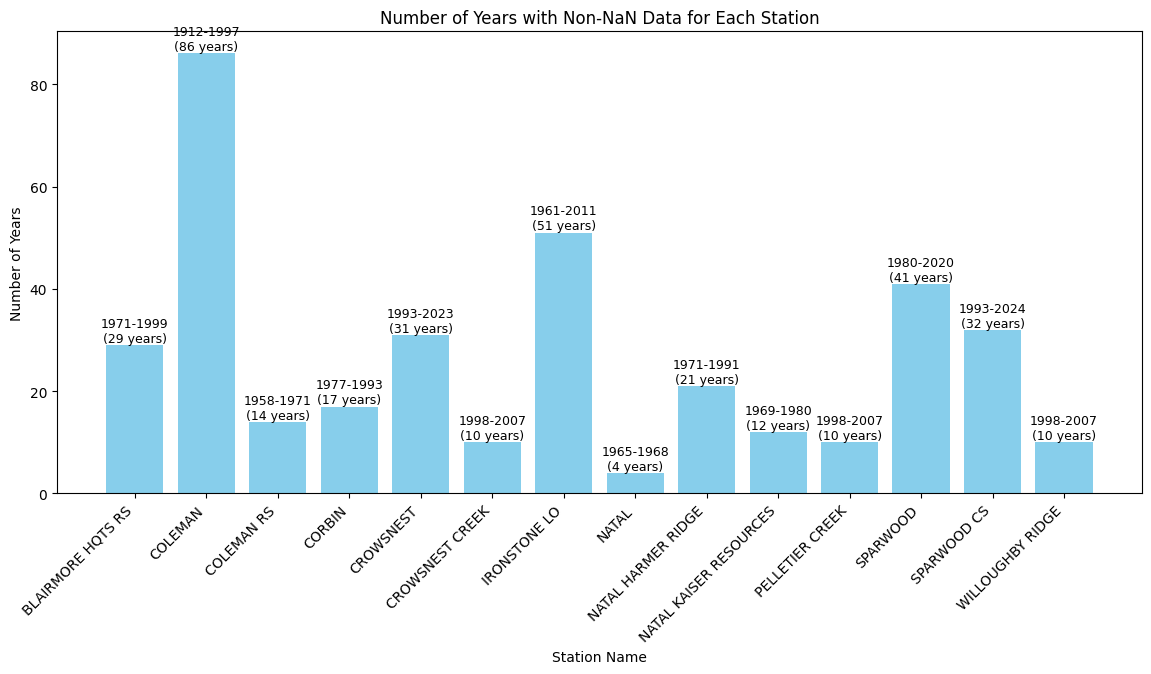

In [17]:
# Group by 'station_name' and get the range of years for each station
station_years_range = (
    weathercan_df.dropna(subset=['total_precip'])  # Exclude rows with NaN in 'total_precip'
    .groupby('station_name')['year']
    .agg(['min', 'max'])
)

# Calculate the number of years for each station
station_years_range['count'] = station_years_range['max'] - station_years_range['min'] + 1

# Plotting the histogram with the correct year range and station names
plt.figure(figsize=(14, 6))

# Plotting the bar chart
bar_plot = plt.bar(station_years_range.index, station_years_range['count'], color='skyblue')

# Adding text on top of each bar with the correct year range
for bar, min_year, max_year, count in zip(bar_plot, station_years_range['min'], station_years_range['max'], station_years_range['count']):
    end_year = min(max_year, weathercan_df['year'].max())  # Set the maximum year to the overall max year
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{min_year}-{end_year}\n({count} years)",
             ha='center', va='bottom', fontsize=9, color='black')

plt.title('Number of Years with Non-NaN Data for Each Station')
plt.xlabel('Station Name')
plt.ylabel('Number of Years')
plt.xticks(rotation=45, ha='right')
plt.show()

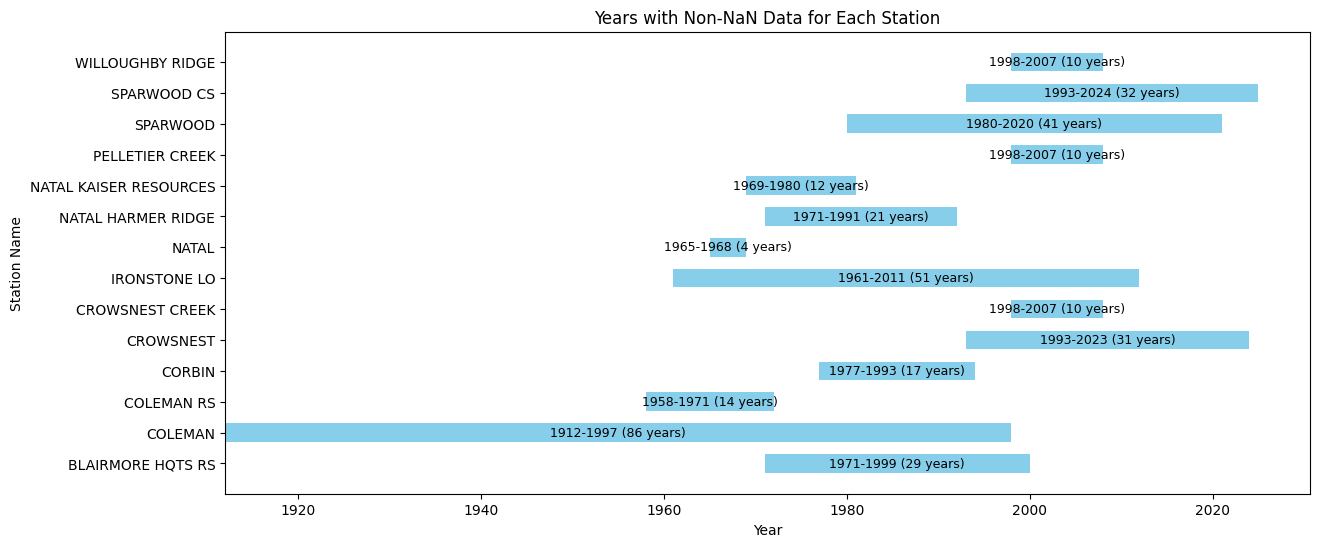

In [18]:

# Group by 'station_name' and get the range of years for each station
station_years_range = (
    weathercan_df.dropna(subset=['total_precip'])  # Exclude rows with NaN in 'total_precip'
    .groupby('station_name')['year']
    .agg(['min', 'max'])
)

# Calculate the number of years for each station
station_years_range['count'] = station_years_range['max'] - station_years_range['min'] + 1

# Plotting the horizontal bar chart
plt.figure(figsize=(14, 6))
bar_plot = plt.barh(station_years_range.index, station_years_range['count'], 
                   left=station_years_range['min'], color='skyblue', height=0.6)

# Adding concise text beside each bar with the correct year range
for bar, min_year, max_year, count in zip(bar_plot, station_years_range['min'], station_years_range['max'], station_years_range['count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
             f"{min_year}-{max_year} ({count} years)", ha='center', va='center', fontsize=9, color='black')

plt.title('Years with Non-NaN Data for Each Station')
plt.xlabel('Year')
plt.ylabel('Station Name')
plt.show()


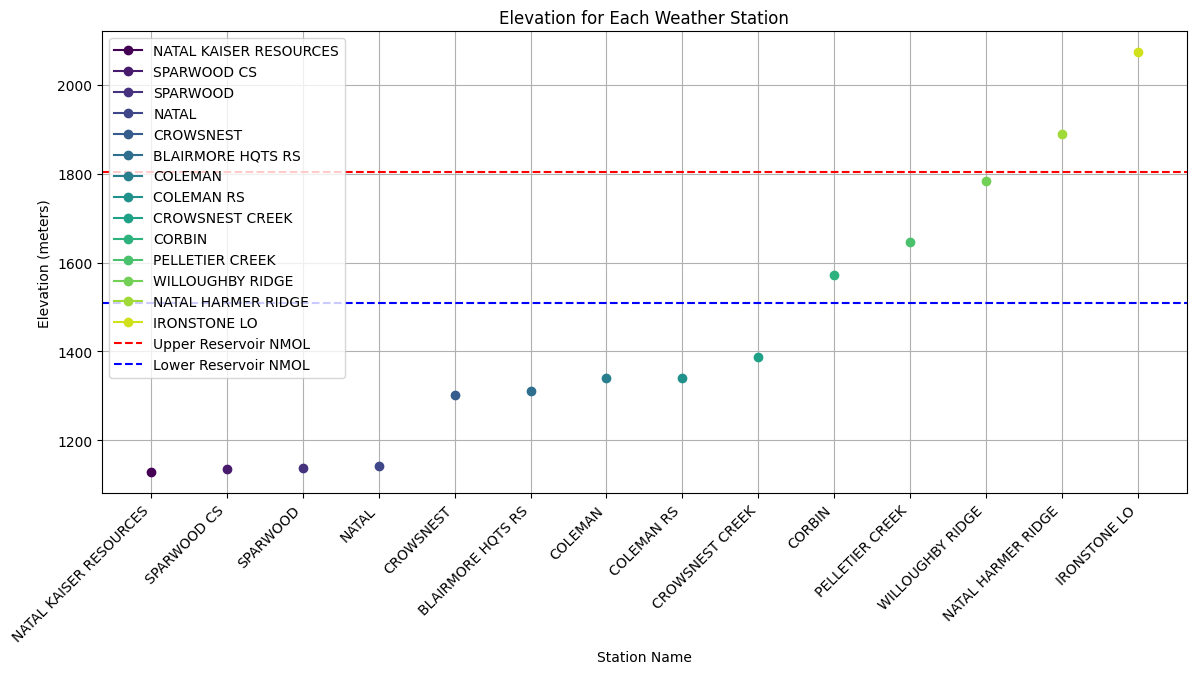

In [19]:
# Group by 'station_name' and get the mean elevation for each station
station_elevation = weathercan_df.groupby('station_name')['elev'].mean().reset_index()

# Sorting the data by elevation for better visualization
station_elevation = station_elevation.sort_values(by='elev')

# Elevation values for Upper and Lower Reservoir NMOL
upper_reservoir_elevation = 1803.3
lower_reservoir_elevation = 1509

# Plotting the line chart for station elevations with labels and different colors
plt.figure(figsize=(14, 6))
for i, (station, elevation) in enumerate(zip(station_elevation['station_name'], station_elevation['elev'])):
    plt.plot([i], [elevation], marker='o', linestyle='-', label=station, color=plt.cm.viridis(i / len(station_elevation)))

# Adding horizontal lines for Upper and Lower Reservoir NMOL elevations
plt.axhline(y=upper_reservoir_elevation, color='red', linestyle='--', label='Upper Reservoir NMOL')
plt.axhline(y=lower_reservoir_elevation, color='blue', linestyle='--', label='Lower Reservoir NMOL')

plt.title('Elevation for Each Weather Station')
plt.xlabel('Station Name')
plt.ylabel('Elevation (meters)')
plt.xticks(range(len(station_elevation)), station_elevation['station_name'], rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

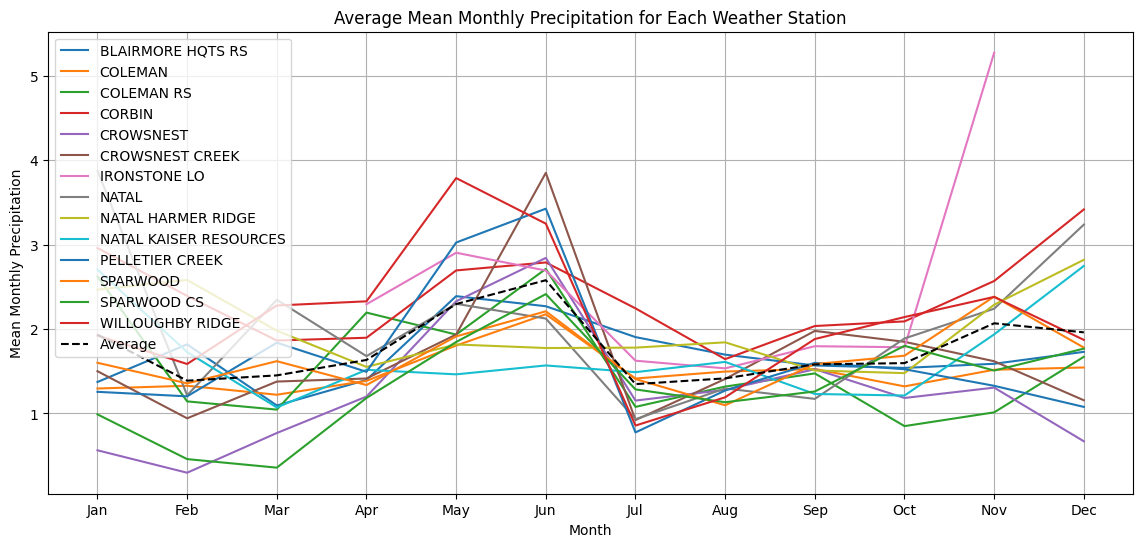

In [20]:
# Group by 'station_name', 'year', and 'month' and calculate the mean precipitation
mean_monthly_precip = (
    weathercan_df.groupby(['station_name', 'month'])['total_precip']
    .mean()
    .reset_index()
)

# Group by 'month' and calculate the average mean monthly precipitation for each station
average_monthly_precip = mean_monthly_precip.groupby('month')['total_precip'].mean().reset_index()

# Pivot the table to have each station as a line on the plot
station_monthly_precip = mean_monthly_precip.pivot(index='month', columns='station_name', values='total_precip')

# Plotting the line chart for average mean monthly precipitation for each station
plt.figure(figsize=(14, 6))
for station in station_monthly_precip.columns:
    plt.plot(station_monthly_precip.index, station_monthly_precip[station], label=station)

# Plotting the average mean monthly precipitation line
plt.plot(average_monthly_precip['month'], average_monthly_precip['total_precip'], linestyle='--', color='black', label='Average')

plt.title('Average Mean Monthly Precipitation for Each Weather Station')
plt.xlabel('Month')
plt.ylabel('Mean Monthly Precipitation')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(True)
plt.show()

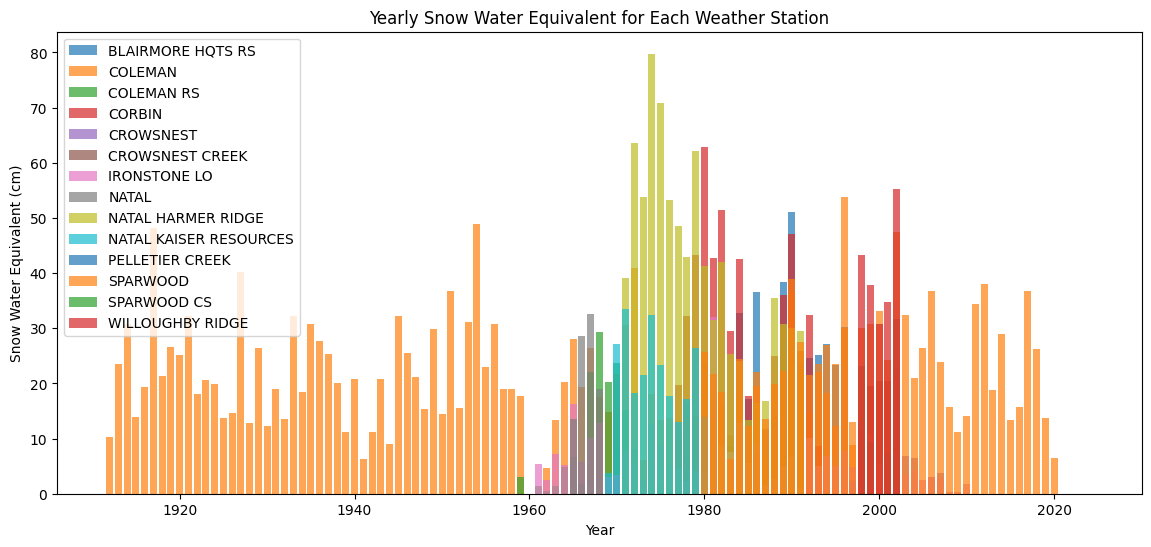

In [21]:
# Group by 'station_name' and 'year', then calculate the sum of snow water equivalent for each year and station
yearly_swe = weathercan_df.groupby(['station_name', 'year'])['swe'].sum().reset_index()

# Plotting the bar chart
plt.figure(figsize=(14, 6))
for station in yearly_swe['station_name'].unique():
    station_data = yearly_swe[yearly_swe['station_name'] == station]
    plt.bar(station_data['year'], station_data['swe'], label=station, alpha=0.7)

plt.title('Yearly Snow Water Equivalent for Each Weather Station')
plt.xlabel('Year')
plt.ylabel('Snow Water Equivalent (cm)')
plt.legend()
plt.show()

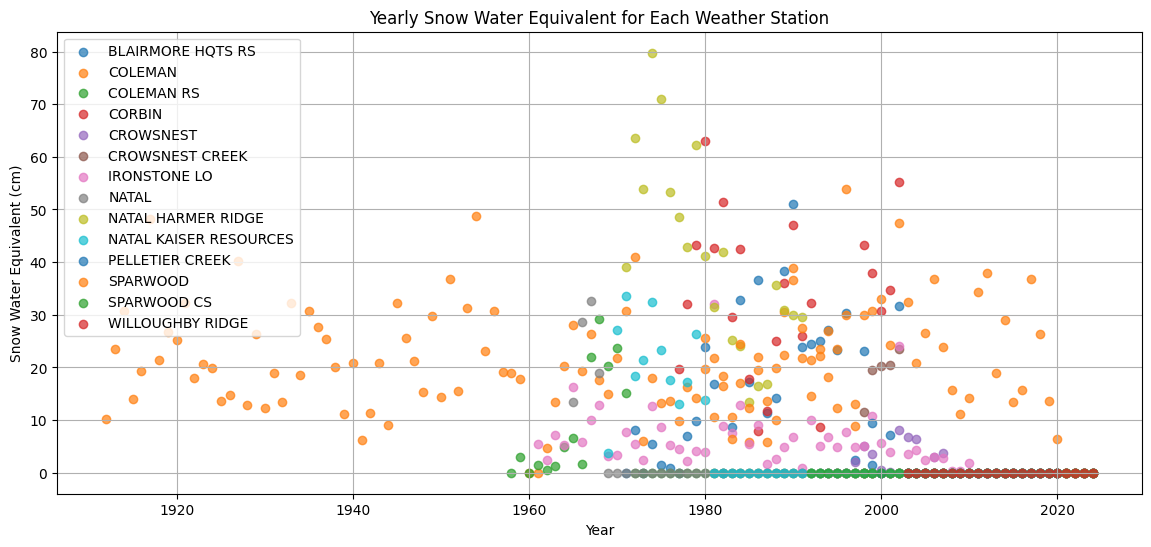

In [22]:
# Group by 'station_name' and 'year', then calculate the sum of snow water equivalent for each year and station
yearly_swe = weathercan_df.groupby(['station_name', 'year'])['swe'].sum().reset_index()

# Plotting the scatter plot
plt.figure(figsize=(14, 6))
for station in yearly_swe['station_name'].unique():
    station_data = yearly_swe[yearly_swe['station_name'] == station]
    plt.scatter(station_data['year'], station_data['swe'], label=station, alpha=0.7)

plt.title('Yearly Snow Water Equivalent for Each Weather Station')
plt.xlabel('Year')
plt.ylabel('Snow Water Equivalent (cm)')
plt.legend()
plt.grid(True)
plt.show()

### Gauge Station Visuals

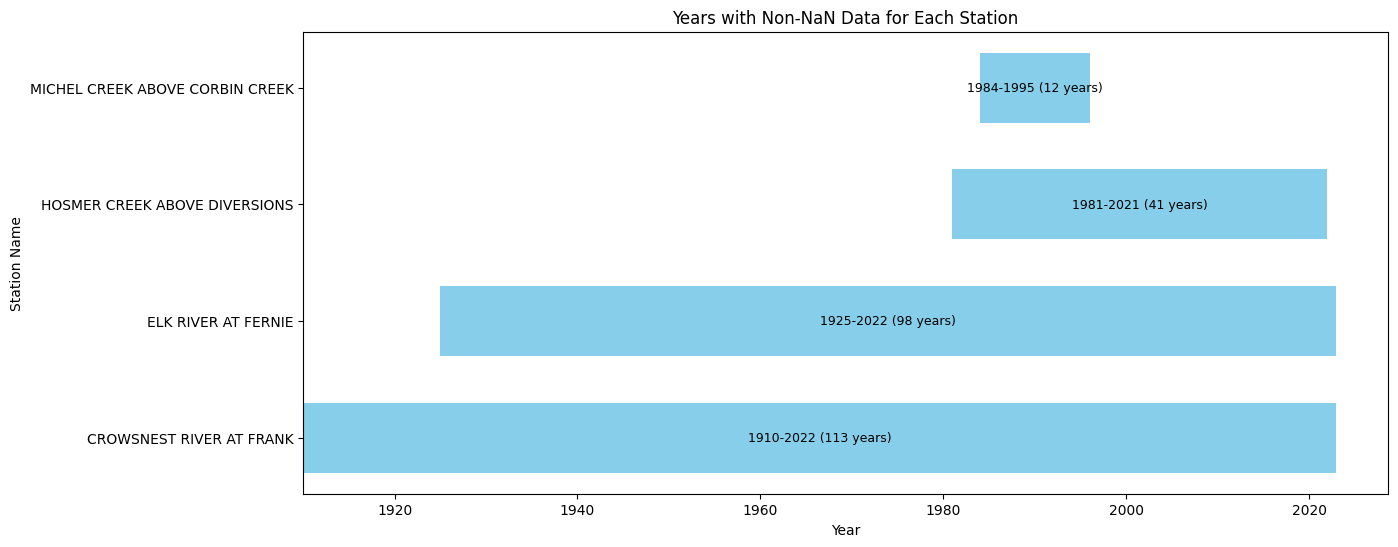

In [23]:
# Group by 'Station_name' and get the range of years for each station
station_years_range = (
    hydrometric_df.dropna(subset=['Date'])  # Exclude rows with NaN in 'Date'
    .groupby('Station_name')['Date']
    .agg(['min', 'max'])
)

# Calculate the number of years for each station
station_years_range['count'] = station_years_range['max'].dt.year - station_years_range['min'].dt.year + 1

# Plotting the horizontal bar chart
plt.figure(figsize=(14, 6))
bar_plot = plt.barh(station_years_range.index, station_years_range['count'], 
                   left=station_years_range['min'].dt.year, color='skyblue', height=0.6)

# Adding concise text beside each bar with the correct year range
for bar, min_year, max_year, count in zip(bar_plot, station_years_range['min'].dt.year, station_years_range['max'].dt.year, station_years_range['count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
             f"{min_year}-{max_year} ({count} years)", ha='center', va='center', fontsize=9, color='black')

plt.title('Years with Non-NaN Data for Each Station')
plt.xlabel('Year')
plt.ylabel('Station Name')
plt.show()


In [24]:

# plot flows over time for each gauge (peak annual discharge vs drainage area)


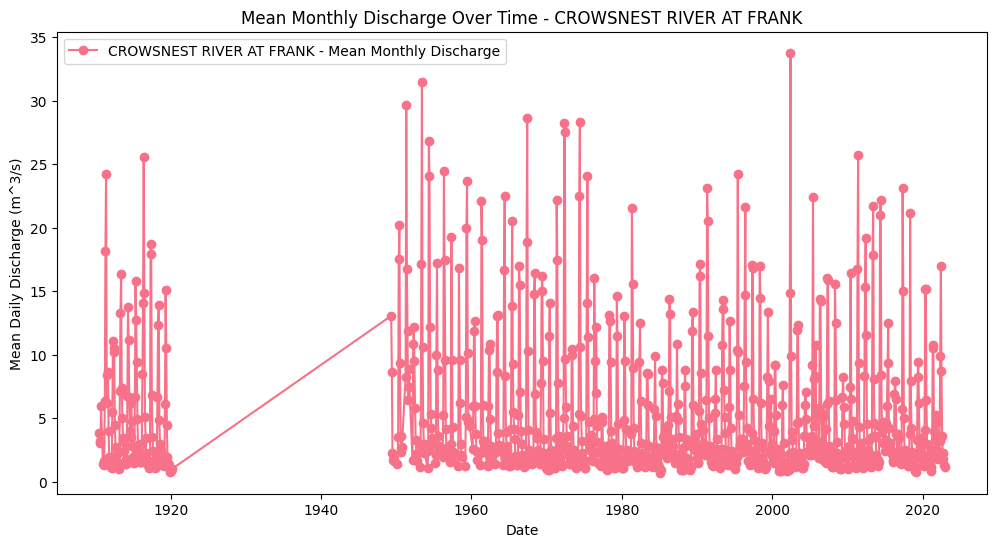

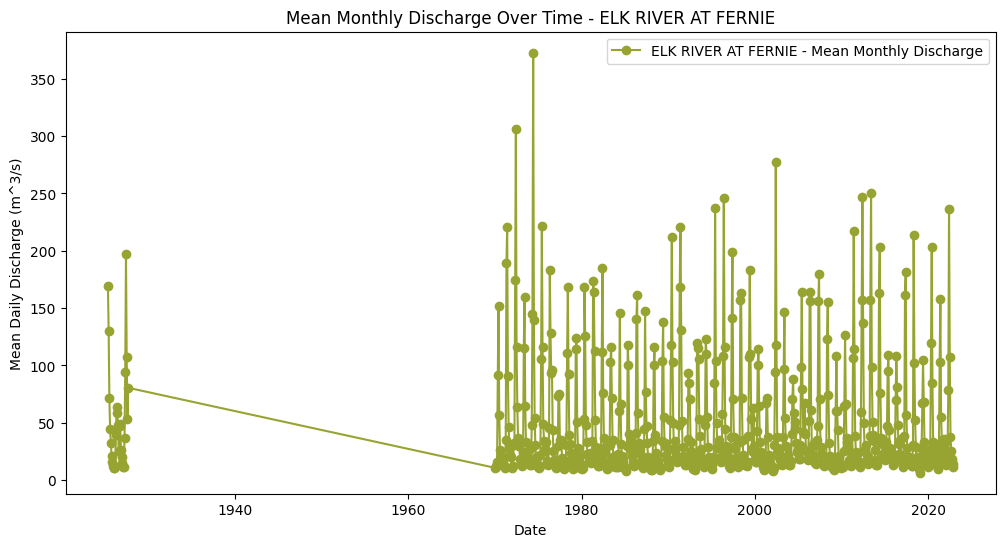

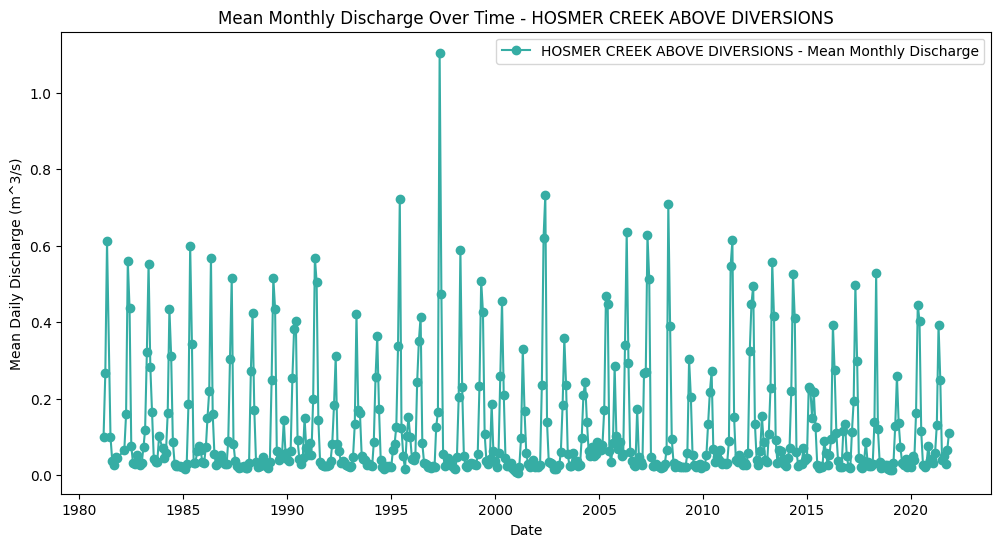

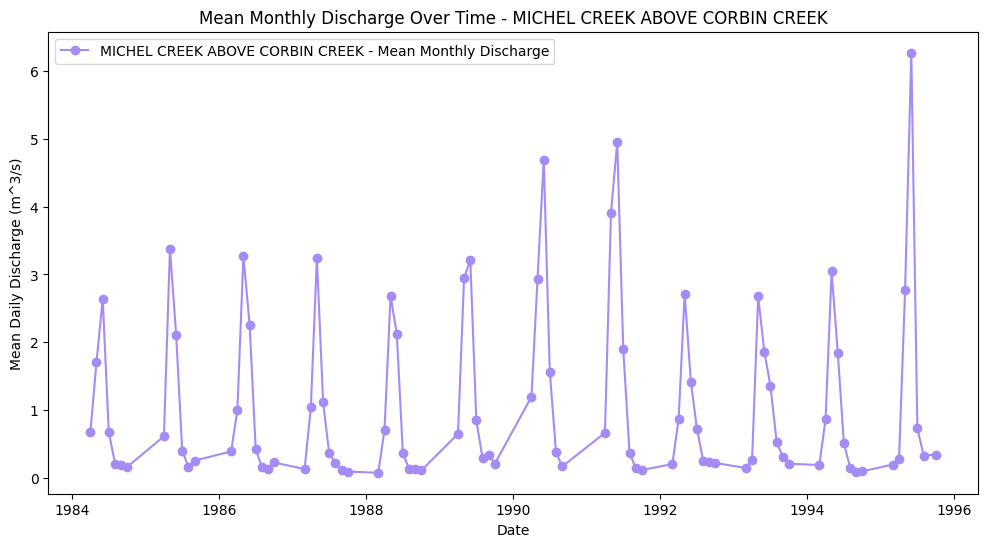

In [25]:
# Group by 'Station_name', 'Year', and 'Month', then calculate the mean monthly discharge
mean_monthly_discharge = hydrometric_df.groupby(['Station_name', 'Year', 'Month'])['Daily_Discharge_m3/s'].mean().reset_index()

# Create a new 'Date' column combining 'Year' and 'Month'
mean_monthly_discharge['Year_Month'] = pd.to_datetime(mean_monthly_discharge[['Year', 'Month']].assign(DAY=1))

# Create a color palette for each station
palette = sns.color_palette('husl', n_colors=len(mean_monthly_discharge['Station_name'].unique()))
station_color_dict = dict(zip(mean_monthly_discharge['Station_name'].unique(), palette))

# Loop through each station and create individual plots
stations = mean_monthly_discharge['Station_name'].unique()

for station in stations:
    station_data = mean_monthly_discharge[mean_monthly_discharge['Station_name'] == station]
    
    plt.figure(figsize=(12, 6))
    plt.plot(station_data['Year_Month'], station_data['Daily_Discharge_m3/s'], label=f'{station} - Mean Monthly Discharge', marker='o', color=station_color_dict[station])
    plt.title(f'Mean Monthly Discharge Over Time - {station}')
    plt.xlabel('Date')
    plt.ylabel('Mean Daily Discharge (m^3/s)')
    plt.legend()
    plt.show()

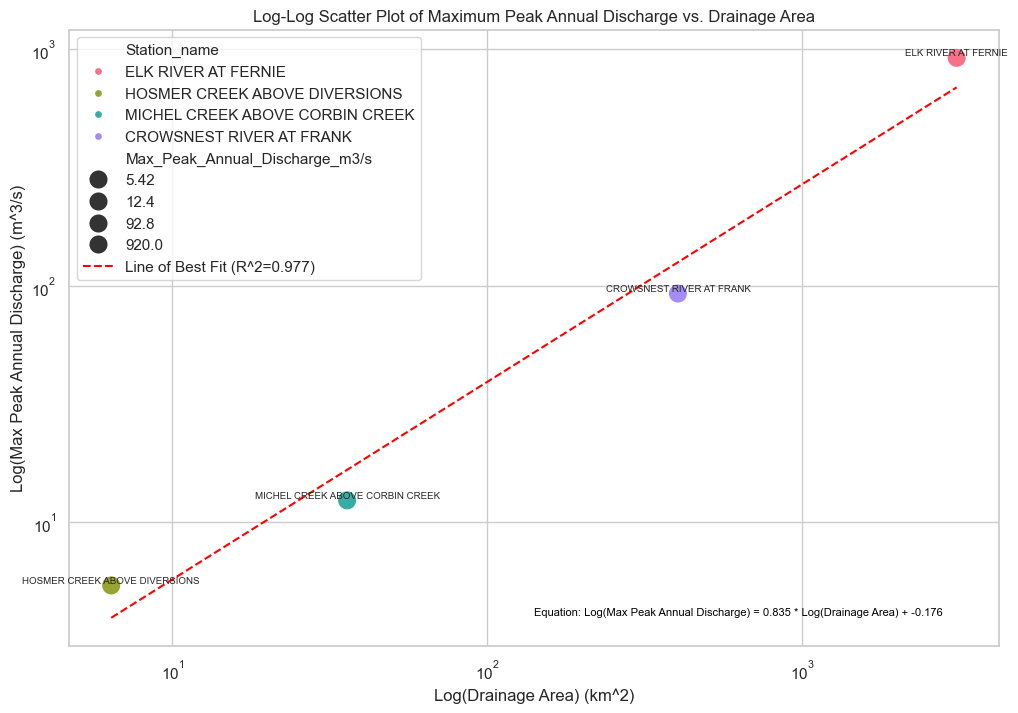

In [26]:
# Create a DataFrame with unique station information (including drainage area)
unique_station_info = hydrometric_df[['Station_name', 'gross_drainage_area_km2']].drop_duplicates()

# Merge unique station information with maximum peak annual discharge data
station_peak_area = pd.merge(unique_station_info, hydrometric_df.groupby('Station_name')['Max_Peak_Annual_Discharge_m3/s'].max().reset_index(), on='Station_name')

# Set up Seaborn style
sns.set(style="whitegrid")

# Plotting the log-log scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    x='gross_drainage_area_km2',
    y='Max_Peak_Annual_Discharge_m3/s',
    hue='Station_name',
    size='Max_Peak_Annual_Discharge_m3/s', 
    sizes=(200, 200),
    data=station_peak_area,
    palette=sns.color_palette("husl", n_colors=len(station_peak_area['Station_name'])),
    legend='full'
)
# Adding labels above the dots
for i, row in station_peak_area.iterrows():
    plt.text(row['gross_drainage_area_km2'], row['Max_Peak_Annual_Discharge_m3/s'], row['Station_name'],
             fontsize=7, ha='center', va='bottom')

# Adding labels and title
plt.title('Log-Log Scatter Plot of Maximum Peak Annual Discharge vs. Drainage Area')
plt.xlabel('Log(Drainage Area) (km^2)')
plt.ylabel('Log(Max Peak Annual Discharge) (m^3/s)')

# Setting log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Adding a regression line
slope, intercept, r_value, p_value, std_err = linregress(np.log(station_peak_area['gross_drainage_area_km2']),
                                                          np.log(station_peak_area['Max_Peak_Annual_Discharge_m3/s']))

x_values = np.linspace(np.log(station_peak_area['gross_drainage_area_km2'].min()),
                       np.log(station_peak_area['gross_drainage_area_km2'].max()), 100)
y_values = slope * x_values + intercept

plt.plot(np.exp(x_values), np.exp(y_values), color='red', linestyle='--', label=f'Line of Best Fit (R^2={r_value**2:.3f})')

# Displaying the equation of the line
equation_label = f'Equation: Log(Max Peak Annual Discharge) = {slope:.3f} * Log(Drainage Area) + {intercept:.3f}'
plt.text(0.5, 0.05, equation_label, transform=scatter_plot.transAxes, fontsize=8, color='black')


# Displaying the legend
plt.legend()

# Displaying the plot
plt.show()

## Cross-Correlation 

In [154]:
# selected_columns = ['station_name', 'station_id', 'date', 'total_precip']
# weathercan_total_precip_df = weathercan_df[selected_columns].copy()

# weathercan_total_precip_df.to_csv('weathercan_total_precip.csv', index=False)

### Station Combinations of at least 5 years of overlapping daily data

In [142]:
combo1 = ['IRONSTONE LO', 'COLEMAN RS', 'COLEMAN'] # 287
combo2 = ['NATAL KAISER RESOURCES', 'NATAL HARMER RIDGE', 'IRONSTONE LO', 'COLEMAN', 'BLAIRMORE HQTS RS'] # 142
combo3 = ['NATAL HARMER RIDGE', 'IRONSTONE LO', 'CROWSNEST', 'COLEMAN', 'BLAIRMORE HQTS RS'] # 60
combo4 = ['WILLOUGHBY RIDGE', 'SPARWOOD CS', 'SPARWOOD', 'PELLETIER CREEK', 'IRONSTONE LO', 'CROWSNEST CREEK', 'CROWSNEST'] # 19

combo5 = ['COLEMAN', 'BLAIRMORE HQTS RS'] # 1481
combo6 = ['COLEMAN', 'IRONSTONE LO'] # 1468
combo7 = ['IRONSTONE LO', 'CROWSNEST'] # 468
combo8 = ['IRONSTONE LO', 'NATAL HARMER RIDGE'] # 672
combo9 = ['SPARWOOD CS', 'SPARWOOD'] # 1233
combo10 = ['WILLOUGHBY RIDGE', 'SPARWOOD'] # 670
combo11 = ['COLEMAN', 'IRONSTONE LO'] # 1468
combo12 = ['NATAL HARMER RIDGE', 'NATAL KAISER RESOURCES'] # 860
combo13 = ['IRONSTONE LO', 'BLAIRMORE HQTS RS'] # 865

In [120]:
combo1_df = extract_and_transform(combo1, weathercan_df)
combo1_df.head()

station_name       date  COLEMAN  COLEMAN RS  IRONSTONE LO
0            1962-05-15      3.0         4.1           2.5
1            1962-05-18     10.9        15.0          12.7
2            1962-05-19      3.8         4.3           4.1
3            1962-06-02      1.0         1.0           1.0
4            1962-06-08      3.3         2.5           3.8

In [121]:
combo1_df.describe() # not enough data

station_name                           date     COLEMAN  COLEMAN RS  \
count                                   287  287.000000  287.000000   
mean          1966-05-09 05:26:07.944250864    6.850871    6.659582   
min                     1962-05-15 00:00:00    0.300000    0.300000   
25%                     1964-07-14 00:00:00    2.300000    2.000000   
50%                     1966-05-31 00:00:00    4.600000    4.100000   
75%                     1968-06-22 12:00:00    9.100000    8.750000   
max                     1970-09-08 00:00:00   52.300000   53.600000   
std                                     NaN    7.108716    7.376345   

station_name  IRONSTONE LO  
count           287.000000  
mean              8.170035  
min               0.300000  
25%               2.650000  
50%               5.600000  
75%              10.200000  
max              58.400000  
std               8.422186

In [122]:
nan_check = combo1_df.isna().any()
nan_check[nan_check].index.tolist()
combo1_df.isna().sum()

station_name
date            0
COLEMAN         0
COLEMAN RS      0
IRONSTONE LO    0
dtype: int64

In [123]:
combo2_df = extract_and_transform(combo2, weathercan_df)
combo2_df.head()

station_name       date  BLAIRMORE HQTS RS  COLEMAN  IRONSTONE LO  \
0            1971-07-27               12.2     14.5           8.6   
1            1972-06-09                2.5     20.3           7.6   
2            1972-06-10                5.1      5.6           1.0   
3            1972-06-12                3.0      1.5           0.5   
4            1972-06-15                1.0      3.8           1.0   

station_name  NATAL HARMER RIDGE  NATAL KAISER RESOURCES  
0                            6.9                     7.6  
1                            7.1                    10.9  
2                            5.1                     4.8  
3                            2.0                     0.3  
4                            2.8                     0.3

In [124]:
combo2_df.describe()

station_name                           date  BLAIRMORE HQTS RS     COLEMAN  \
count                                   142         142.000000  142.000000   
mean          1976-04-02 08:27:02.535211264           8.659859    8.700704   
min                     1971-07-27 00:00:00           0.200000    0.300000   
25%                     1975-06-07 06:00:00           2.100000    3.000000   
50%                     1976-07-12 12:00:00           5.300000    5.950000   
75%                     1977-08-23 18:00:00          12.075000   11.625000   
max                     1979-10-19 00:00:00          54.400000   63.000000   
std                                     NaN           9.739880    8.902454   

station_name  IRONSTONE LO  NATAL HARMER RIDGE  NATAL KAISER RESOURCES  
count           142.000000          142.000000               142.00000  
mean              9.715493            7.926761                 7.20000  
min               0.200000            0.300000                 0.30000  
25%               2.825000            3.000000                 2.85000  
50%               7.450000            5.700000                 5.25000  
75%              13.650000           10.850000                 9.95000  
max              49.700000           53.300000                37.60000  
std               9.094151            7.494413                 6.17121

In [125]:
nan_check = combo2_df.isna().any()
nan_check[nan_check].index.tolist()
combo2_df.isna().sum()

station_name
date                      0
BLAIRMORE HQTS RS         0
COLEMAN                   0
IRONSTONE LO              0
NATAL HARMER RIDGE        0
NATAL KAISER RESOURCES    0
dtype: int64

In [126]:
combo3_df = extract_and_transform(combo3, weathercan_df)
combo3_df.head()

station_name       date  BLAIRMORE HQTS RS  COLEMAN  CROWSNEST  IRONSTONE LO
0            1993-07-02                1.1      3.5        5.4           8.6
1            1993-07-04               10.4      8.6        0.4           5.0
2            1993-07-08               15.5     25.6        1.4           8.3
3            1993-07-14                1.8      2.6        2.4           0.6
4            1994-08-03                2.8      4.8        4.8           3.7

In [127]:
combo3_df.describe()

station_name                 date  BLAIRMORE HQTS RS    COLEMAN  CROWSNEST  \
count                          60          60.000000  60.000000  60.000000   
mean          1996-01-05 06:24:00           9.346667   6.293333   9.446667   
min           1993-07-02 00:00:00           0.200000   0.400000   0.200000   
25%           1995-06-05 18:00:00           1.075000   1.775000   1.550000   
50%           1996-01-20 00:00:00           2.700000   3.350000   4.600000   
75%           1996-09-18 06:00:00          11.200000   7.125000  11.300000   
max           1997-06-29 00:00:00          79.000000  34.800000  97.600000   
std                           NaN          14.838983   7.626045  14.933360   

station_name  IRONSTONE LO  
count            60.000000  
mean              7.466667  
min               0.300000  
25%               1.875000  
50%               4.700000  
75%               8.150000  
max              63.000000  
std               9.959812

In [75]:
nan_check = combo3_df.isna().any()
nan_check[nan_check].index.tolist()
combo3_df.isna().sum()

station_name
date                 0
BLAIRMORE HQTS RS    0
COLEMAN              0
CROWSNEST            0
IRONSTONE LO         0
dtype: int64

In [128]:
combo4_df = extract_and_transform(combo4, weathercan_df)
combo4_df.head()

station_name       date  CROWSNEST  CROWSNEST CREEK  IRONSTONE LO  \
0            2003-09-08        6.6              5.3           7.1   
1            2003-09-09        1.4              2.0           1.1   
2            2003-09-11        2.5              1.8           9.2   
3            2003-09-15        4.2              3.5           2.6   
4            2003-09-16        3.0              3.0           8.0   

station_name  PELLETIER CREEK  SPARWOOD  SPARWOOD CS  WILLOUGHBY RIDGE  
0                         7.9       8.4          6.8               5.5  
1                         3.0       3.0          2.8               3.5  
2                         2.5       5.8          5.2               3.5  
3                         2.0       2.2          3.8               7.5  
4                         9.9       7.4          4.2               9.0

In [129]:
combo4_df.describe()

station_name                           date  CROWSNEST  CROWSNEST CREEK  \
count                                    19  19.000000        19.000000   
mean          2004-03-31 21:28:25.263157888   5.636842         6.568421   
min                     2003-09-08 00:00:00   0.200000         0.300000   
25%                     2004-01-17 00:00:00   1.800000         2.250000   
50%                     2004-06-06 00:00:00   4.200000         5.300000   
75%                     2004-06-21 12:00:00   6.900000         7.750000   
max                     2004-07-20 00:00:00  17.800000        38.200000   
std                                     NaN   5.158511         8.301141   

station_name  IRONSTONE LO  PELLETIER CREEK   SPARWOOD  SPARWOOD CS  \
count            19.000000        19.000000  19.000000    19.000000   
mean              5.589474         5.321053   5.647368     5.557895   
min               1.100000         0.800000   0.200000     0.200000   
25%               3.000000         1.900000   2.650000     3.300000   
50%               5.200000         3.000000   4.800000     5.000000   
75%               7.550000         7.650000   7.900000     6.900000   
max              14.400000        19.600000  14.900000    13.000000   
std               3.429431         4.729996   4.219711     3.586753   

station_name  WILLOUGHBY RIDGE  
count                19.000000  
mean                  7.768421  
min                   1.000000  
25%                   3.400000  
50%                   5.600000  
75%                   9.650000  
max                  31.800000  
std                   7.532452

In [130]:
nan_check = combo4_df.isna().any()
nan_check[nan_check].index.tolist()
combo4_df.isna().sum()

station_name
date                0
CROWSNEST           0
CROWSNEST CREEK     0
IRONSTONE LO        0
PELLETIER CREEK     0
SPARWOOD            0
SPARWOOD CS         0
WILLOUGHBY RIDGE    0
dtype: int64

In [145]:
combo5_df = extract_and_transform(combo5, weathercan_df)
combo5_df.describe()

station_name                           date  BLAIRMORE HQTS RS      COLEMAN
count                                  1481        1481.000000  1481.000000
mean          1986-10-08 19:19:58.379473344           6.406820     5.344970
min                     1971-06-03 00:00:00           0.200000     0.200000
25%                     1981-06-01 00:00:00           1.400000     1.300000
50%                     1987-04-17 00:00:00           3.500000     3.000000
75%                     1992-05-22 00:00:00           8.000000     6.600000
max                     1997-09-26 00:00:00          79.000000    63.000000
std                                     NaN           8.223998     6.489564

In [146]:
combo6_df = extract_and_transform(combo6, weathercan_df)
combo6_df.describe()

station_name                           date      COLEMAN  IRONSTONE LO
count                                  1468  1468.000000   1468.000000
mean          1980-09-02 05:07:01.798365120     5.737943      6.646185
min                     1962-05-15 00:00:00     0.200000      0.200000
25%                     1972-06-29 12:00:00     1.500000      1.500000
50%                     1981-05-21 12:00:00     3.450000      3.800000
75%                     1989-06-24 12:00:00     7.500000      8.400000
max                     1997-09-17 00:00:00    63.000000     75.800000
std                                     NaN     6.629208      8.208762

In [147]:
combo7_df = extract_and_transform(combo7, weathercan_df)
combo7_df.describe()

station_name                 date   CROWSNEST  IRONSTONE LO
count                         468  468.000000    468.000000
mean          2001-12-12 08:00:00    5.526923      5.725000
min           1993-06-07 00:00:00    0.200000      0.200000
25%           1998-06-26 18:00:00    0.800000      1.200000
50%           2001-06-26 12:00:00    2.400000      3.200000
75%           2005-06-27 06:00:00    6.850000      7.325000
max           2011-08-11 00:00:00   97.600000     69.000000
std                           NaN    8.384252      7.868863

In [148]:
combo8_df = extract_and_transform(combo8, weathercan_df)
combo8_df.describe()

station_name                           date  IRONSTONE LO  NATAL HARMER RIDGE
count                                   672    672.000000          672.000000
mean          1981-04-15 09:49:17.142857152      6.711905            5.935714
min                     1971-07-27 00:00:00      0.200000            0.200000
25%                     1976-05-23 00:00:00      1.500000            2.000000
50%                     1980-09-09 00:00:00      3.800000            4.000000
75%                     1986-05-06 18:00:00      8.525000            8.000000
max                     1991-06-30 00:00:00     70.600000           53.300000
std                                     NaN      8.473274            6.023650

In [149]:
combo9_df = extract_and_transform(combo9, weathercan_df)
combo9_df.describe()

station_name                           date     SPARWOOD  SPARWOOD CS
count                                  1233  1233.000000  1233.000000
mean          2006-01-07 12:44:57.810219136     4.418816     4.247283
min                     1993-04-03 00:00:00     0.100000     0.100000
25%                     1997-06-19 00:00:00     0.900000     0.800000
50%                     2005-10-07 00:00:00     2.400000     2.400000
75%                     2014-04-27 00:00:00     5.600000     5.600000
max                     2019-08-16 00:00:00    81.800000    63.000000
std                                     NaN     5.976058     5.569692

In [150]:
combo10_df = extract_and_transform(combo10, weathercan_df)
combo10_df.describe()

station_name                           date    SPARWOOD  WILLOUGHBY RIDGE
count                                   670  670.000000        670.000000
mean          2002-08-29 12:04:17.910447872    5.457164          7.203582
min                     1998-04-04 00:00:00    0.200000          0.300000
25%                     2000-04-05 06:00:00    1.200000          1.500000
50%                     2002-09-05 12:00:00    3.400000          4.300000
75%                     2004-08-06 18:00:00    7.075000          9.400000
max                     2007-11-17 00:00:00   49.100000        103.000000
std                                     NaN    6.269355          9.382243

In [151]:
combo11_df = extract_and_transform(combo11, weathercan_df)
combo11_df.describe()

station_name                           date      COLEMAN  IRONSTONE LO
count                                  1468  1468.000000   1468.000000
mean          1980-09-02 05:07:01.798365120     5.737943      6.646185
min                     1962-05-15 00:00:00     0.200000      0.200000
25%                     1972-06-29 12:00:00     1.500000      1.500000
50%                     1981-05-21 12:00:00     3.450000      3.800000
75%                     1989-06-24 12:00:00     7.500000      8.400000
max                     1997-09-17 00:00:00    63.000000     75.800000
std                                     NaN     6.629208      8.208762

In [152]:
combo12_df = extract_and_transform(combo12, weathercan_df)
combo12_df.describe()

station_name                           date  NATAL HARMER RIDGE  \
count                                   860          860.000000   
mean          1975-10-06 21:20:55.813953504            6.901744   
min                     1971-07-27 00:00:00            0.300000   
25%                     1973-11-02 06:00:00            2.500000   
50%                     1975-07-30 12:00:00            4.550000   
75%                     1977-12-10 06:00:00            9.425000   
max                     1980-03-29 00:00:00           53.300000   
std                                     NaN            6.991782   

station_name  NATAL KAISER RESOURCES  
count                     860.000000  
mean                        5.524070  
min                         0.200000  
25%                         1.300000  
50%                         3.600000  
75%                         7.450000  
max                        49.000000  
std                         6.302226

In [153]:
combo13_df = extract_and_transform(combo13, weathercan_df)
combo13_df.describe()

station_name                           date  BLAIRMORE HQTS RS  IRONSTONE LO
count                                   865         865.000000    865.000000
mean          1985-02-15 08:11:05.895953728           6.246705      6.645434
min                     1971-06-03 00:00:00           0.200000      0.200000
25%                     1978-07-21 00:00:00           1.200000      1.500000
50%                     1984-05-22 00:00:00           3.000000      3.800000
75%                     1991-07-09 00:00:00           7.900000      8.100000
max                     1999-09-27 00:00:00          79.000000     75.800000
std                                     NaN           8.702319      8.486985

### Cross-Correlation Matrices

In [155]:
c1_monthly_dataframes = create_monthly_dataframes(combo1_df)
c2_monthly_dataframes = create_monthly_dataframes(combo2_df)
c3_monthly_dataframes = create_monthly_dataframes(combo3_df)
c4_monthly_dataframes = create_monthly_dataframes(combo4_df)
c5_monthly_dataframes = create_monthly_dataframes(combo5_df)
c6_monthly_dataframes = create_monthly_dataframes(combo6_df)
c7_monthly_dataframes = create_monthly_dataframes(combo7_df)
c8_monthly_dataframes = create_monthly_dataframes(combo8_df)
c9_monthly_dataframes = create_monthly_dataframes(combo9_df)
c10_monthly_dataframes = create_monthly_dataframes(combo10_df)
c11_monthly_dataframes = create_monthly_dataframes(combo11_df)
c12_monthly_dataframes = create_monthly_dataframes(combo12_df)
c13_monthly_dataframes = create_monthly_dataframes(combo13_df)


In [159]:
# for month, month_df in monthly_dataframes.items():
#     print(f"Month: {month}")
#     print(month_df)
#     print("------------------")

#### Combination 1 
['IRONSTONE LO', 'COLEMAN RS', 'COLEMAN'] 287 count

In [168]:
summary_combo1_monthly_df = describe_dataframes_to_dataframe(c1_monthly_dataframes)
summary_combo1_monthly_df

count       mean        std   min     25%    50%     75%  \
   station_name                                                             
5  COLEMAN        19.0   9.210526   9.480969   0.3   3.150   6.40  11.150   
   COLEMAN RS     19.0   8.063158   7.900788   0.3   3.150   4.30  10.900   
   IRONSTONE LO   19.0   7.563158   5.435910   0.3   3.550   6.60  12.450   
   month          19.0   5.000000   0.000000   5.0   5.000   5.00   5.000   
6  COLEMAN        86.0   8.545349   9.382081   0.3   2.350   5.35  11.350   
   COLEMAN RS     86.0   9.016279   9.859577   0.3   2.000   5.45  11.700   
   IRONSTONE LO   86.0  10.490698  11.345241   0.3   2.800   7.60  14.625   
   month          86.0   6.000000   0.000000   6.0   6.000   6.00   6.000   
7  COLEMAN        48.0   6.364583   6.035550   0.3   1.800   4.45  10.250   
   COLEMAN RS     48.0   5.085417   5.264776   0.3   1.225   2.80   7.450   
   IRONSTONE LO   48.0   5.958333   4.916357   0.3   1.950   4.85   8.900   
   month          48.0   7.000000   0.000000   7.0   7.000   7.00   7.000   
8  COLEMAN        48.0   5.833333   5.896170   0.5   2.450   3.60   6.950   
   COLEMAN RS     48.0   5.437500   6.318181   0.3   1.725   3.60   5.875   
   IRONSTONE LO   48.0   7.239583   7.095781   0.3   2.725   5.10   9.250   
   month          48.0   8.000000   0.000000   8.0   8.000   8.00   8.000   
9  COLEMAN        59.0   5.440678   4.321443   0.5   2.000   3.80   7.600   
   COLEMAN RS     59.0   5.672881   5.020229   0.3   1.900   3.80   9.100   
   IRONSTONE LO   59.0   7.555932   6.962591   0.5   3.450   5.10  10.200   
   month          59.0   9.000000   0.000000   9.0   9.000   9.00   9.000   
10 COLEMAN        24.0   5.470833   3.627130   1.5   3.300   3.80   7.225   
   COLEMAN RS     24.0   5.675000   5.449392   0.5   2.800   4.10   6.175   
   IRONSTONE LO   24.0   8.270833   8.621282   1.0   3.200   6.50   9.875   
   month          24.0  10.000000   0.000000  10.0  10.000  10.00  10.000   
11 COLEMAN         3.0   6.166667   4.619885   1.0   4.300   7.60   8.750   
   COLEMAN RS      3.0   2.233333   1.721434   0.3   1.550   2.80   3.200   
   IRONSTONE LO    3.0   7.033333   2.977135   3.6   6.100   8.60   8.750   
   month           3.0  11.000000   0.000000  11.0  11.000  11.00  11.000   

                  max  
   station_name        
5  COLEMAN       36.3  
   COLEMAN RS    27.4  
   IRONSTONE LO  18.3  
   month          5.0  
6  COLEMAN       52.3  
   COLEMAN RS    53.6  
   IRONSTONE LO  58.4  
   month          6.0  
7  COLEMAN       27.2  
   COLEMAN RS    22.1  
   IRONSTONE LO  22.6  
   month          7.0  
8  COLEMAN       26.2  
   COLEMAN RS    29.2  
   IRONSTONE LO  32.5  
   month          8.0  
9  COLEMAN       17.5  
   COLEMAN RS    20.6  
   IRONSTONE LO  27.9  
   month          9.0  
10 COLEMAN       15.5  
   COLEMAN RS    26.9  
   IRONSTONE LO  40.6  
   month         10.0  
11 COLEMAN        9.9  
   COLEMAN RS     3.6  
   IRONSTONE LO   8.9  
   month         11.0

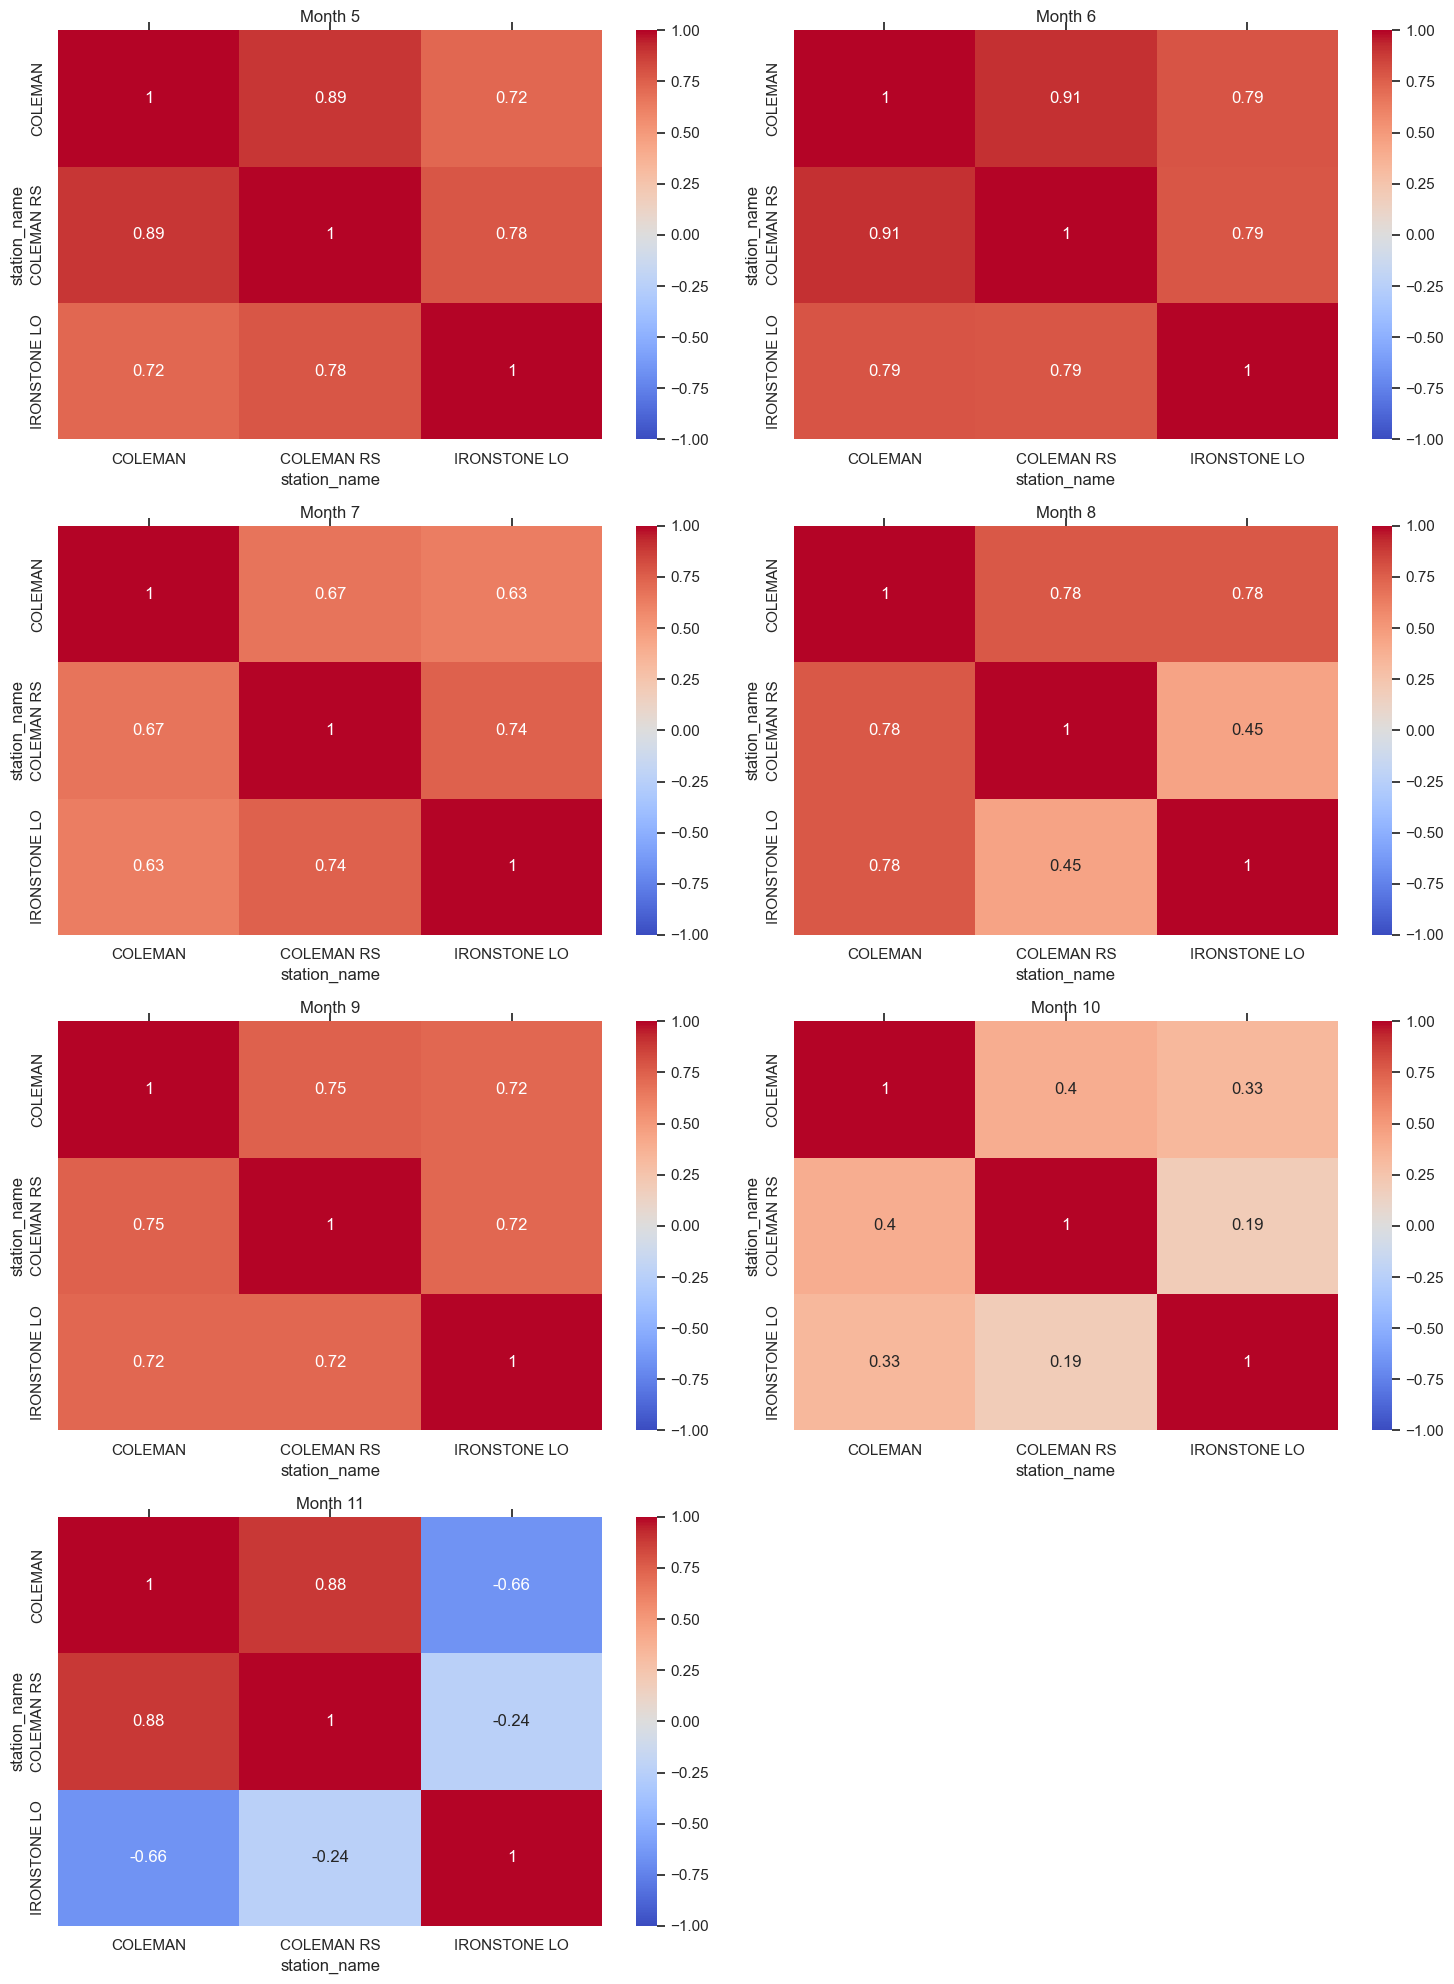

In [176]:
plot_cross_correlation_matrices(c1_monthly_dataframes)

#### Combination 2 
combo2 = ['NATAL KAISER RESOURCES', 'NATAL HARMER RIDGE', 'IRONSTONE LO', 'COLEMAN', 'BLAIRMORE HQTS RS'] 142 count

In [177]:
summary_combo2_monthly_df = describe_dataframes_to_dataframe(c2_monthly_dataframes)
summary_combo2_monthly_df

count       mean        std   min     25%    50%  \
   station_name                                                               
5  BLAIRMORE HQTS RS        14.0   8.535714  11.008501   0.3   2.025   5.05   
   COLEMAN                  14.0   5.542857   5.874287   0.3   1.000   3.40   
   IRONSTONE LO             14.0   9.157143   7.101973   0.8   3.350   7.75   
   NATAL HARMER RIDGE       14.0   7.378571   5.880369   0.8   2.200   6.00   
   NATAL KAISER RESOURCES   14.0   6.514286   6.149529   0.3   2.850   3.70   
   month                    14.0   5.000000   0.000000   5.0   5.000   5.00   
6  BLAIRMORE HQTS RS        22.0   7.340909   9.025660   0.2   2.200   3.80   
   COLEMAN                  22.0   6.700000   6.022023   1.0   2.800   4.30   
   IRONSTONE LO             22.0   7.686364   8.282414   0.5   2.075   4.95   
   NATAL HARMER RIDGE       22.0   4.845455   3.969734   0.8   2.075   3.95   
   NATAL KAISER RESOURCES   22.0   4.427273   3.897396   0.3   1.550   3.60   
   month                    22.0   6.000000   0.000000   6.0   6.000   6.00   
7  BLAIRMORE HQTS RS        31.0   9.167742   7.852532   0.5   2.450   6.40   
   COLEMAN                  31.0   9.303226   7.648376   1.3   4.200   7.40   
   IRONSTONE LO             31.0  11.490323   9.867805   1.3   3.900  10.00   
   NATAL HARMER RIDGE       31.0   8.754839   5.586939   0.5   4.300   7.10   
   NATAL KAISER RESOURCES   31.0   8.464516   5.983898   1.0   3.950   7.60   
   month                    31.0   7.000000   0.000000   7.0   7.000   7.00   
8  BLAIRMORE HQTS RS        42.0  10.164286  11.792884   0.3   2.600   6.35   
   COLEMAN                  42.0  10.780952  11.732491   0.3   3.075   6.50   
   IRONSTONE LO             42.0  10.152381  10.031541   0.3   3.250   7.35   
   NATAL HARMER RIDGE       42.0   8.954762  10.113290   0.3   2.575   5.30   
   NATAL KAISER RESOURCES   42.0   8.800000   7.724589   0.5   3.375   8.30   
   month                    42.0   8.000000   0.000000   8.0   8.000   8.00   
9  BLAIRMORE HQTS RS        24.0   7.983333   9.674919   0.5   1.475   5.55   
   COLEMAN                  24.0   7.983333   8.122094   0.8   3.175   6.10   
   IRONSTONE LO             24.0   8.266667   8.062078   0.2   2.975   5.25   
   NATAL HARMER RIDGE       24.0   7.637500   7.418298   1.0   3.875   5.90   
   NATAL KAISER RESOURCES   24.0   5.945833   4.703281   0.4   3.325   5.25   
   month                    24.0   9.000000   0.000000   9.0   9.000   9.00   
10 BLAIRMORE HQTS RS         9.0   5.111111   3.861167   0.8   2.000   4.30   
   COLEMAN                   9.0   8.633333   8.772400   1.0   3.000   4.30   
   IRONSTONE LO              9.0  11.255556   9.686087   0.6   3.000   7.60   
   NATAL HARMER RIDGE        9.0   9.433333   7.435220   0.5   4.000   8.40   
   NATAL KAISER RESOURCES    9.0   6.566667   4.410499   2.0   4.100   4.80   
   month                     9.0  10.000000   0.000000  10.0  10.000  10.00   

                              75%   max  
   station_name                          
5  BLAIRMORE HQTS RS        9.950  41.7  
   COLEMAN                  7.150  17.8  
   IRONSTONE LO            13.425  21.6  
   NATAL HARMER RIDGE      11.100  19.1  
   NATAL KAISER RESOURCES   7.550  18.0  
   month                    5.000   5.0  
6  BLAIRMORE HQTS RS        6.250  35.6  
   COLEMAN                  8.925  23.6  
   IRONSTONE LO             8.925  31.0  
   NATAL HARMER RIDGE       5.950  15.5  
   NATAL KAISER RESOURCES   5.400  14.2  
   month                    6.000   6.0  
7  BLAIRMORE HQTS RS       12.500  33.4  
   COLEMAN                 11.950  32.8  
   IRONSTONE LO            14.300  45.6  
   NATAL HARMER RIDGE      12.150  21.1  
   NATAL KAISER RESOURCES  12.200  25.4  
   month                    7.000   7.0  
8  BLAIRMORE HQTS RS       13.750  54.4  
   COLEMAN                 15.750  63.0  
   IRONSTONE LO            13.250  49.7  
   NATAL HARMER RIDGE      12.200  53.3  
   NATAL KAISER 

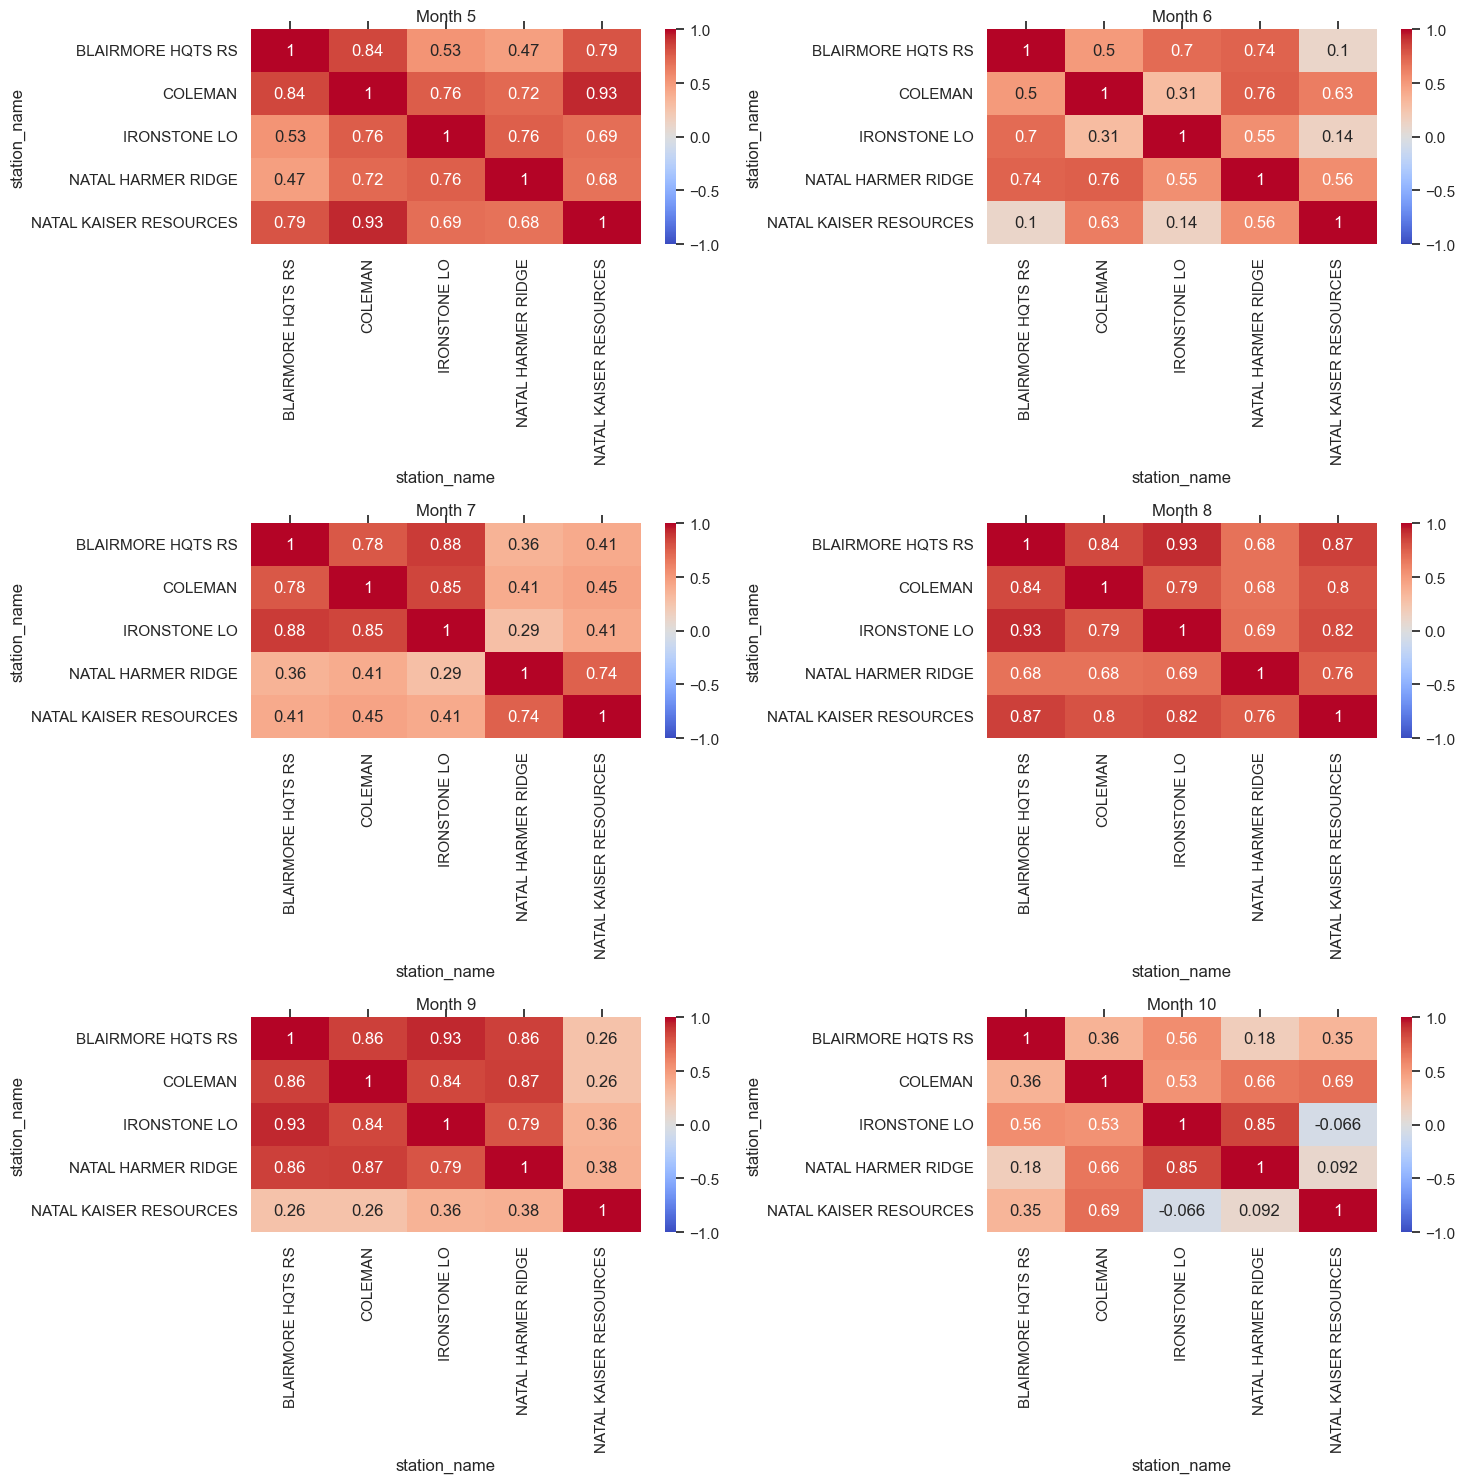

In [178]:
plot_cross_correlation_matrices(c2_monthly_dataframes)

#### Combination 3 
combo3 = ['NATAL HARMER RIDGE', 'IRONSTONE LO', 'CROWSNEST', 'COLEMAN', 'BLAIRMORE HQTS RS'] 60 count

In [179]:
summary_combo3_monthly_df = describe_dataframes_to_dataframe(c3_monthly_dataframes)
summary_combo3_monthly_df

count       mean        std  min    25%   50%     75%  \
  station_name                                                               
5 BLAIRMORE HQTS RS    8.0  10.062500   8.861625  0.4  2.500  8.75  16.600   
  COLEMAN              8.0   4.875000   5.354771  1.0  1.150  3.10   5.500   
  CROWSNEST            8.0  12.025000  10.276985  0.8  6.600  8.70  14.000   
  IRONSTONE LO         8.0   7.487500   4.748665  0.3  4.550  7.55  10.125   
  month                8.0   5.000000   0.000000  5.0  5.000  5.00   5.000   
6 BLAIRMORE HQTS RS   21.0  12.304762  22.092702  0.2  1.000  2.60   4.600   
  COLEMAN             21.0   7.661905   8.097622  1.2  2.000  4.60   7.600   
  CROWSNEST           21.0  12.257143  22.033079  0.2  2.400  4.00  10.800   
  IRONSTONE LO        21.0  10.433333  14.245397  0.3  2.300  5.80  16.000   
  month               21.0   6.000000   0.000000  6.0  6.000  6.00   6.000   
7 BLAIRMORE HQTS RS   10.0   9.420000   7.504784  0.6  1.900  9.80  16.775   
  COLEMAN             10.0   7.790000   7.985327  2.0  2.850  3.95   8.150   
  CROWSNEST           10.0   7.260000   9.921492  0.2  1.250  2.70   7.050   
  IRONSTONE LO        10.0   7.040000  10.031528  0.6  1.850  3.90   7.475   
  month               10.0   7.000000   0.000000  7.0  7.000  7.00   7.000   
8 BLAIRMORE HQTS RS   11.0   6.400000   8.199024  0.2  1.400  2.40   9.100   
  COLEMAN             11.0   2.900000   2.200909  0.4  1.100  3.00   4.200   
  CROWSNEST           11.0   3.945455   3.818996  0.2  1.400  2.20   5.500   
  IRONSTONE LO        11.0   4.336364   2.671431  0.5  2.450  4.20   6.250   
  month               11.0   8.000000   0.000000  8.0  8.000  8.00   8.000   
9 BLAIRMORE HQTS RS   10.0   5.730000  10.988484  0.6  1.050  2.00   2.650   
  COLEMAN             10.0   6.790000  11.004085  0.4  1.175  2.50   3.950   
  CROWSNEST           10.0   9.720000  10.937073  0.8  1.450  3.90  15.300   
  IRONSTONE LO        10.0   5.090000   5.852151  0.6  1.150  2.30   7.100   
  month               10.0   9.000000   0.000000  9.0  9.000  9.00   9.000   

                      max  
  station_name             
5 BLAIRMORE HQTS RS  24.6  
  COLEMAN            16.4  
  CROWSNEST          34.4  
  IRONSTONE LO       15.4  
  month               5.0  
6 BLAIRMORE HQTS RS  79.0  
  COLEMAN            27.2  
  CROWSNEST          97.6  
  IRONSTONE LO       63.0  
  month               6.0  
7 BLAIRMORE HQTS RS  18.6  
  COLEMAN            25.6  
  CROWSNEST          27.4  
  IRONSTONE LO       34.5  
  month               7.0  
8 BLAIRMORE HQTS RS  27.0  
  COLEMAN             7.5  
  CROWSNEST          13.0  
  IRONSTONE LO        8.1  
  month               8.0  
9 BLAIRMORE HQTS RS  36.4  
  COLEMAN            34.8  
  CROWSNEST          32.0  
  IRONSTONE LO       18.8  
  month               9.0

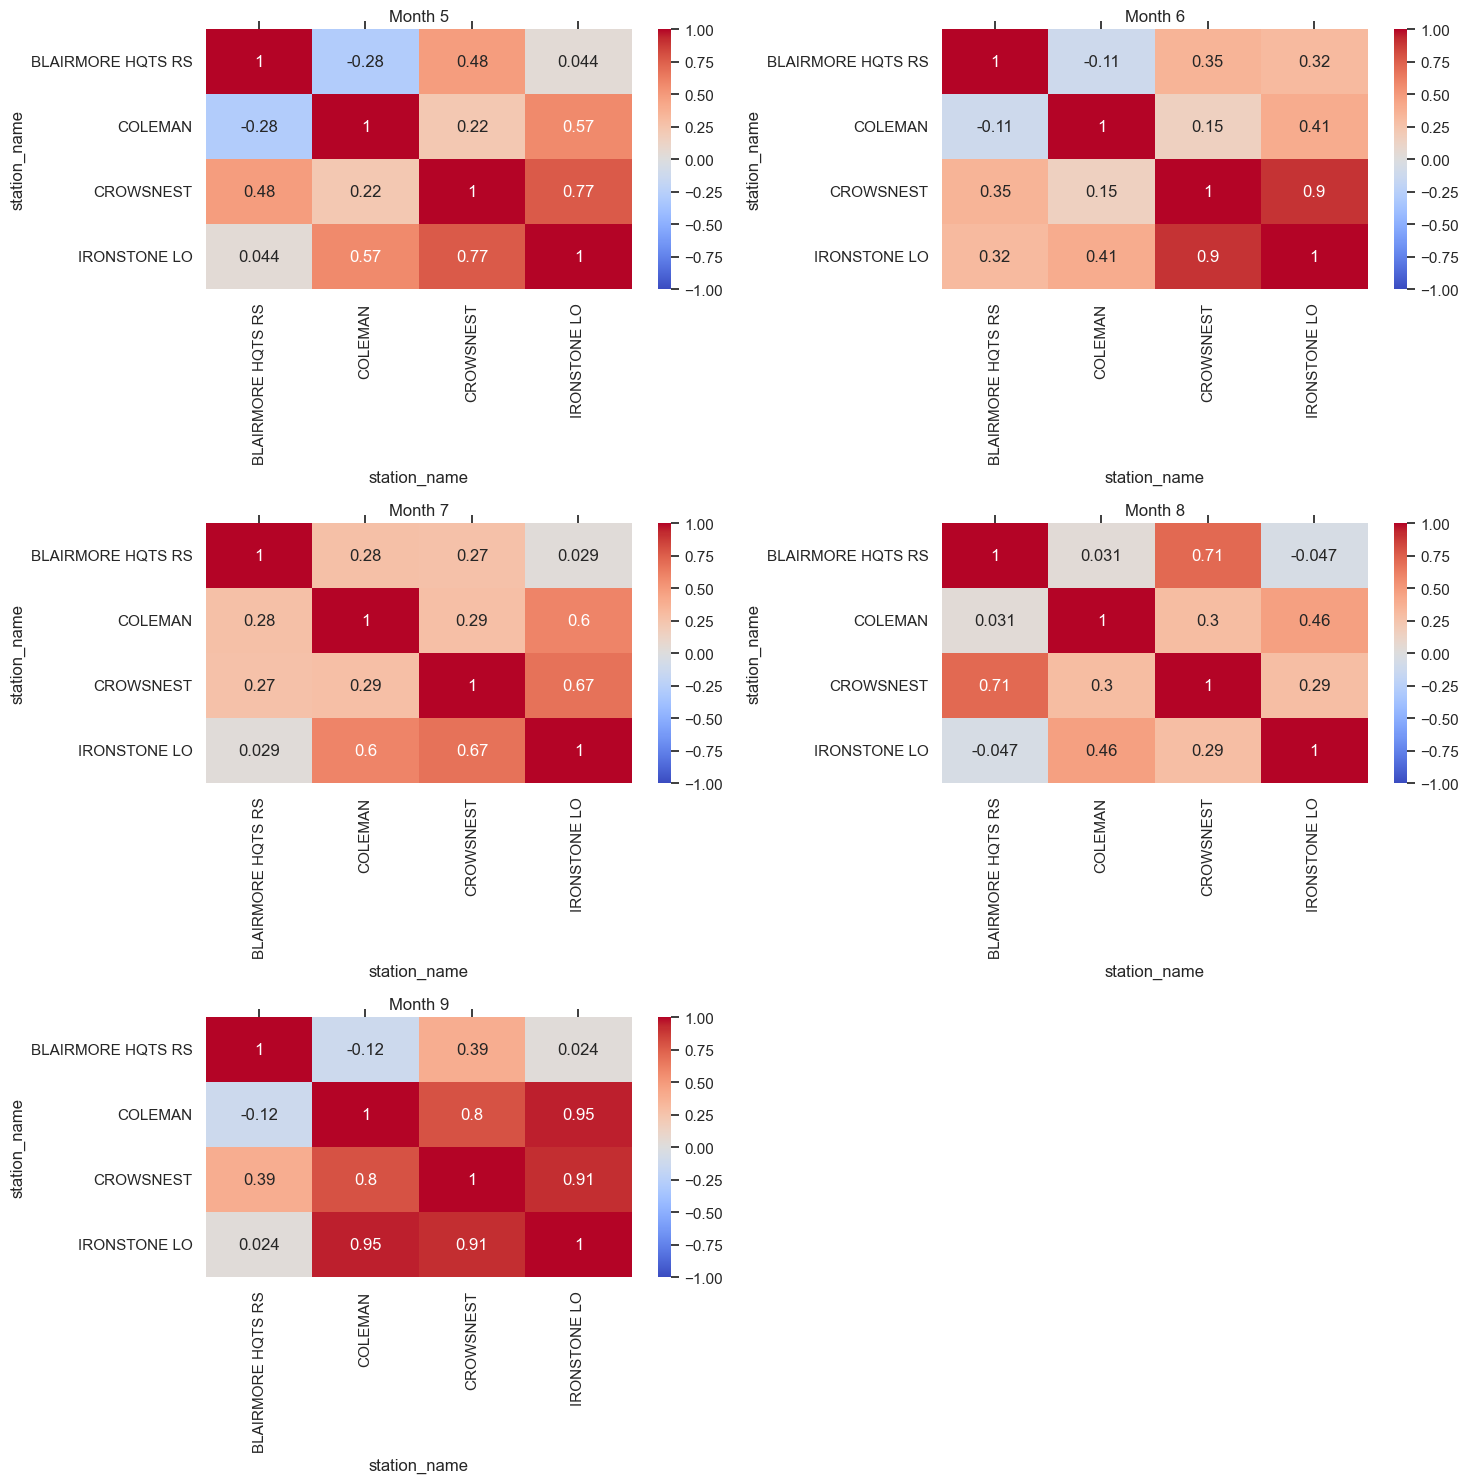

In [180]:
plot_cross_correlation_matrices(c3_monthly_dataframes)

#### Combination 4 
combo4 = ['WILLOUGHBY RIDGE', 'SPARWOOD CS', 'SPARWOOD', 'PELLETIER CREEK', 'IRONSTONE LO', 'CROWSNEST CREEK', 'CROWSNEST'] 19 count

In [181]:
summary_combo4_monthly_df = describe_dataframes_to_dataframe(c4_monthly_dataframes)
summary_combo4_monthly_df

count       mean        std   min     25%    50%     75%  \
  station_name                                                                 
5 CROWSNEST           4.0   9.300000   6.799020   1.8   5.400   8.80  12.700   
  CROWSNEST CREEK     4.0   5.900000   2.608959   2.5   4.600   6.35   7.650   
  IRONSTONE LO        4.0   8.750000   4.044338   5.0   6.500   7.80  10.050   
  PELLETIER CREEK     4.0   4.775000   2.969147   1.8   2.550   4.60   6.825   
  SPARWOOD            4.0   4.500000   4.786787   0.8   1.925   2.85   5.425   
  SPARWOOD CS         4.0   4.150000   2.137756   2.0   2.900   3.80   5.050   
  WILLOUGHBY RIDGE    4.0  13.175000  12.627054   5.1   5.475   7.90  15.600   
  month               4.0   5.000000   0.000000   5.0   5.000   5.00   5.000   
6 CROWSNEST           9.0   5.777778   5.233970   0.2   1.800   4.60   7.200   
  CROWSNEST CREEK     9.0   8.300000  11.752872   0.3   1.500   5.30   8.100   
  IRONSTONE LO        9.0   4.111111   2.559514   1.2   1.800   3.60   5.200   
  PELLETIER CREEK     9.0   5.566667   6.333443   0.8   1.500   2.30   7.400   
  SPARWOOD            9.0   5.955556   5.068311   0.2   3.500   4.80   5.600   
  SPARWOOD CS         9.0   5.911111   4.171464   0.2   3.400   5.00   8.200   
  WILLOUGHBY RIDGE    9.0   6.311111   6.726523   1.0   1.000   3.30  10.400   
  month               9.0   6.000000   0.000000   6.0   6.000   6.00   6.000   
7 CROWSNEST           1.0   0.200000        NaN   0.2   0.200   0.20   0.200   
  CROWSNEST CREEK     1.0  10.900000        NaN  10.9  10.900  10.90  10.900   
  IRONSTONE LO        1.0   6.200000        NaN   6.2   6.200   6.20   6.200   
  PELLETIER CREEK     1.0   6.600000        NaN   6.6   6.600   6.60   6.600   
  SPARWOOD            1.0   8.900000        NaN   8.9   8.900   8.90   8.900   
  SPARWOOD CS         1.0  13.000000        NaN  13.0  13.000  13.00  13.000   
  WILLOUGHBY RIDGE    1.0   9.100000        NaN   9.1   9.100   9.10   9.100   
  month               1.0   7.000000        NaN   7.0   7.000   7.00   7.000   
9 CROWSNEST           5.0   3.540000   1.984439   1.4   2.500   3.00   4.200   
  CROWSNEST CREEK     5.0   3.120000   1.406058   1.8   2.000   3.00   3.500   
  IRONSTONE LO        5.0   5.600000   3.543304   1.1   2.600   7.10   8.000   
  PELLETIER CREEK     5.0   5.060000   3.593466   2.0   2.500   3.00   7.900   
  SPARWOOD            5.0   5.360000   2.699630   2.2   3.000   5.80   7.400   
  SPARWOOD CS         5.0   4.560000   1.519210   2.8   3.800   4.20   5.200   
  WILLOUGHBY RIDGE    5.0   5.800000   2.439262   3.5   3.500   5.50   7.500   
  month               5.0   9.000000   0.000000   9.0   9.000   9.00   9.000   

                     max  
  station_name            
5 CROWSNEST         17.8  
  CROWSNEST CREEK    8.4  
  IRONSTONE LO      14.4  
  PELLETIER CREEK    8.1  
  SPARWOOD          11.5  
  SPARWOOD CS        7.0  
  WILLOUGHBY RIDGE  31.8  
  month              5.0  
6 CROWSNEST         16.4  
  CROWSNEST CREEK   38.2  
  IRONSTONE LO       9.4  
  PELLETIER CREEK   19.6  
  SPARWOOD          14.9  
  SPARWOOD CS       12.8  
  WILLOUGHBY RIDGE  19.3  
  month              6.0  
7 CROWSNEST          0.2  
  CROWSNEST CREEK   10.9  
  IRONSTONE LO       6.2  
  PELLETIER CREEK    6.6  
  SPARWOOD           8.9  
  SPARWOOD CS       13.0  
  WILLOUGHBY RIDGE   9.1  
  month              7.0  
9 CROWSNEST          6.6  
  CROWSNEST CREEK    5.3  
  IRONSTONE LO       9.2  
  PELLETIER CREEK    9.9  
  SPARWOOD           8.4  
  SPARWOOD CS        6.8  
  WILLOUGHBY RIDGE   9.0  
  month              9.0

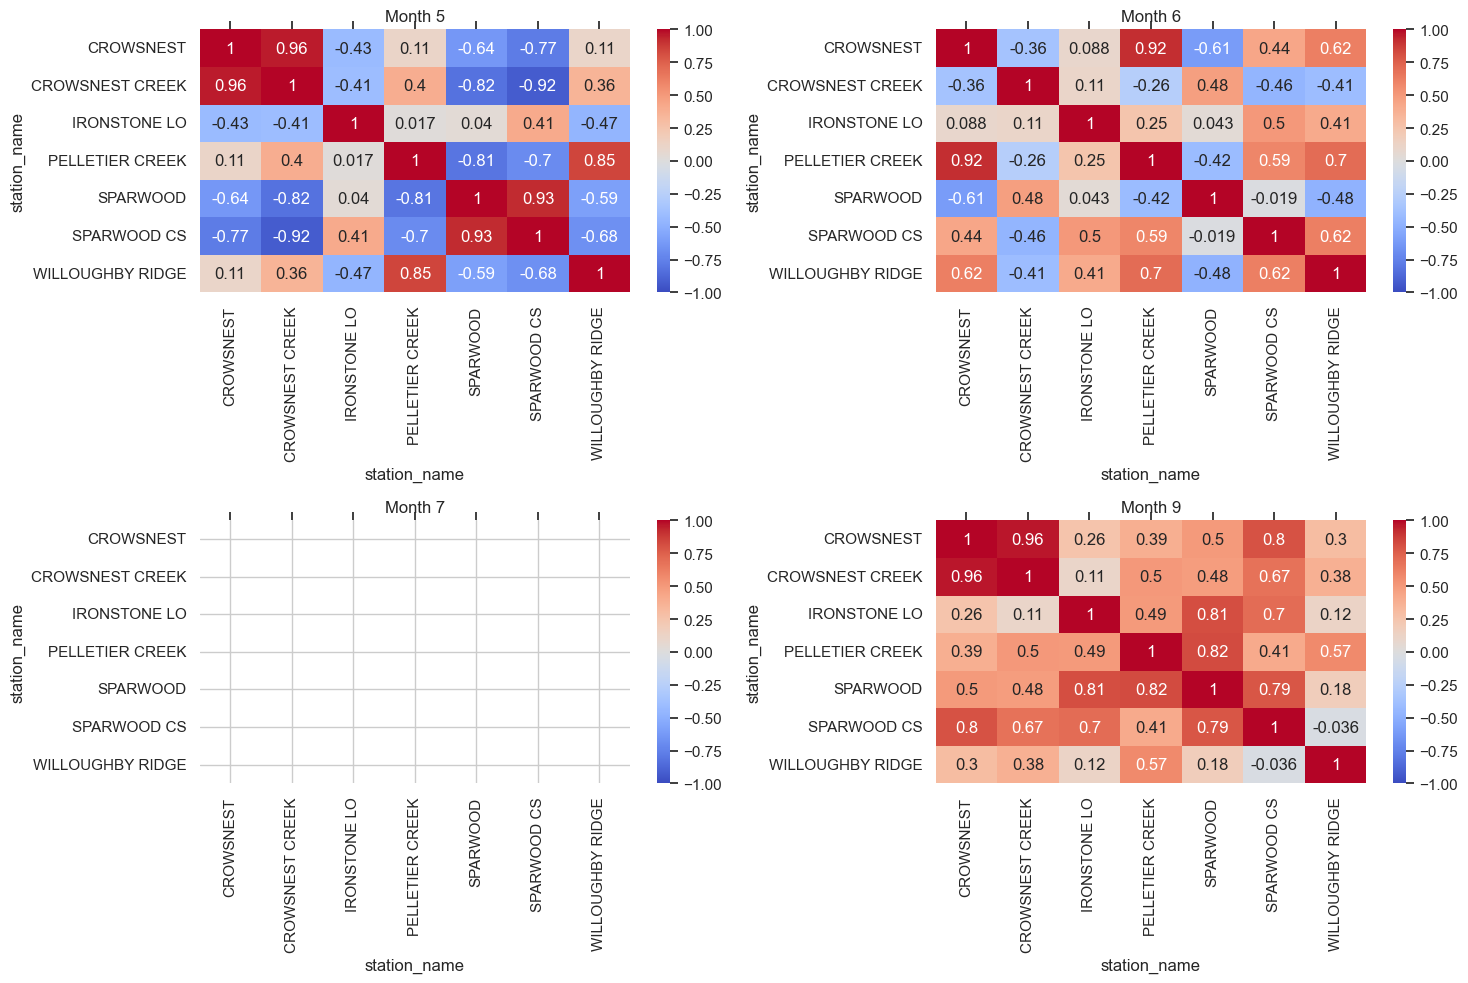

In [182]:
plot_cross_correlation_matrices(c4_monthly_dataframes)

#### Combination 5 
combo5 = ['COLEMAN', 'BLAIRMORE HQTS RS'] 1481 count

In [183]:
summary_combo5_monthly_df = describe_dataframes_to_dataframe(c5_monthly_dataframes)
summary_combo5_monthly_df

count       mean        std   min   25%    50%     75%  \
   station_name                                                                
1  BLAIRMORE HQTS RS   38.0   8.236842   5.855901   0.6   3.2   8.40  11.950   
   COLEMAN             38.0   6.952632   6.434356   0.3   2.0   5.15   7.875   
   month               38.0   1.000000   0.000000   1.0   1.0   1.00   1.000   
2  BLAIRMORE HQTS RS   61.0   8.786885   9.852706   0.6   3.0   5.40  11.000   
   COLEMAN             61.0   5.955738   7.744558   0.2   1.2   3.00   7.000   
   month               61.0   2.000000   0.000000   2.0   2.0   2.00   2.000   
3  BLAIRMORE HQTS RS   57.0   5.657895   3.867629   0.8   2.8   4.80   7.200   
   COLEMAN             57.0   3.970175   3.317484   0.3   1.6   2.80   5.000   
   month               57.0   3.000000   0.000000   3.0   3.0   3.00   3.000   
4  BLAIRMORE HQTS RS  111.0   4.820721   6.420395   0.2   1.0   2.60   6.000   
   COLEMAN            111.0   4.223423   4.342139   0.2   1.1   2.70   5.400   
   month              111.0   4.000000   0.000000   4.0   4.0   4.00   4.000   
5  BLAIRMORE HQTS RS  226.0   6.357080   8.370799   0.2   1.2   3.05   7.900   
   COLEMAN            226.0   5.118142   5.842996   0.2   1.0   3.00   6.275   
   month              226.0   5.000000   0.000000   5.0   5.0   5.00   5.000   
6  BLAIRMORE HQTS RS  197.0   6.457360  10.944969   0.2   1.2   3.00   6.400   
   COLEMAN            197.0   5.324365   6.053875   0.2   1.3   2.80   7.200   
   month              197.0   6.000000   0.000000   6.0   6.0   6.00   6.000   
7  BLAIRMORE HQTS RS  176.0   7.140909   8.646798   0.2   1.8   4.20   9.200   
   COLEMAN            176.0   6.159659   7.058127   0.2   1.6   3.60   7.800   
   month              176.0   7.000000   0.000000   7.0   7.0   7.00   7.000   
8  BLAIRMORE HQTS RS  184.0   6.343478   8.203116   0.2   1.0   3.20   7.450   
   COLEMAN            184.0   5.203261   7.375087   0.2   1.0   3.00   5.600   
   month              184.0   8.000000   0.000000   8.0   8.0   8.00   8.000   
9  BLAIRMORE HQTS RS  176.0   5.329545   6.812823   0.2   1.0   2.65   7.450   
   COLEMAN            176.0   4.560795   6.000371   0.2   0.8   2.35   5.650   
   month              176.0   9.000000   0.000000   9.0   9.0   9.00   9.000   
10 BLAIRMORE HQTS RS   97.0   5.797938   5.726946   0.2   1.6   4.00   7.200   
   COLEMAN             97.0   5.459794   6.302193   0.2   1.5   3.00   6.600   
   month               97.0  10.000000   0.000000  10.0  10.0  10.00  10.000   
11 BLAIRMORE HQTS RS   79.0   7.674684   7.856803   0.5   2.6   4.20   9.500   
   COLEMAN             79.0   7.360759   9.754452   0.2   2.0   4.00   8.050   
   month               79.0  11.000000   0.000000  11.0  11.0  11.00  11.000   
12 BLAIRMORE HQTS RS   79.0   6.865823   8.502607   0.2   2.6   3.80   8.500   
   COLEMAN             79.0   5.473418   5.666177   0.2   2.0   3.20   7.000   
   month               79.0  12.000000   0.000000  12.0  12.0  12.00  12.000   

                       max  
   station_name             
1  BLAIRMORE HQTS RS  26.4  
   COLEMAN            24.3  
   month               1.0  
2  BLAIRMORE HQTS RS  48.8  
   COLEMAN            39.0  
   month               2.0  
3  BLAIRMORE HQTS RS  16.0  
   COLEMAN            13.8  
   month               3.0  
4  BLAIRMORE HQTS RS  42.6  
   COLEMAN            21.8  
   month               4.0  
5  BLAIRMORE HQTS RS  53.8  
   COLEMAN            29.0  
   month               5.0  
6  BLAIRMORE HQTS RS  79.0  
   COLEMAN            35.6  
   month               6.0  
7  BLAIRMORE HQTS RS  58.0  
   COLEMAN            37.4  
   month               7.0  
8  BLAIRMORE HQTS RS  54.4  
   COLEMAN            63.0  
   month               8.0  
9  BLAIRMORE HQTS RS  44.2  
   COLEMAN            38.1  
   month               9.0  
10 BLAIRMORE HQTS RS  25.2  
   COLEMAN            31.4  
   month              10.0  
11 BLAIRMORE HQTS RS  30.8  
   COLEMAN            53

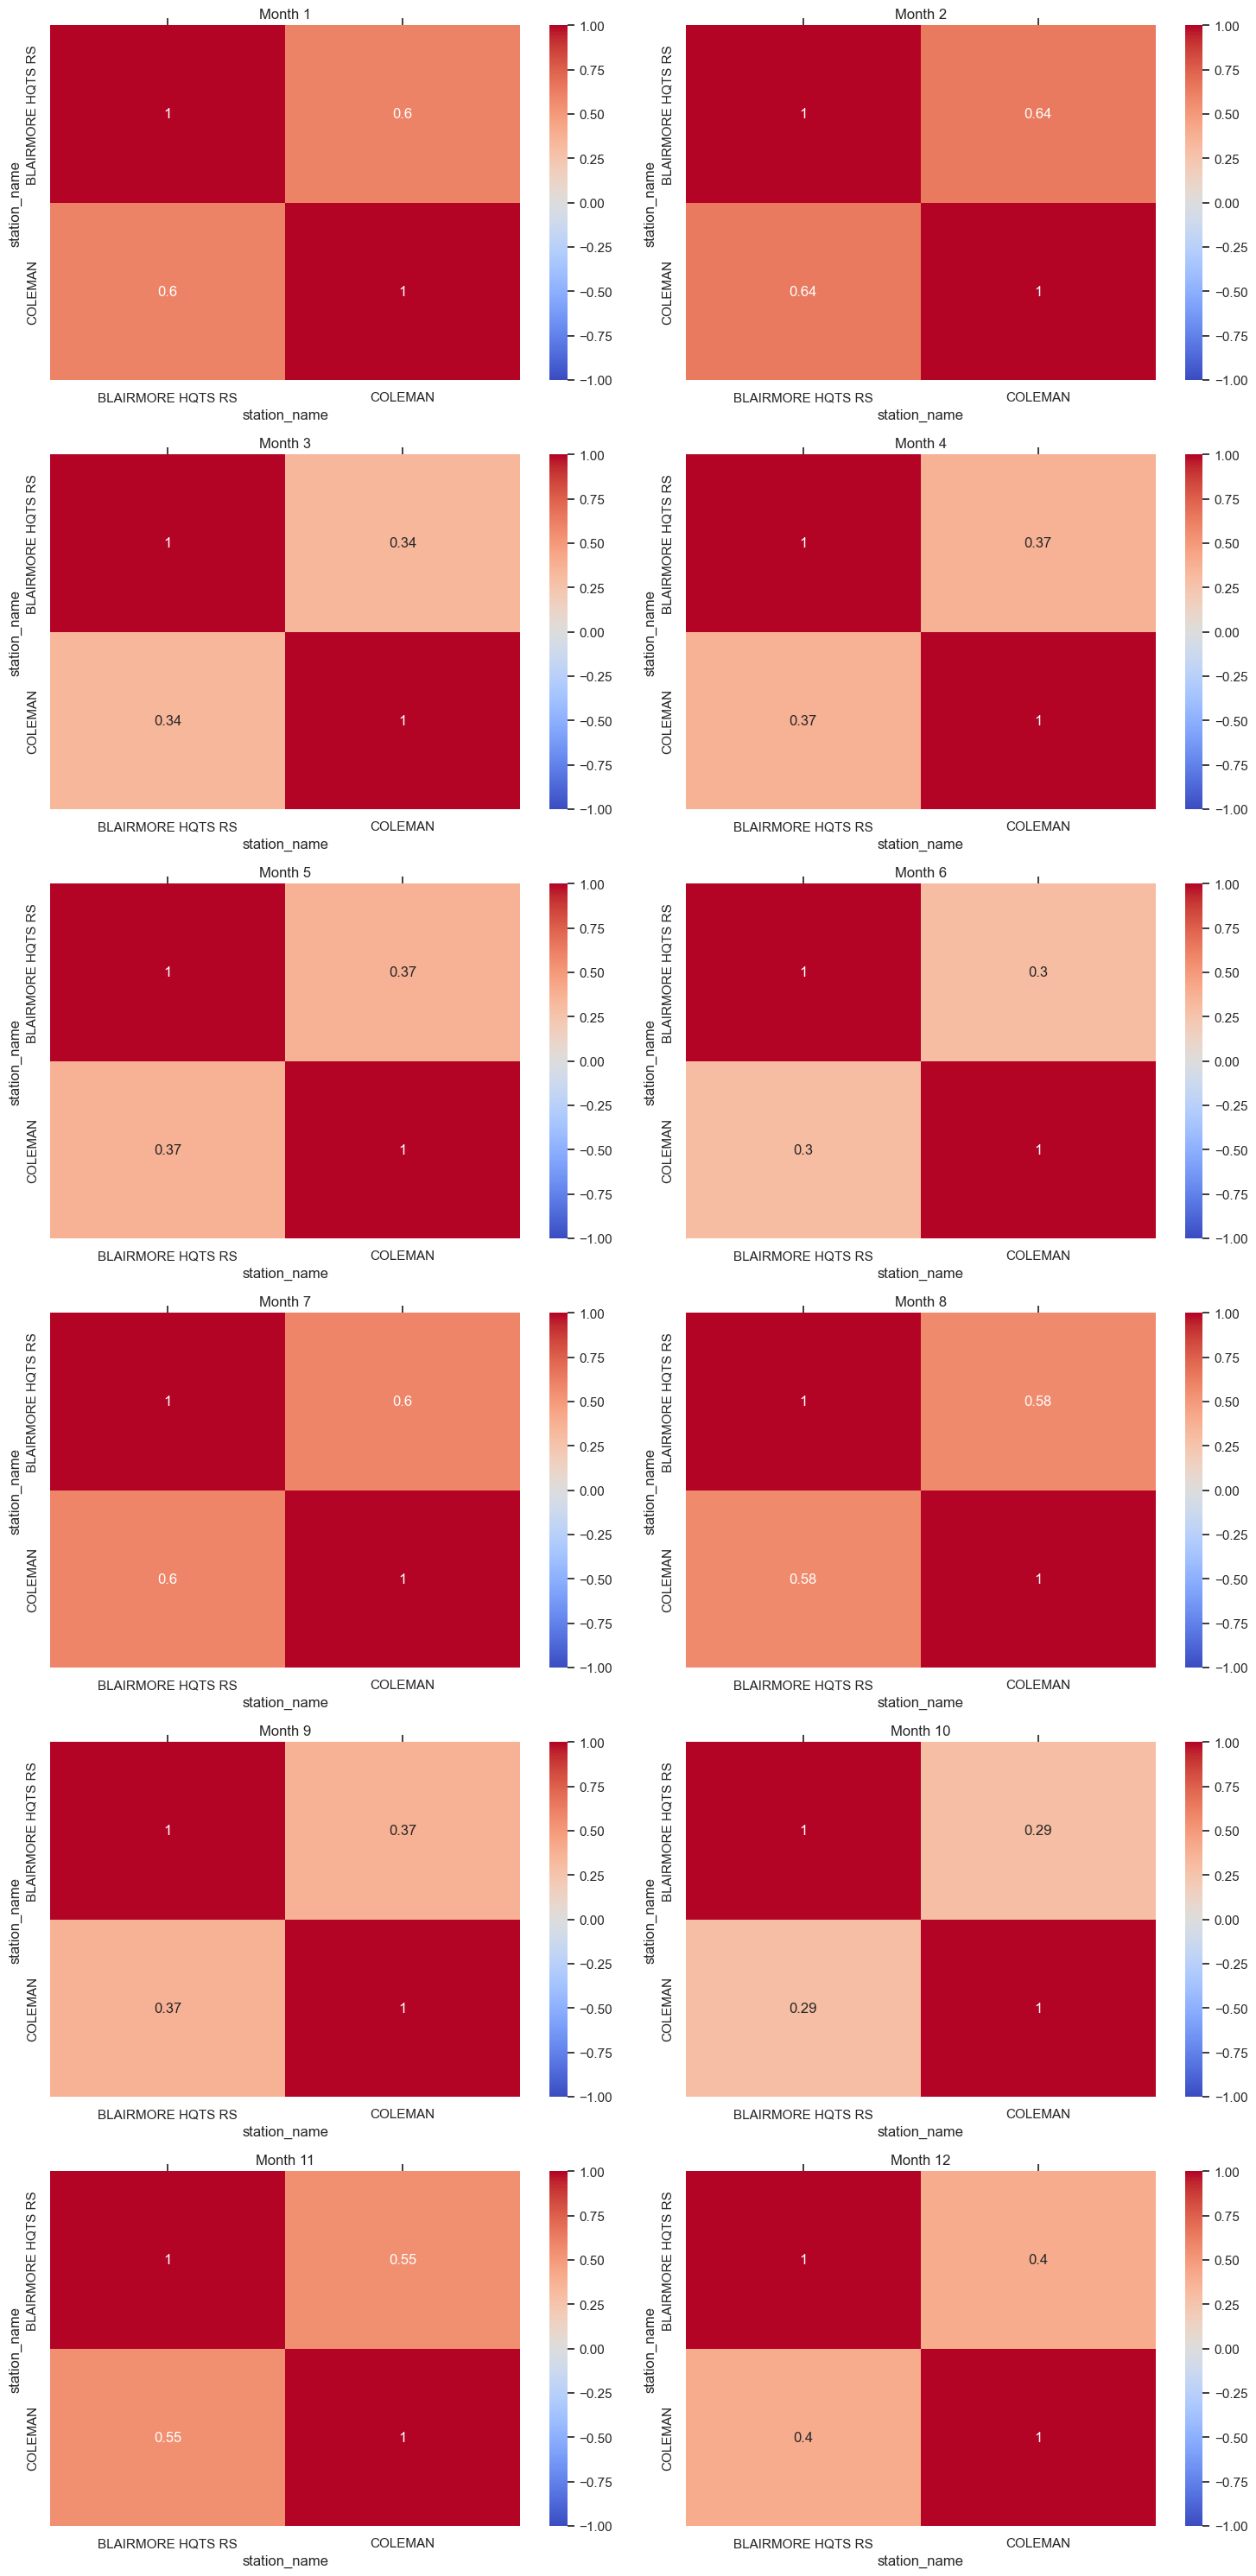

In [184]:
plot_cross_correlation_matrices(c5_monthly_dataframes)

#### Combination 6
combo6 = ['COLEMAN', 'IRONSTONE LO'] 1468 count

In [185]:
summary_combo6_monthly_df = describe_dataframes_to_dataframe(c6_monthly_dataframes)
summary_combo6_monthly_df


count       mean       std   min     25%    50%     75%   max
   station_name                                                               
4  COLEMAN         5.0   3.600000  3.203123   0.6   2.400   2.40   3.600   9.0
   IRONSTONE LO    5.0   4.960000  5.326631   1.9   2.200   2.50   3.800  14.4
   month           5.0   4.000000  0.000000   4.0   4.000   4.00   4.000   4.0
5  COLEMAN       233.0   5.609871  6.524043   0.2   1.200   3.20   7.200  39.4
   IRONSTONE LO  233.0   7.553219  9.894752   0.2   1.700   4.20  10.800  75.8
   month         233.0   5.000000  0.000000   5.0   5.000   5.00   5.000   5.0
6  COLEMAN       386.0   6.140415  7.182788   0.2   1.400   3.55   8.000  52.3
   IRONSTONE LO  386.0   7.073316  9.054613   0.2   1.500   3.80   8.400  63.0
   month         386.0   6.000000  0.000000   6.0   6.000   6.00   6.000   6.0
7  COLEMAN       281.0   6.137367  6.563132   0.2   1.800   4.10   7.600  37.4
   IRONSTONE LO  281.0   6.249466  7.861525   0.2   1.400   3.50   7.900  62.4
   month         281.0   7.000000  0.000000   7.0   7.000   7.00   7.000   7.0
8  COLEMAN       280.0   5.405357  6.965188   0.2   1.375   3.15   6.200  63.0
   IRONSTONE LO  280.0   5.988571  7.030029   0.2   1.475   3.80   7.325  49.7
   month         280.0   8.000000  0.000000   8.0   8.000   8.00   8.000   8.0
9  COLEMAN       230.0   5.285652  5.766127   0.2   1.300   3.00   7.500  38.1
   IRONSTONE LO  230.0   6.218261  6.561521   0.2   1.425   3.80   8.100  34.7
   month         230.0   9.000000  0.000000   9.0   9.000   9.00   9.000   9.0
10 COLEMAN        50.0   5.114000  4.960497   0.5   2.300   3.60   5.975  25.2
   IRONSTONE LO   50.0   7.148000  7.814592   0.6   1.825   4.80   8.900  40.6
   month          50.0  10.000000  0.000000  10.0  10.000  10.00  10.000  10.0
11 COLEMAN         3.0   6.166667  4.619885   1.0   4.300   7.60   8.750   9.9
   IRONSTONE LO    3.0   7.033333  2.977135   3.6   6.100   8.60   8.750   8.9
   month           3.0  11.000000  0.000000  11.0  11.000  11.00  11.000  11.0

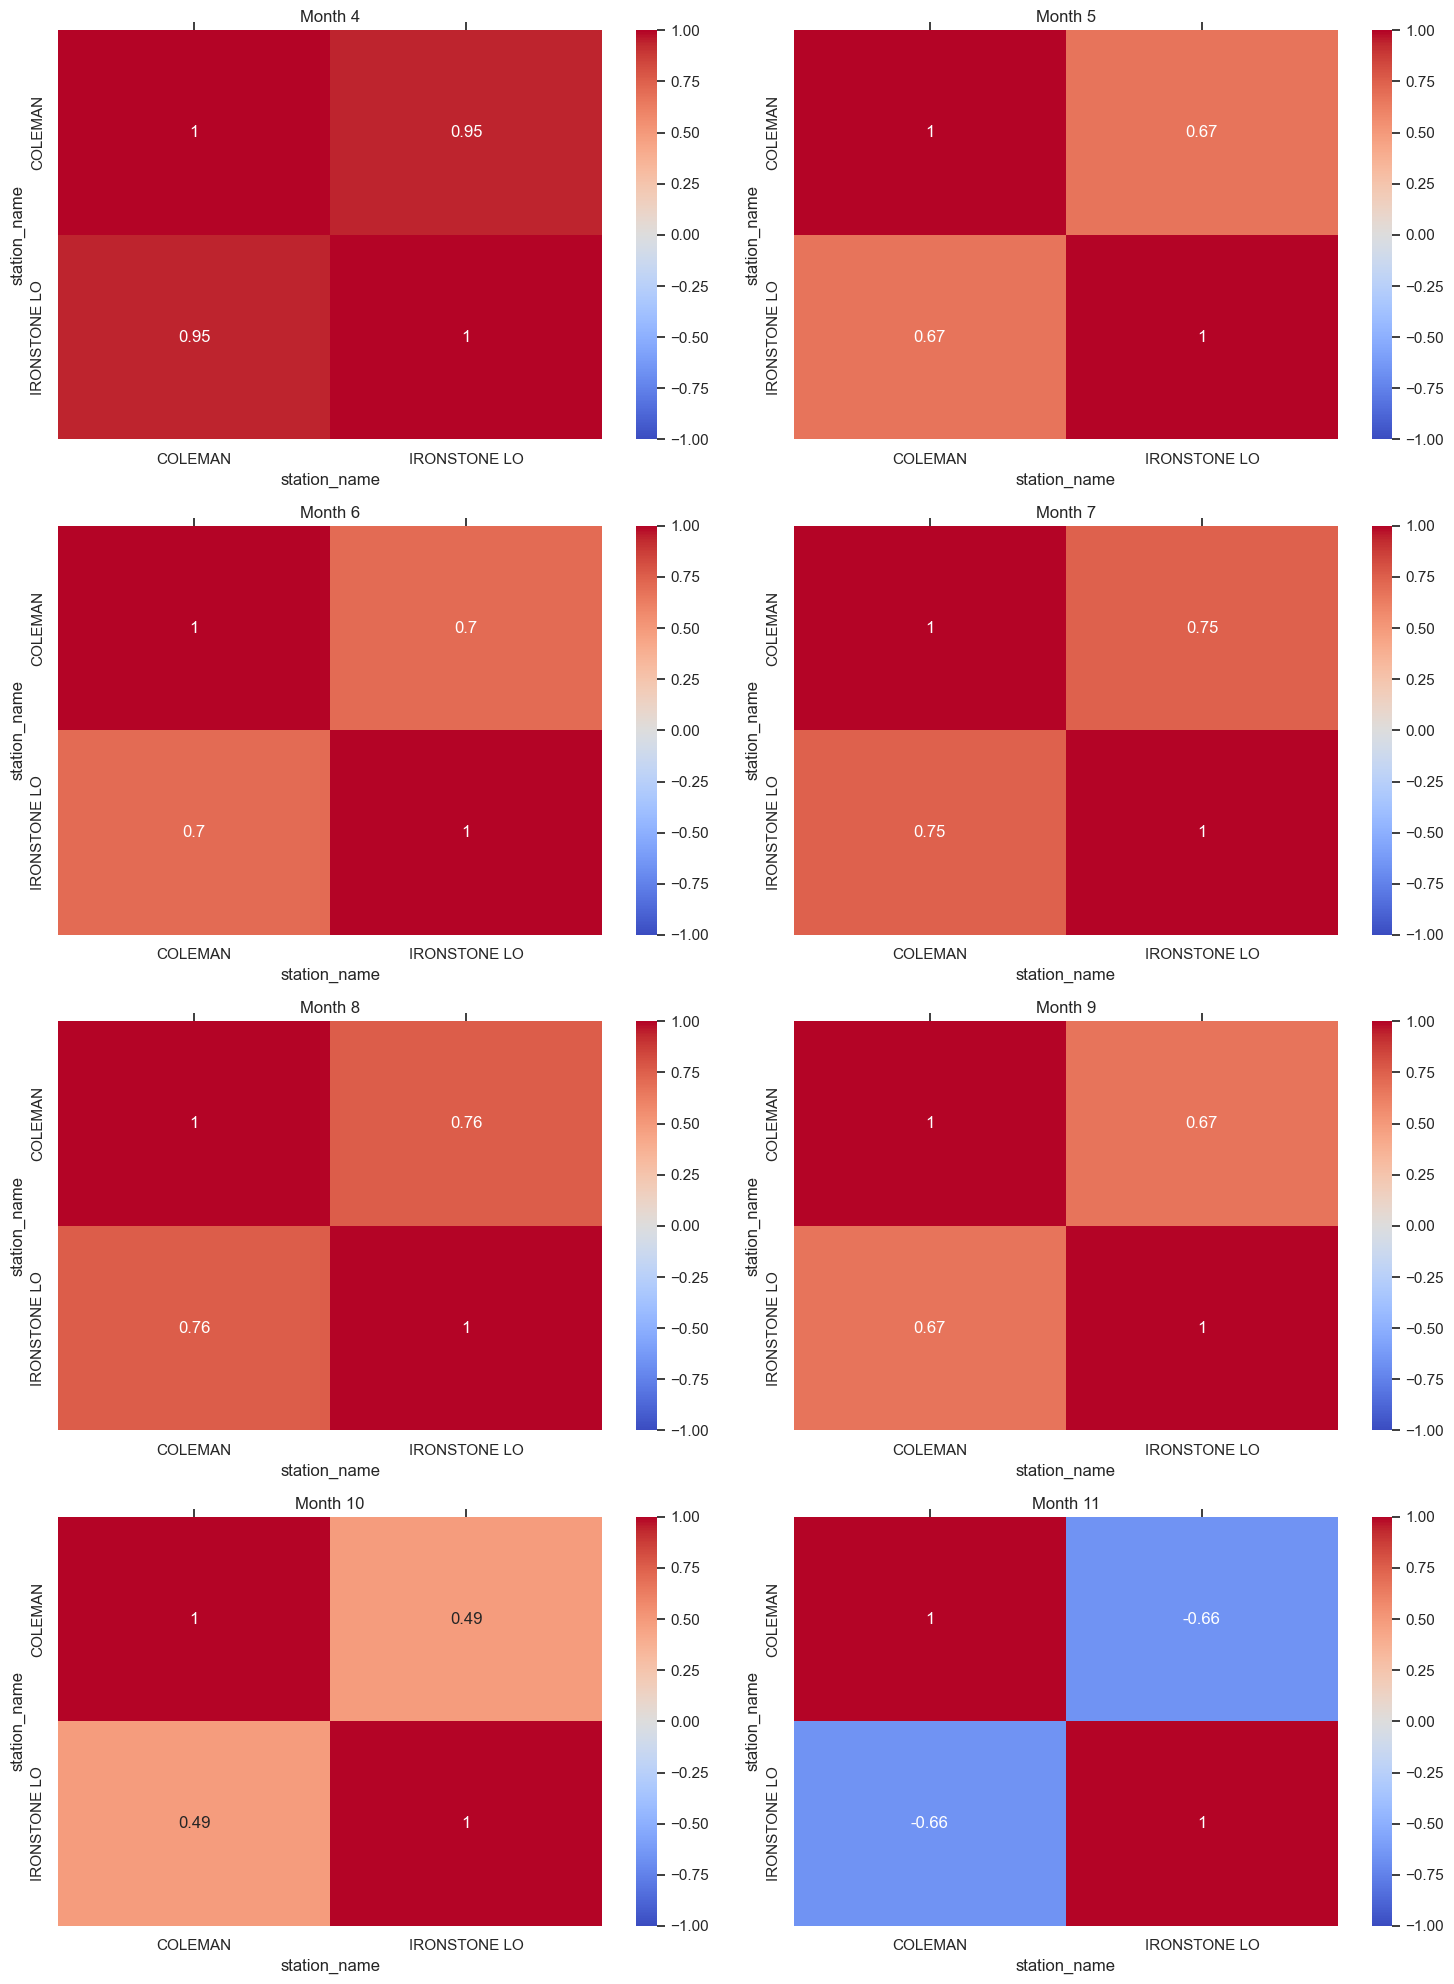

In [186]:
plot_cross_correlation_matrices(c6_monthly_dataframes)

#### Combination 7
combo7 = ['IRONSTONE LO', 'CROWSNEST'] 468 count

In [187]:
summary_combo7_monthly_df = describe_dataframes_to_dataframe(c7_monthly_dataframes)
summary_combo7_monthly_df

count      mean        std  min    25%  50%    75%   max
  station_name                                                          
5 CROWSNEST      50.0  6.548000   6.849616  0.2  1.650  4.4  8.600  34.4
  IRONSTONE LO   50.0  5.774000   4.723316  0.2  1.275  5.0  8.200  18.3
  month          50.0  5.000000   0.000000  5.0  5.000  5.0  5.000   5.0
6 CROWSNEST     178.0  6.206742  10.686195  0.2  0.800  2.4  7.350  97.6
  IRONSTONE LO  178.0  6.732584  10.139694  0.2  1.200  3.4  8.075  69.0
  month         178.0  6.000000   0.000000  6.0  6.000  6.0  6.000   6.0
7 CROWSNEST      82.0  5.197561   7.306381  0.2  0.800  3.0  6.200  46.0
  IRONSTONE LO   82.0  5.651220   7.708777  0.2  1.400  2.9  7.275  44.8
  month          82.0  7.000000   0.000000  7.0  7.000  7.0  7.000   7.0
8 CROWSNEST      90.0  4.484444   5.599918  0.2  1.000  2.0  6.000  31.0
  IRONSTONE LO   90.0  4.963333   5.729158  0.2  1.050  3.8  6.600  31.2
  month          90.0  8.000000   0.000000  8.0  8.000  8.0  8.000   8.0
9 CROWSNEST      68.0  4.773529   6.603902  0.2  0.400  2.1  6.650  32.0
  IRONSTONE LO   68.0  4.148529   4.712368  0.2  1.100  2.4  5.375  21.4
  month          68.0  9.000000   0.000000  9.0  9.000  9.0  9.000   9.0

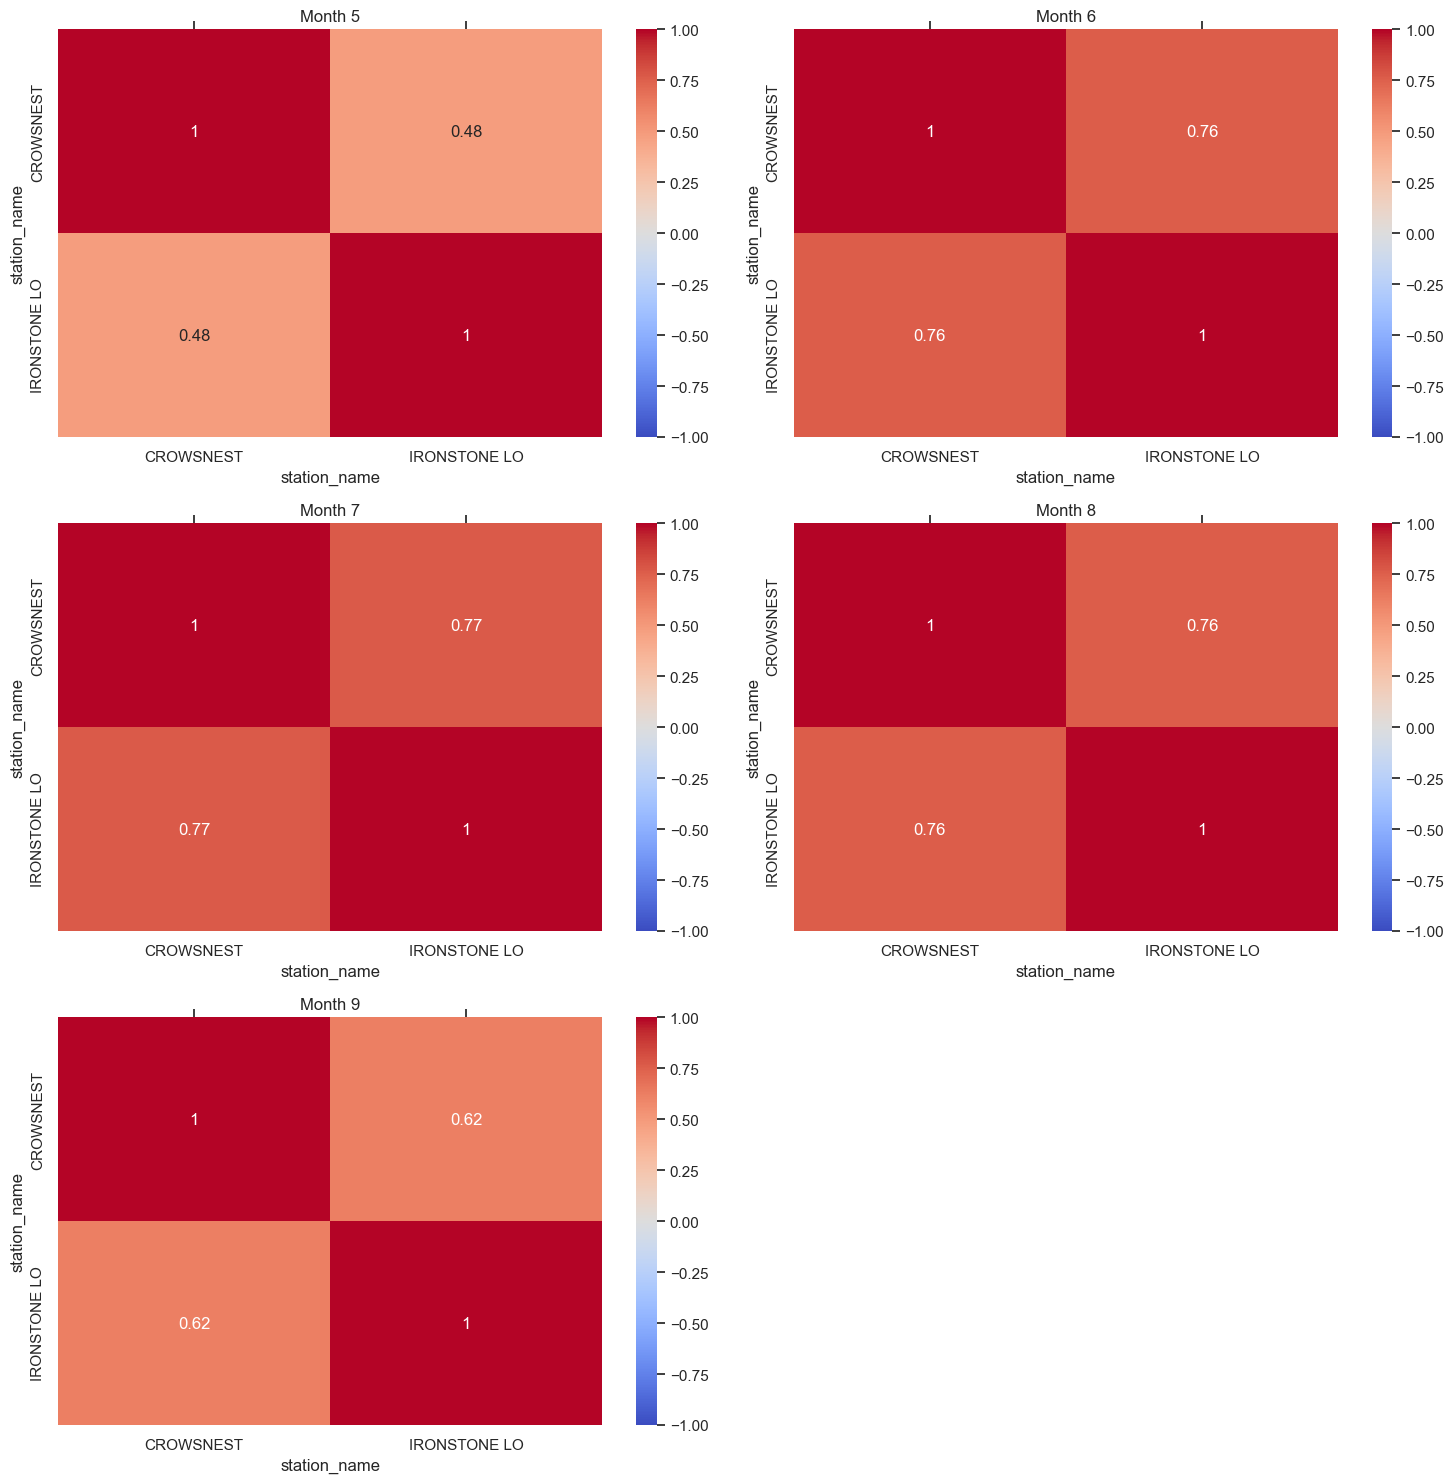

In [188]:
plot_cross_correlation_matrices(c7_monthly_dataframes)

#### Combination 8
combo8 = ['IRONSTONE LO', 'NATAL HARMER RIDGE'] 672 count

In [189]:
summary_combo8_monthly_df = describe_dataframes_to_dataframe(c8_monthly_dataframes)
summary_combo8_monthly_df

count       mean        std   min     25%    50%  \
   station_name                                                           
4  IRONSTONE LO          2.0   8.150000   8.838835   1.9   5.025   8.15   
   NATAL HARMER RIDGE    2.0   8.000000   9.899495   1.0   4.500   8.00   
   month                 2.0   4.000000   0.000000   4.0   4.000   4.00   
5  IRONSTONE LO        117.0   8.271795  10.210017   0.3   2.200   4.80   
   NATAL HARMER RIDGE  117.0   5.569231   5.156791   0.2   1.800   4.00   
   month               117.0   5.000000   0.000000   5.0   5.000   5.00   
6  IRONSTONE LO        158.0   5.992405   8.097554   0.2   1.200   3.00   
   NATAL HARMER RIDGE  158.0   5.188608   5.080761   0.2   1.500   3.30   
   month               158.0   6.000000   0.000000   6.0   6.000   6.00   
7  IRONSTONE LO        132.0   6.091667   8.531871   0.2   1.375   3.15   
   NATAL HARMER RIDGE  132.0   6.790152   6.484013   0.2   2.375   4.30   
   month               132.0   7.000000   0.000000   7.0   7.000   7.00   
8  IRONSTONE LO        143.0   6.605594   8.075810   0.3   1.550   3.80   
   NATAL HARMER RIDGE  143.0   6.123776   7.102885   0.2   2.000   4.00   
   month               143.0   8.000000   0.000000   8.0   8.000   8.00   
9  IRONSTONE LO         99.0   7.019192   7.361062   0.2   1.550   4.70   
   NATAL HARMER RIDGE   99.0   6.094949   5.712649   0.2   2.500   4.20   
   month                99.0   9.000000   0.000000   9.0   9.000   9.00   
10 IRONSTONE LO         21.0   6.471429   7.647493   0.3   2.000   2.80   
   NATAL HARMER RIDGE   21.0   6.000000   7.159050   0.5   1.500   3.00   
   month                21.0  10.000000   0.000000  10.0  10.000  10.00   

                          75%   max  
   station_name                      
4  IRONSTONE LO        11.275  14.4  
   NATAL HARMER RIDGE  11.500  15.0  
   month                4.000   4.0  
5  IRONSTONE LO        11.200  70.6  
   NATAL HARMER RIDGE   8.600  25.0  
   month                5.000   5.0  
6  IRONSTONE LO         7.175  52.0  
   NATAL HARMER RIDGE   7.400  25.0  
   month                6.000   6.0  
7  IRONSTONE LO         7.175  62.4  
   NATAL HARMER RIDGE   9.425  34.6  
   month                7.000   7.0  
8  IRONSTONE LO         7.900  49.7  
   NATAL HARMER RIDGE   8.000  53.3  
   month                8.000   8.0  
9  IRONSTONE LO        10.100  34.7  
   NATAL HARMER RIDGE   7.400  34.8  
   month                9.000   9.0  
10 IRONSTONE LO         7.600  25.4  
   NATAL HARMER RIDGE   8.400  24.0  
   month               10.000  10.0

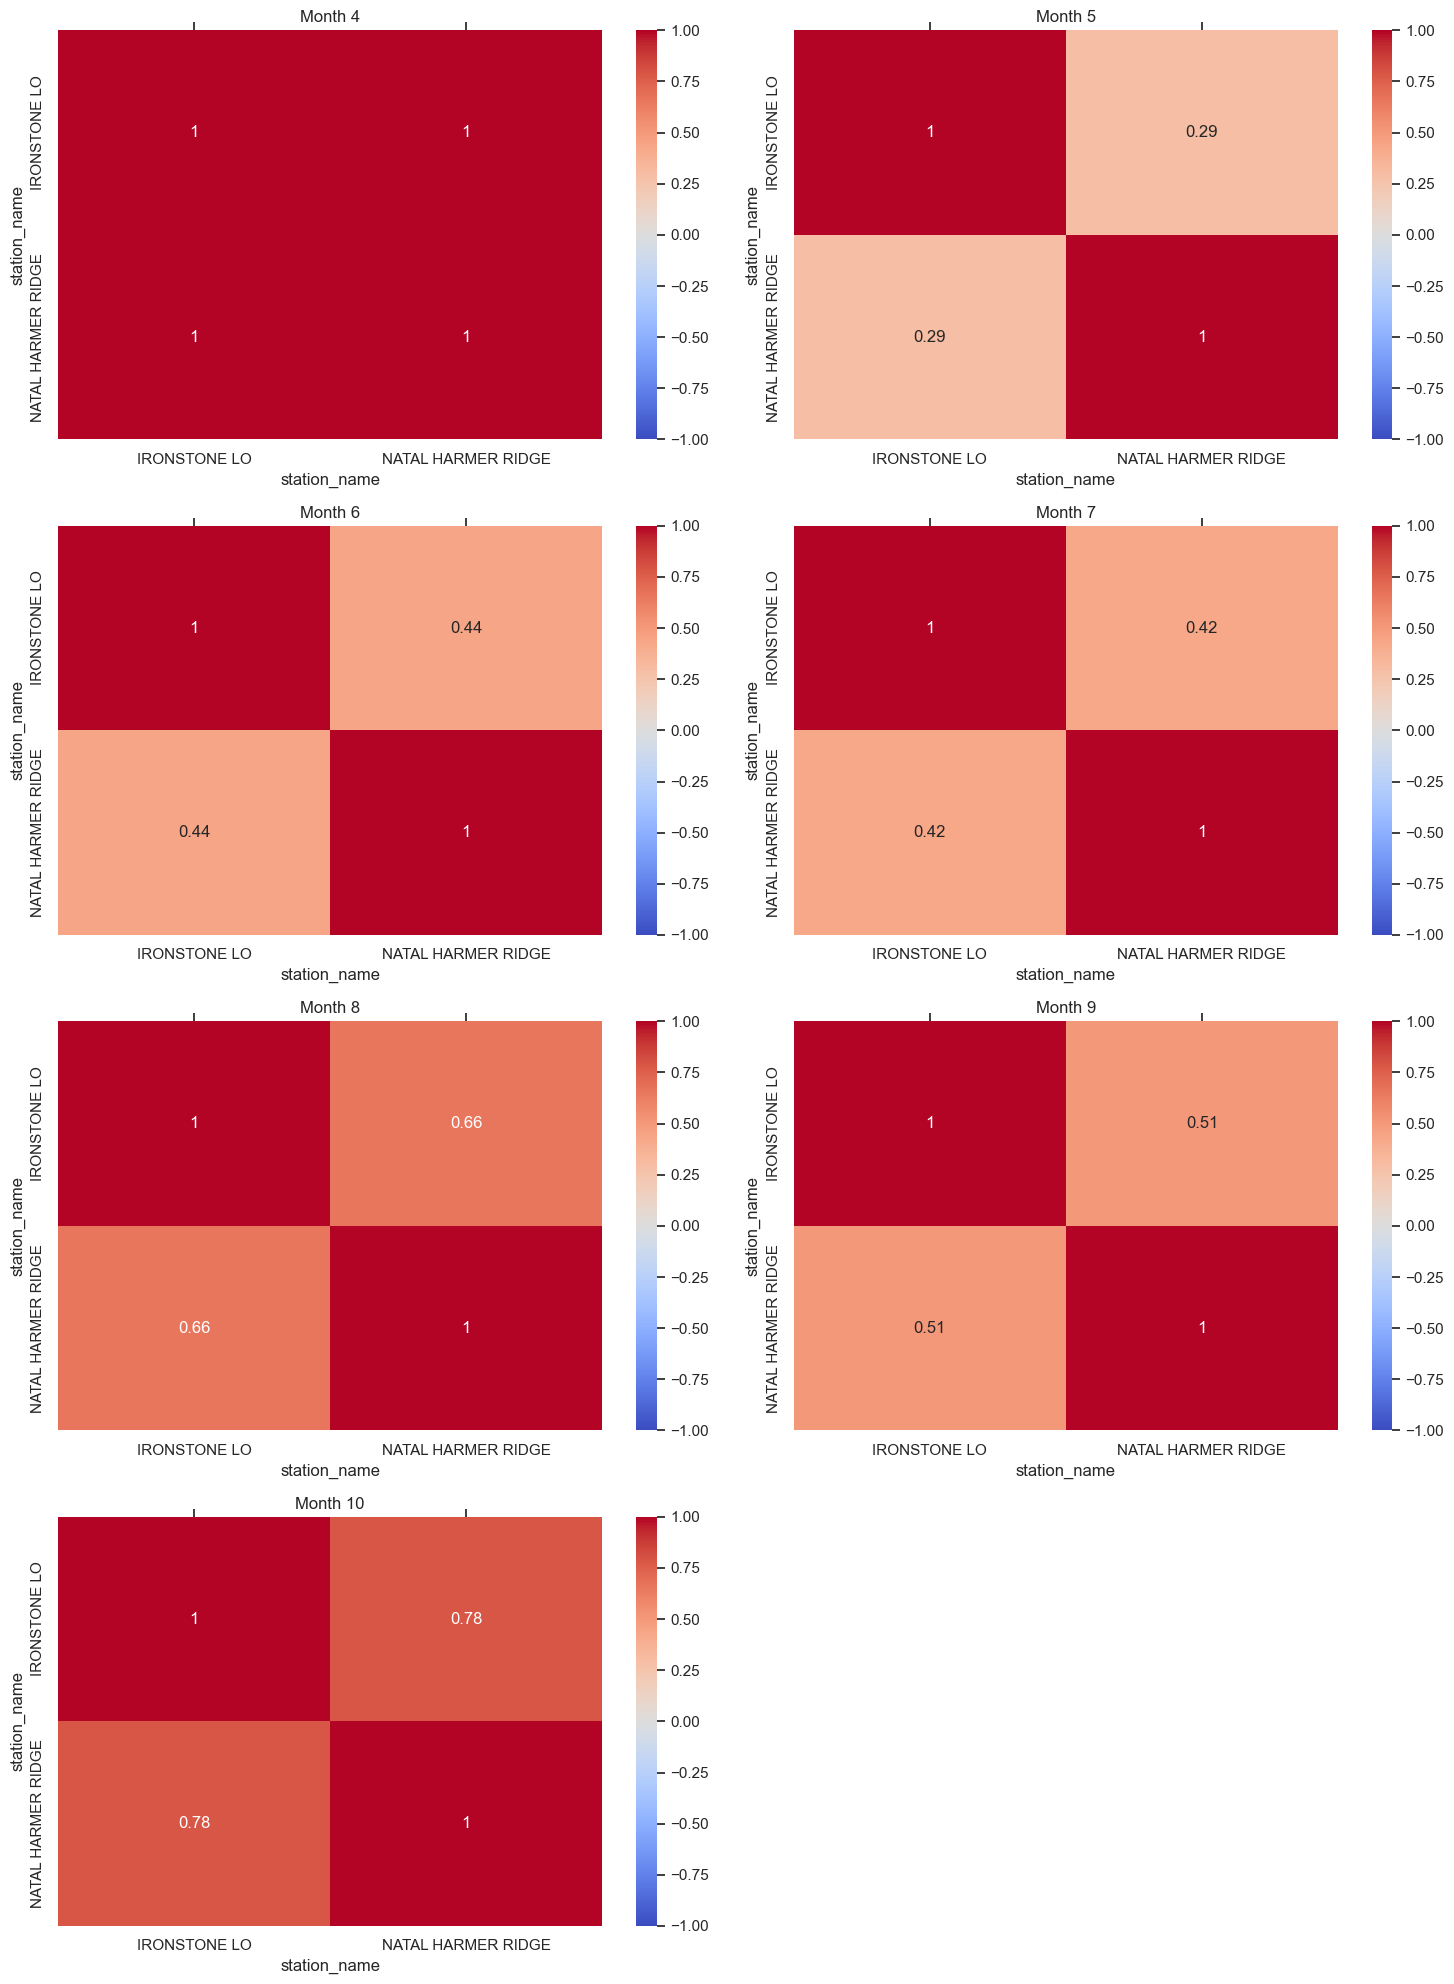

In [190]:
plot_cross_correlation_matrices(c8_monthly_dataframes)

#### Combination 9
combo9 = ['SPARWOOD CS', 'SPARWOOD'] 1233 count

In [191]:
summary_combo9_monthly_df = describe_dataframes_to_dataframe(c9_monthly_dataframes)
summary_combo9_monthly_df


count       mean       std   min   25%   50%   75%   max
   station_name                                                          
1  SPARWOOD        1.0   1.400000       NaN   1.4   1.4   1.4   1.4   1.4
   SPARWOOD CS     1.0   4.800000       NaN   4.8   4.8   4.8   4.8   4.8
   month           1.0   1.000000       NaN   1.0   1.0   1.0   1.0   1.0
2  SPARWOOD        1.0  14.200000       NaN  14.2  14.2  14.2  14.2  14.2
   SPARWOOD CS     1.0   4.400000       NaN   4.4   4.4   4.4   4.4   4.4
   month           1.0   2.000000       NaN   2.0   2.0   2.0   2.0   2.0
3  SPARWOOD        3.0   1.733333  0.808290   1.0   1.3   1.6   2.1   2.6
   SPARWOOD CS     3.0   1.333333  1.006645   0.4   0.8   1.2   1.8   2.4
   month           3.0   3.000000  0.000000   3.0   3.0   3.0   3.0   3.0
4  SPARWOOD      156.0   2.980769  3.753727   0.1   0.8   1.6   3.6  27.1
   SPARWOOD CS   156.0   2.975641  3.424906   0.2   0.6   1.6   3.6  15.2
   month         156.0   4.000000  0.000000   4.0   4.0   4.0   4.0   4.0
5  SPARWOOD      221.0   4.357466  5.412570   0.2   1.0   2.4   5.6  31.7
   SPARWOOD CS   221.0   4.253394  5.334140   0.1   1.0   2.4   6.0  37.8
   month         221.0   5.000000  0.000000   5.0   5.0   5.0   5.0   5.0
6  SPARWOOD      269.0   4.920074  7.722499   0.2   0.9   2.2   5.6  81.8
   SPARWOOD CS   269.0   5.006320  7.656155   0.1   1.0   2.4   6.4  63.0
   month         269.0   6.000000  0.000000   6.0   6.0   6.0   6.0   6.0
7  SPARWOOD      167.0   3.850898  3.908854   0.2   0.8   2.4   5.7  17.4
   SPARWOOD CS   167.0   3.873054  4.344106   0.1   0.8   2.4   5.6  29.2
   month         167.0   7.000000  0.000000   7.0   7.0   7.0   7.0   7.0
8  SPARWOOD      109.0   4.264220  4.317010   0.2   1.0   2.8   5.4  22.1
   SPARWOOD CS   109.0   3.781651  3.608097   0.2   1.2   2.2   5.6  16.8
   month         109.0   8.000000  0.000000   8.0   8.0   8.0   8.0   8.0
9  SPARWOOD      113.0   5.675221  8.253338   0.2   1.2   3.0   6.4  60.2
   SPARWOOD CS   113.0   4.780531  5.393512   0.2   1.0   3.2   5.8  30.8
   month         113.0   9.000000  0.000000   9.0   9.0   9.0   9.0   9.0
10 SPARWOOD      177.0   4.789831  5.880380   0.2   1.0   2.9   6.1  33.5
   SPARWOOD CS   177.0   4.492655  5.678588   0.2   0.6   2.6   5.8  31.4
   month         177.0  10.000000  0.000000  10.0  10.0  10.0  10.0  10.0
11 SPARWOOD       15.0   5.113333  4.880701   0.4   1.0   2.6   9.7  13.6
   SPARWOOD CS    15.0   5.213333  5.372133   0.2   1.7   3.4   7.4  19.8
   month          15.0  11.000000  0.000000  11.0  11.0  11.0  11.0  11.0
12 SPARWOOD        1.0   2.400000       NaN   2.4   2.4   2.4   2.4   2.4
   SPARWOOD CS     1.0   0.200000       NaN   0.2   0.2   0.2   0.2   0.2
   month           1.0  12.000000       NaN  12.0  12.0  12.0  12.0  12.0

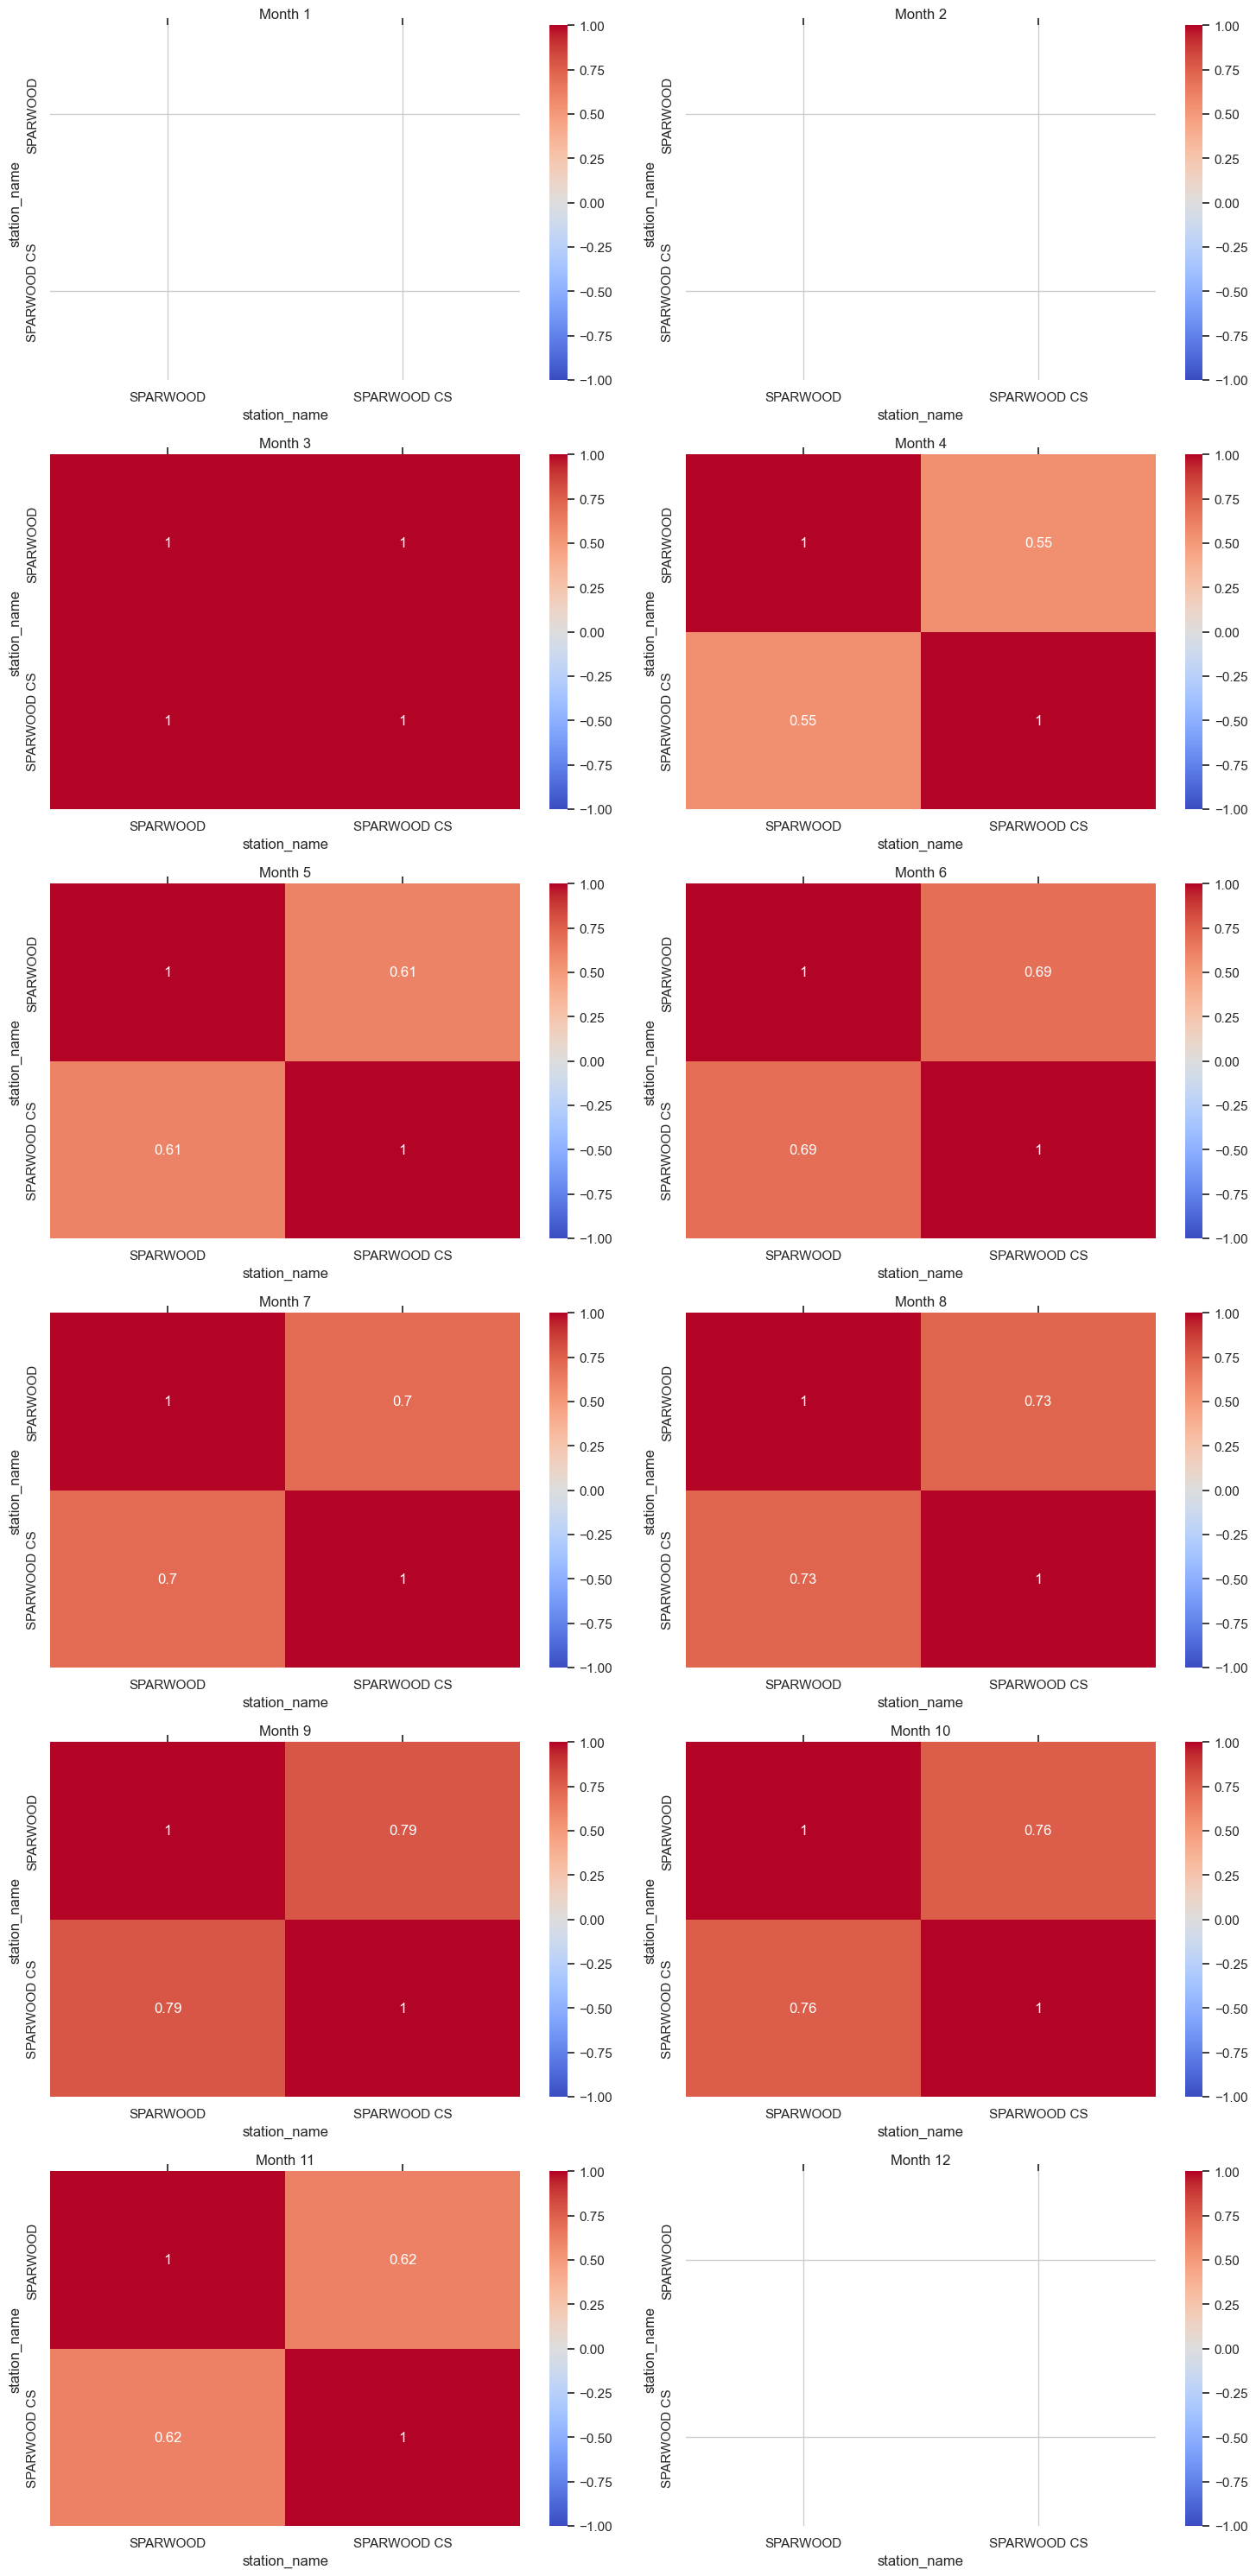

In [192]:
plot_cross_correlation_matrices(c9_monthly_dataframes)

#### Combination 10
combo10 = ['WILLOUGHBY RIDGE', 'SPARWOOD'] 670 count

In [193]:
summary_combo10_monthly_df = describe_dataframes_to_dataframe(c10_monthly_dataframes)
summary_combo10_monthly_df

count       mean        std   min     25%    50%     75%  \
   station_name                                                                 
1  SPARWOOD           78.0   5.289744   5.531130   0.2   0.925   3.05   7.375   
   WILLOUGHBY RIDGE   78.0   5.488462   5.596241   0.3   1.000   3.45   8.400   
   month              78.0   1.000000   0.000000   1.0   1.000   1.00   1.000   
2  SPARWOOD           39.0   5.902564   6.698094   0.4   1.700   3.80   6.250   
   WILLOUGHBY RIDGE   39.0   7.128205   9.555102   0.3   1.500   3.00   7.550   
   month              39.0   2.000000   0.000000   2.0   2.000   2.00   2.000   
3  SPARWOOD           67.0   5.862687   6.420158   0.2   1.000   3.40   8.700   
   WILLOUGHBY RIDGE   67.0   6.579104   6.209951   0.3   1.800   4.00  10.600   
   month              67.0   3.000000   0.000000   3.0   3.000   3.00   3.000   
4  SPARWOOD           58.0   5.139655   6.355325   0.2   1.050   2.70   6.525   
   WILLOUGHBY RIDGE   58.0   8.103448   9.129631   0.3   1.625   5.20  10.400   
   month              58.0   4.000000   0.000000   4.0   4.000   4.00   4.000   
5  SPARWOOD           71.0   5.416901   7.908440   0.2   0.950   3.00   6.350   
   WILLOUGHBY RIDGE   71.0  10.771831  15.242255   0.5   2.000   5.60  11.950   
   month              71.0   5.000000   0.000000   5.0   5.000   5.00   5.000   
6  SPARWOOD           69.0   5.457971   6.303953   0.2   1.500   3.80   6.200   
   WILLOUGHBY RIDGE   69.0   9.828986  14.094535   0.3   2.400   6.10  13.000   
   month              69.0   6.000000   0.000000   6.0   6.000   6.00   6.000   
7  SPARWOOD           33.0   3.675758   3.227231   0.2   1.000   2.80   6.100   
   WILLOUGHBY RIDGE   33.0   4.990909   5.521513   0.3   1.000   2.00   7.900   
   month              33.0   7.000000   0.000000   7.0   7.000   7.00   7.000   
8  SPARWOOD           36.0   5.113889   4.357991   0.2   1.775   3.90   7.250   
   WILLOUGHBY RIDGE   36.0   5.352778   5.426574   0.3   1.000   3.80   8.450   
   month              36.0   8.000000   0.000000   8.0   8.000   8.00   8.000   
9  SPARWOOD           55.0   4.654545   5.445583   0.3   2.000   3.00   5.650   
   WILLOUGHBY RIDGE   55.0   5.783636   7.037197   0.3   1.150   3.60   7.050   
   month              55.0   9.000000   0.000000   9.0   9.000   9.00   9.000   
10 SPARWOOD           46.0   5.802174   6.648024   0.2   1.450   3.40   8.000   
   WILLOUGHBY RIDGE   46.0   7.673913   7.425824   0.3   2.925   5.95   9.275   
   month              46.0  10.000000   0.000000  10.0  10.000  10.00  10.000   
11 SPARWOOD           59.0   6.566102   7.782221   0.2   1.900   4.00   7.750   
   WILLOUGHBY RIDGE   59.0   6.967797   8.498061   0.5   2.000   4.80   9.250   
   month              59.0  11.000000   0.000000  11.0  11.000  11.00  11.000   
12 SPARWOOD           59.0   5.859322   5.526866   0.2   1.800   4.30   8.300   
   WILLOUGHBY RIDGE   59.0   5.540678   6.346357   0.3   1.500   3.10   7.100   
   month              59.0  12.000000   0.000000  12.0  12.000  12.00  12.000   

                       max  
   station_name             
1  SPARWOOD           23.8  
   WILLOUGHBY RIDGE   25.1  
   month               1.0  
2  SPARWOOD           29.2  
   WILLOUGHBY RIDGE   41.4  
   month               2.0  
3  SPARWOOD           27.0  
   WILLOUGHBY RIDGE   27.2  
   month               3.0  
4  SPARWOOD           32.3  
   WILLOUGHBY RIDGE   44.7  
   month               4.0  
5  SPARWOOD           49.1  
   WILLOUGHBY RIDGE   85.3  
   month               5.0  
6  SPARWOOD           35.6  
   WILLOUGHBY RIDGE  103.0  
   month               6.0  
7  SPARWOOD           12.5  
   WILLOUGHBY RIDGE   18.5  
   month               7.0  
8  SPARWOOD           16.4  
   WILLOUGHBY RIDGE   22.9  
   month               8.0  
9  SPARWOOD           35.8  
   WILLOUGHBY RIDGE   39.6  
   month               9.0  
10 SPARWOOD           33.5  
   WILLOUGHBY RIDGE   36.3  
   month              10.0  
11 SPARWOOD   

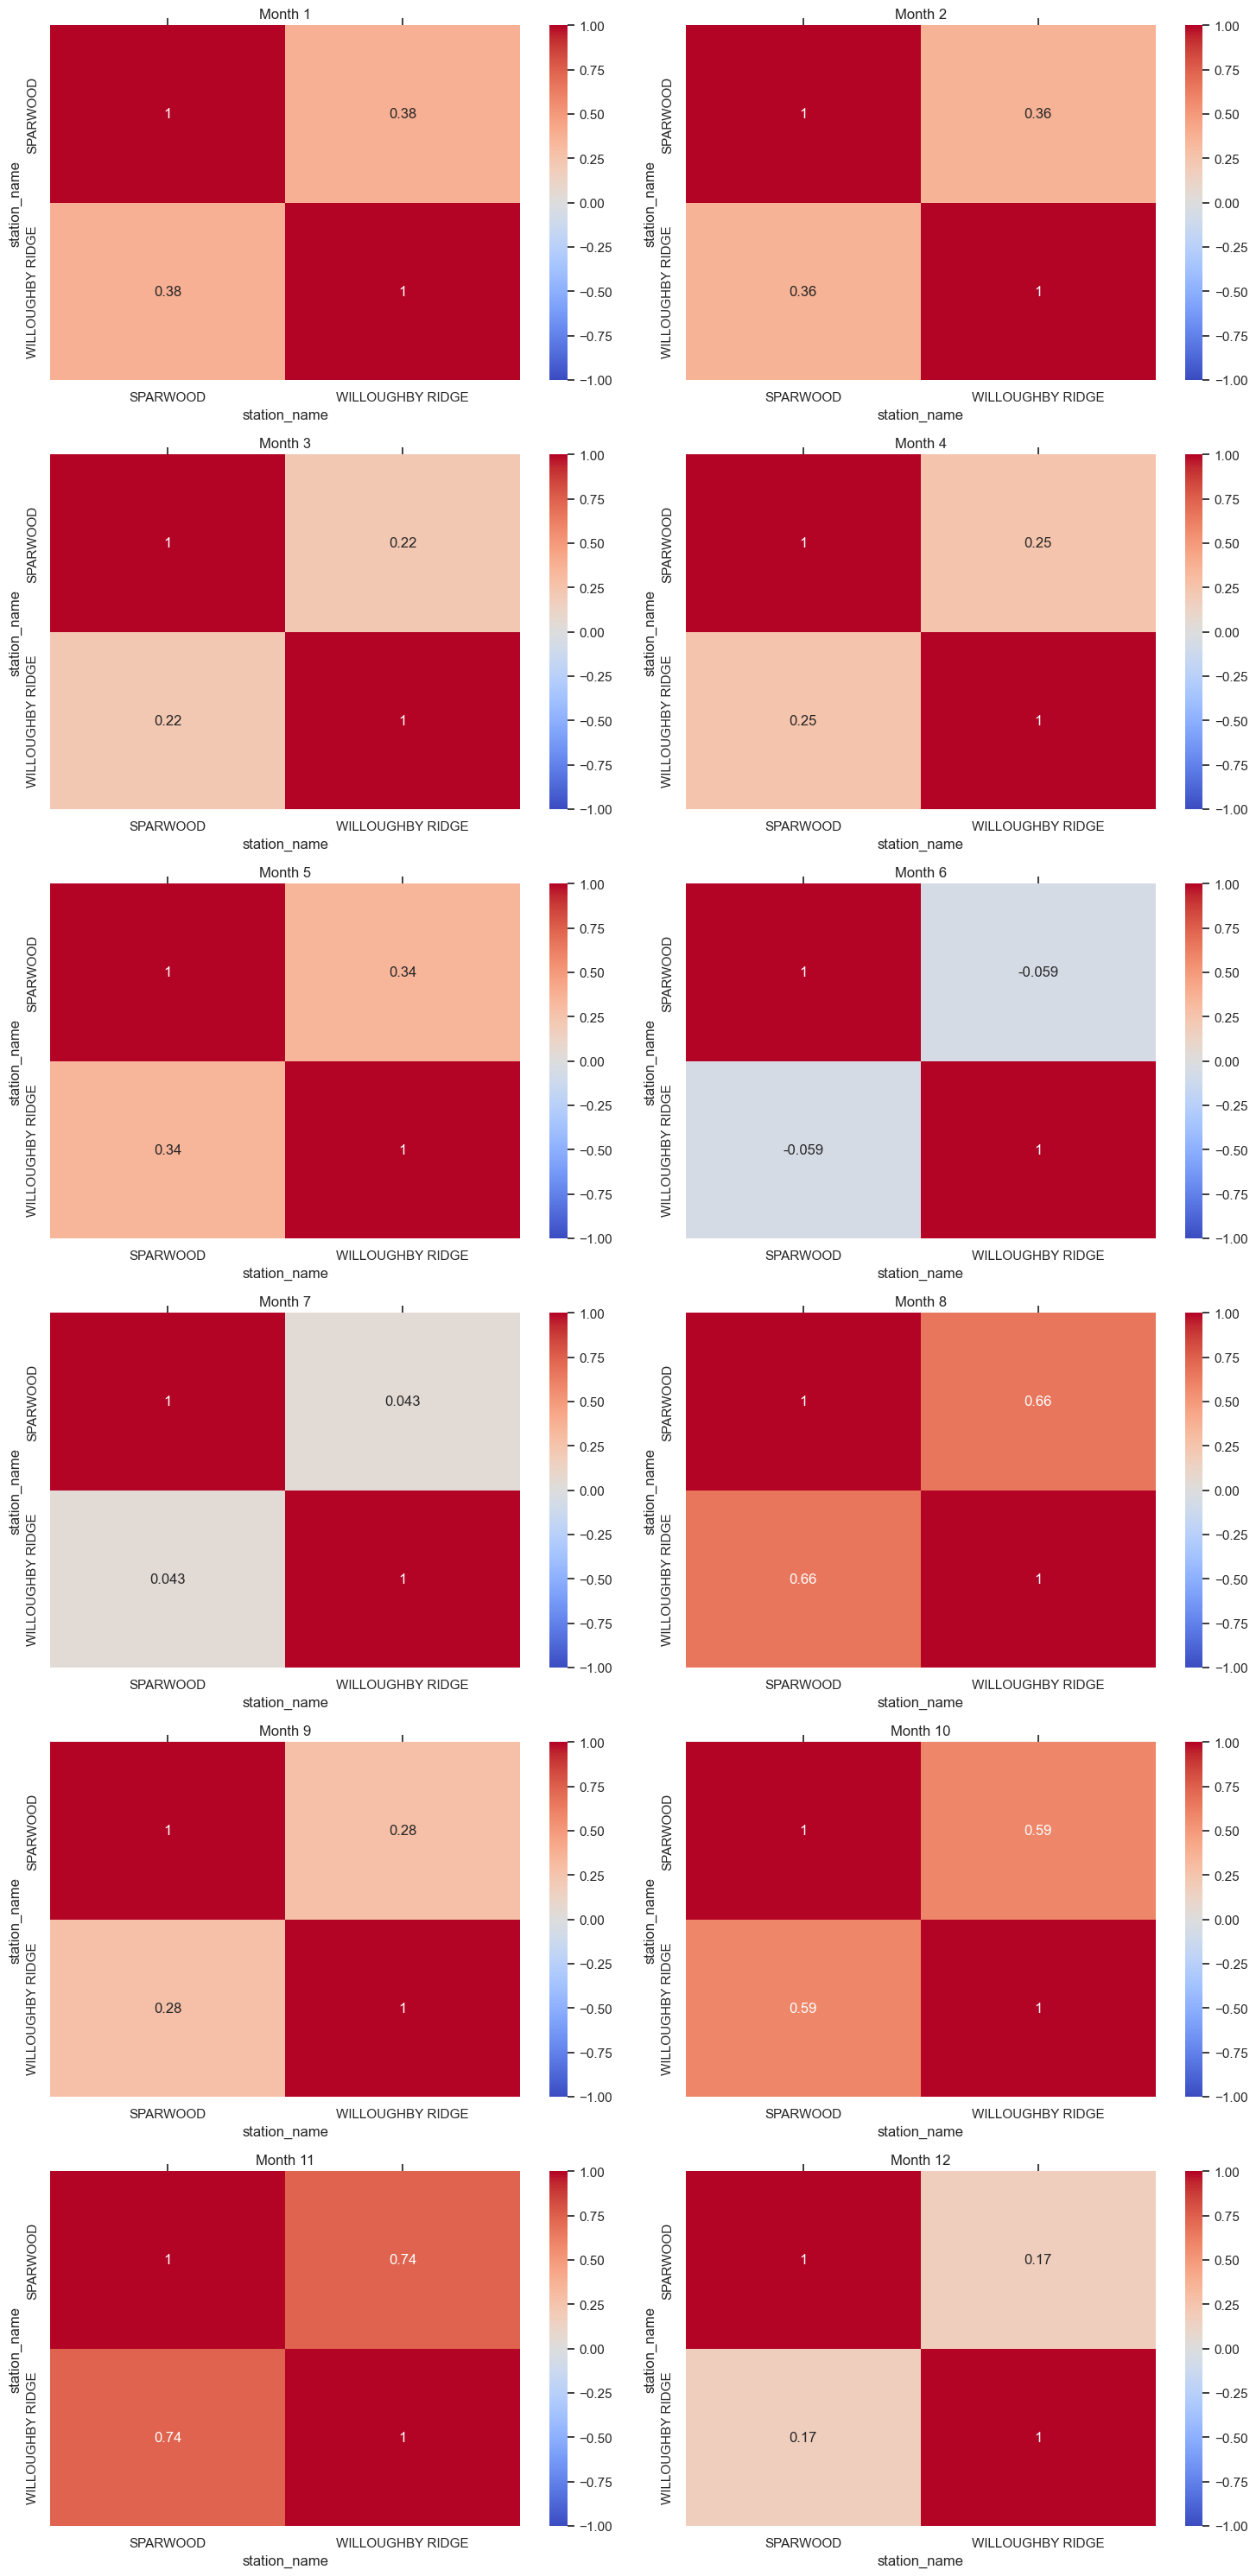

In [194]:
plot_cross_correlation_matrices(c10_monthly_dataframes)

#### Combination 11
combo11 = ['COLEMAN', 'IRONSTONE LO'] 1468 count

In [195]:
summary_combo11_monthly_df = describe_dataframes_to_dataframe(c11_monthly_dataframes)
summary_combo11_monthly_df

count       mean       std   min     25%    50%     75%   max
   station_name                                                               
4  COLEMAN         5.0   3.600000  3.203123   0.6   2.400   2.40   3.600   9.0
   IRONSTONE LO    5.0   4.960000  5.326631   1.9   2.200   2.50   3.800  14.4
   month           5.0   4.000000  0.000000   4.0   4.000   4.00   4.000   4.0
5  COLEMAN       233.0   5.609871  6.524043   0.2   1.200   3.20   7.200  39.4
   IRONSTONE LO  233.0   7.553219  9.894752   0.2   1.700   4.20  10.800  75.8
   month         233.0   5.000000  0.000000   5.0   5.000   5.00   5.000   5.0
6  COLEMAN       386.0   6.140415  7.182788   0.2   1.400   3.55   8.000  52.3
   IRONSTONE LO  386.0   7.073316  9.054613   0.2   1.500   3.80   8.400  63.0
   month         386.0   6.000000  0.000000   6.0   6.000   6.00   6.000   6.0
7  COLEMAN       281.0   6.137367  6.563132   0.2   1.800   4.10   7.600  37.4
   IRONSTONE LO  281.0   6.249466  7.861525   0.2   1.400   3.50   7.900  62.4
   month         281.0   7.000000  0.000000   7.0   7.000   7.00   7.000   7.0
8  COLEMAN       280.0   5.405357  6.965188   0.2   1.375   3.15   6.200  63.0
   IRONSTONE LO  280.0   5.988571  7.030029   0.2   1.475   3.80   7.325  49.7
   month         280.0   8.000000  0.000000   8.0   8.000   8.00   8.000   8.0
9  COLEMAN       230.0   5.285652  5.766127   0.2   1.300   3.00   7.500  38.1
   IRONSTONE LO  230.0   6.218261  6.561521   0.2   1.425   3.80   8.100  34.7
   month         230.0   9.000000  0.000000   9.0   9.000   9.00   9.000   9.0
10 COLEMAN        50.0   5.114000  4.960497   0.5   2.300   3.60   5.975  25.2
   IRONSTONE LO   50.0   7.148000  7.814592   0.6   1.825   4.80   8.900  40.6
   month          50.0  10.000000  0.000000  10.0  10.000  10.00  10.000  10.0
11 COLEMAN         3.0   6.166667  4.619885   1.0   4.300   7.60   8.750   9.9
   IRONSTONE LO    3.0   7.033333  2.977135   3.6   6.100   8.60   8.750   8.9
   month           3.0  11.000000  0.000000  11.0  11.000  11.00  11.000  11.0

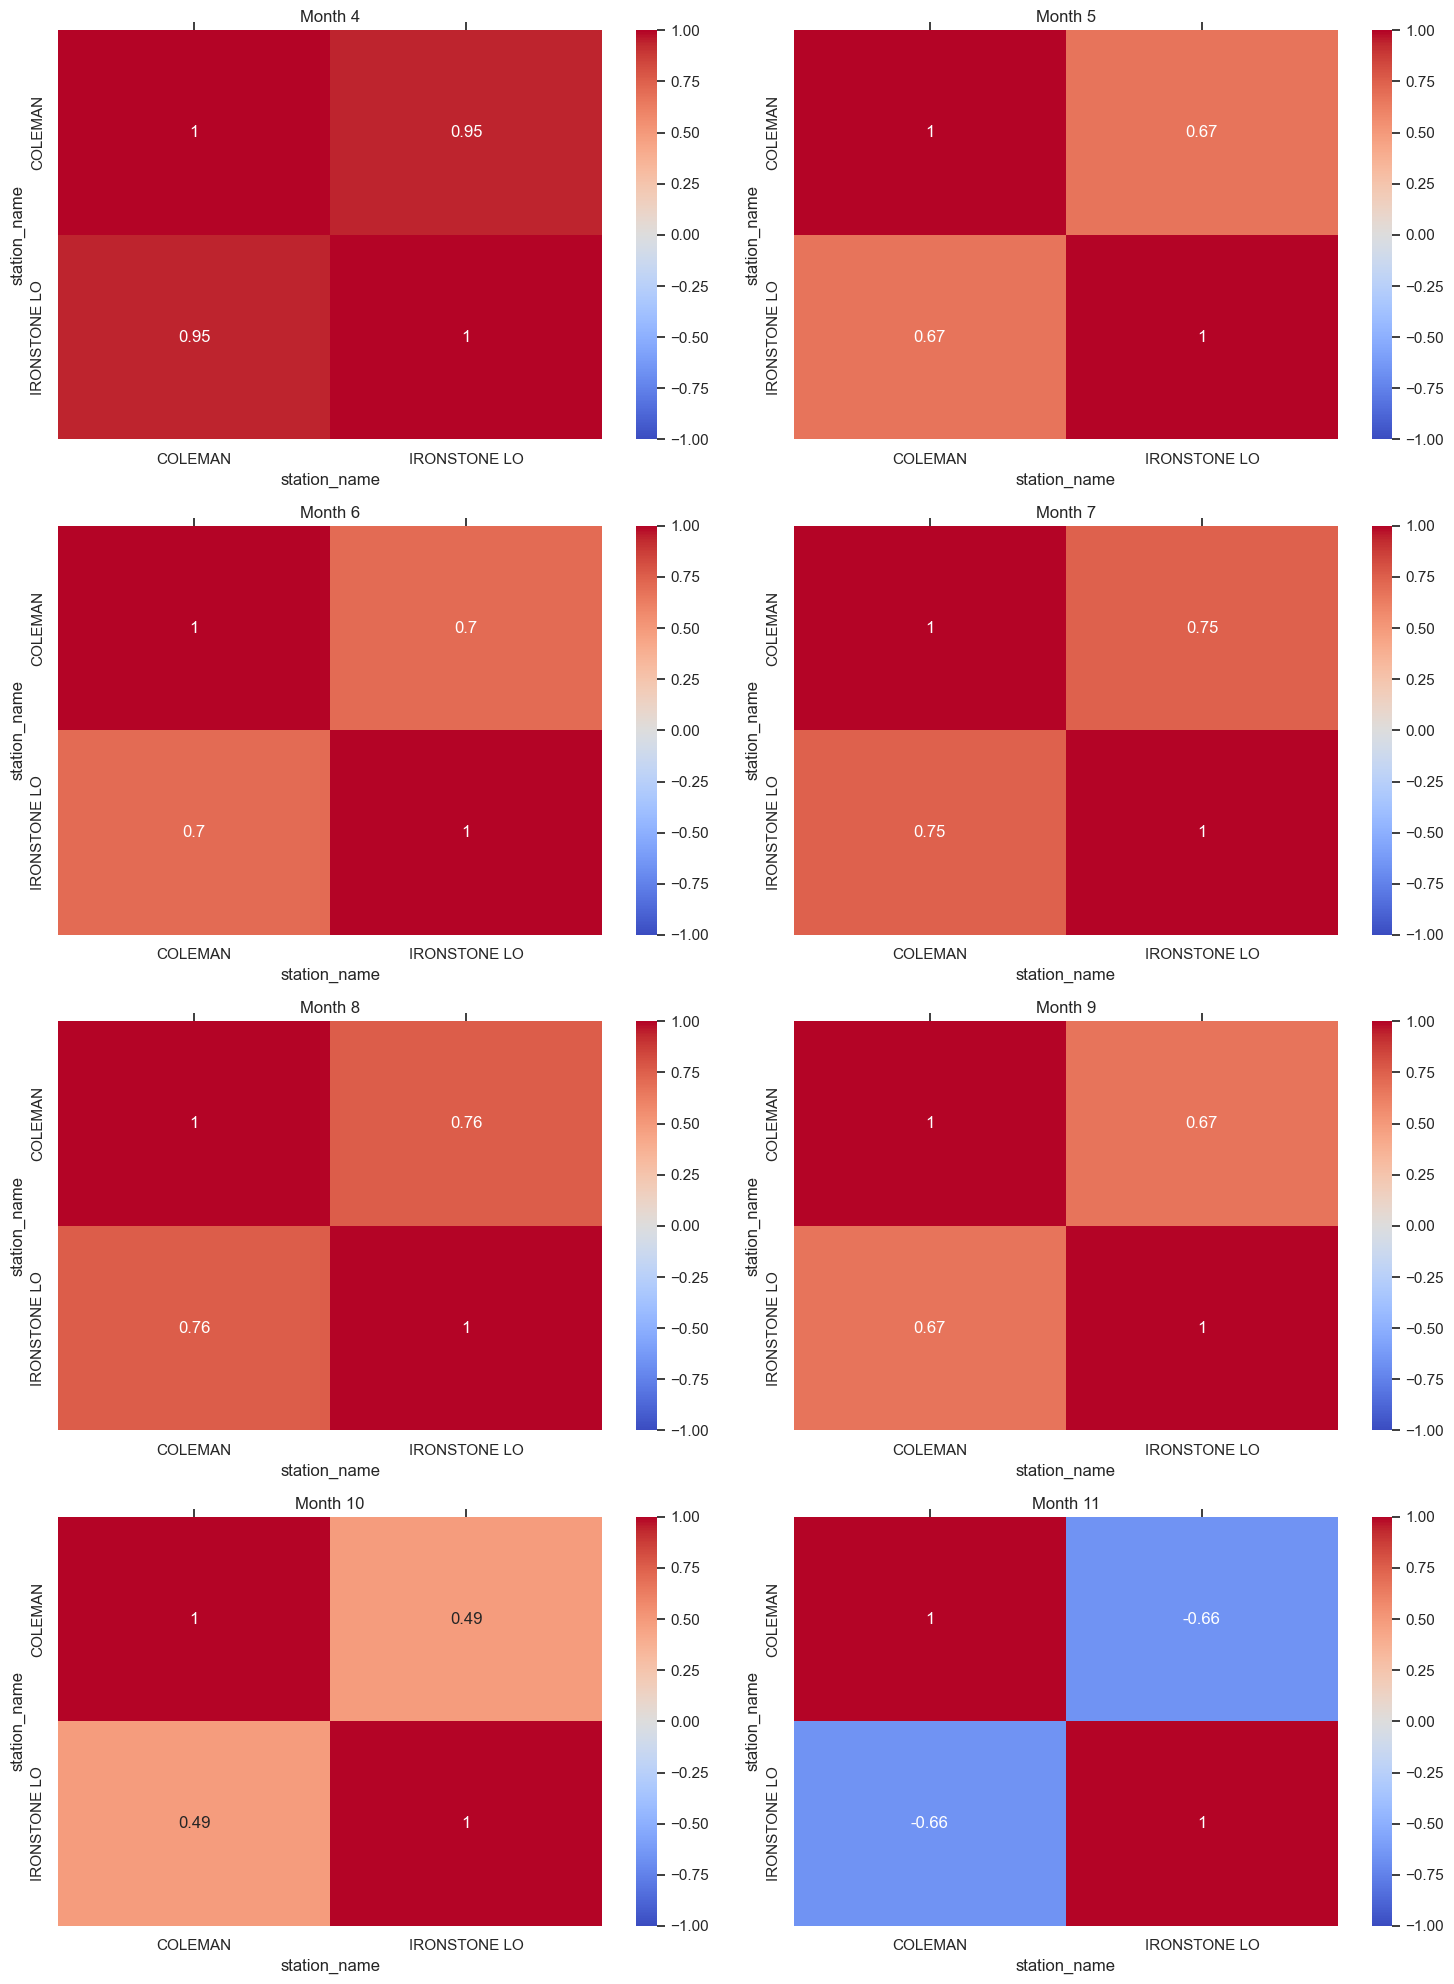

In [196]:
plot_cross_correlation_matrices(c11_monthly_dataframes)

#### Combination 12
combo12 = ['NATAL HARMER RIDGE', 'NATAL KAISER RESOURCES'] 860 count

In [197]:
summary_combo12_monthly_df = describe_dataframes_to_dataframe(c12_monthly_dataframes)
summary_combo12_monthly_df

count       mean       std   min     25%    50%  \
   station_name                                                              
1  NATAL HARMER RIDGE       75.0   7.969333  8.022401   0.3   2.500   5.10   
   NATAL KAISER RESOURCES   75.0   5.765333  6.108423   0.3   1.700   3.80   
   month                    75.0   1.000000  0.000000   1.0   1.000   1.00   
2  NATAL HARMER RIDGE       79.0   8.592405  7.001790   0.5   3.350   6.80   
   NATAL KAISER RESOURCES   79.0   6.036709  7.428206   0.2   1.000   3.80   
   month                    79.0   2.000000  0.000000   2.0   2.000   2.00   
3  NATAL HARMER RIDGE       72.0   5.615278  4.787768   0.5   2.500   3.80   
   NATAL KAISER RESOURCES   72.0   3.808333  3.868899   0.2   1.300   2.70   
   month                    72.0   3.000000  0.000000   3.0   3.000   3.00   
4  NATAL HARMER RIDGE       58.0   5.648276  7.863579   0.3   1.325   3.15   
   NATAL KAISER RESOURCES   58.0   5.556897  7.026794   0.3   1.300   3.80   
   month                    58.0   4.000000  0.000000   4.0   4.000   4.00   
5  NATAL HARMER RIDGE       65.0   5.541538  5.129416   0.3   1.800   3.80   
   NATAL KAISER RESOURCES   65.0   4.744615  4.483582   0.3   1.500   3.30   
   month                    65.0   5.000000  0.000000   5.0   5.000   5.00   
6  NATAL HARMER RIDGE       73.0   4.236986  3.534218   0.3   1.800   2.80   
   NATAL KAISER RESOURCES   73.0   4.353425  5.414309   0.3   0.800   2.80   
   month                    73.0   6.000000  0.000000   6.0   6.000   6.00   
7  NATAL HARMER RIDGE       64.0   7.089062  5.690290   0.5   3.000   5.40   
   NATAL KAISER RESOURCES   64.0   6.106250  6.430850   0.3   1.950   4.10   
   month                    64.0   7.000000  0.000000   7.0   7.000   7.00   
8  NATAL HARMER RIDGE       71.0   7.939437  8.489615   0.3   2.650   5.10   
   NATAL KAISER RESOURCES   71.0   6.978873  6.813263   0.3   1.600   5.30   
   month                    71.0   8.000000  0.000000   8.0   8.000   8.00   
9  NATAL HARMER RIDGE       53.0   6.152830  6.258029   0.5   2.500   4.50   
   NATAL KAISER RESOURCES   53.0   4.694340  4.660737   0.3   1.300   3.60   
   month                    53.0   9.000000  0.000000   9.0   9.000   9.00   
10 NATAL HARMER RIDGE       58.0   6.646552  6.627063   0.5   1.800   4.00   
   NATAL KAISER RESOURCES   58.0   4.655172  4.606638   0.3   1.000   2.50   
   month                    58.0  10.000000  0.000000  10.0  10.000  10.00   
11 NATAL HARMER RIDGE       75.0   8.173333  8.552198   0.5   2.500   5.60   
   NATAL KAISER RESOURCES   75.0   6.596000  7.744962   0.2   1.400   4.10   
   month                    75.0  11.000000  0.000000  11.0  11.000  11.00   
12 NATAL HARMER RIDGE      117.0   7.825641  7.845251   0.5   2.500   5.10   
   NATAL KAISER RESOURCES  117.0   6.144444  7.419318   0.2   1.300   3.00   
   month                   117.0  12.000000  0.000000  12.0  12.000  12.00   

                              75%   max  
   station_name                          
1  NATAL HARMER RIDGE      10.500  38.4  
   NATAL KAISER RESOURCES   6.400  25.4  
   month                    1.000   1.0  
2  NATAL HARMER RIDGE      13.500  29.5  
   NATAL KAISER RESOURCES   7.750  39.7  
   month                    2.000   2.0  
3  NATAL HARMER RIDGE       7.800  25.4  
   NATAL KAISER RESOURCES   5.100  21.6  
   month                    3.000   3.0  
4  NATAL HARMER RIDGE       6.325  51.6  
   NATAL KAISER RESOURCES   7.975  48.3  
   month                    4.000   4.0  
5  NATAL HARMER RIDGE       7.600  21.6  
   NATAL KAISER RESOURCES   6.100  18.0  
   month                    5.000   5.0  
6  NATAL HARMER RIDGE       5.800  15.5  
   NATAL KAISER RESOURCES   5.500  33.0  
   month                    6.000   6.0  
7  NATAL HARMER RIDGE       9.425  27.4  
   NATAL KAISER RESOURCES   7.675  35.6  
   month                    7.000   7.0  
8  NATAL HARMER RIDGE      10.200  53.3  
   NATAL KAISER RESOURCES   8.900  37.6  
   month    

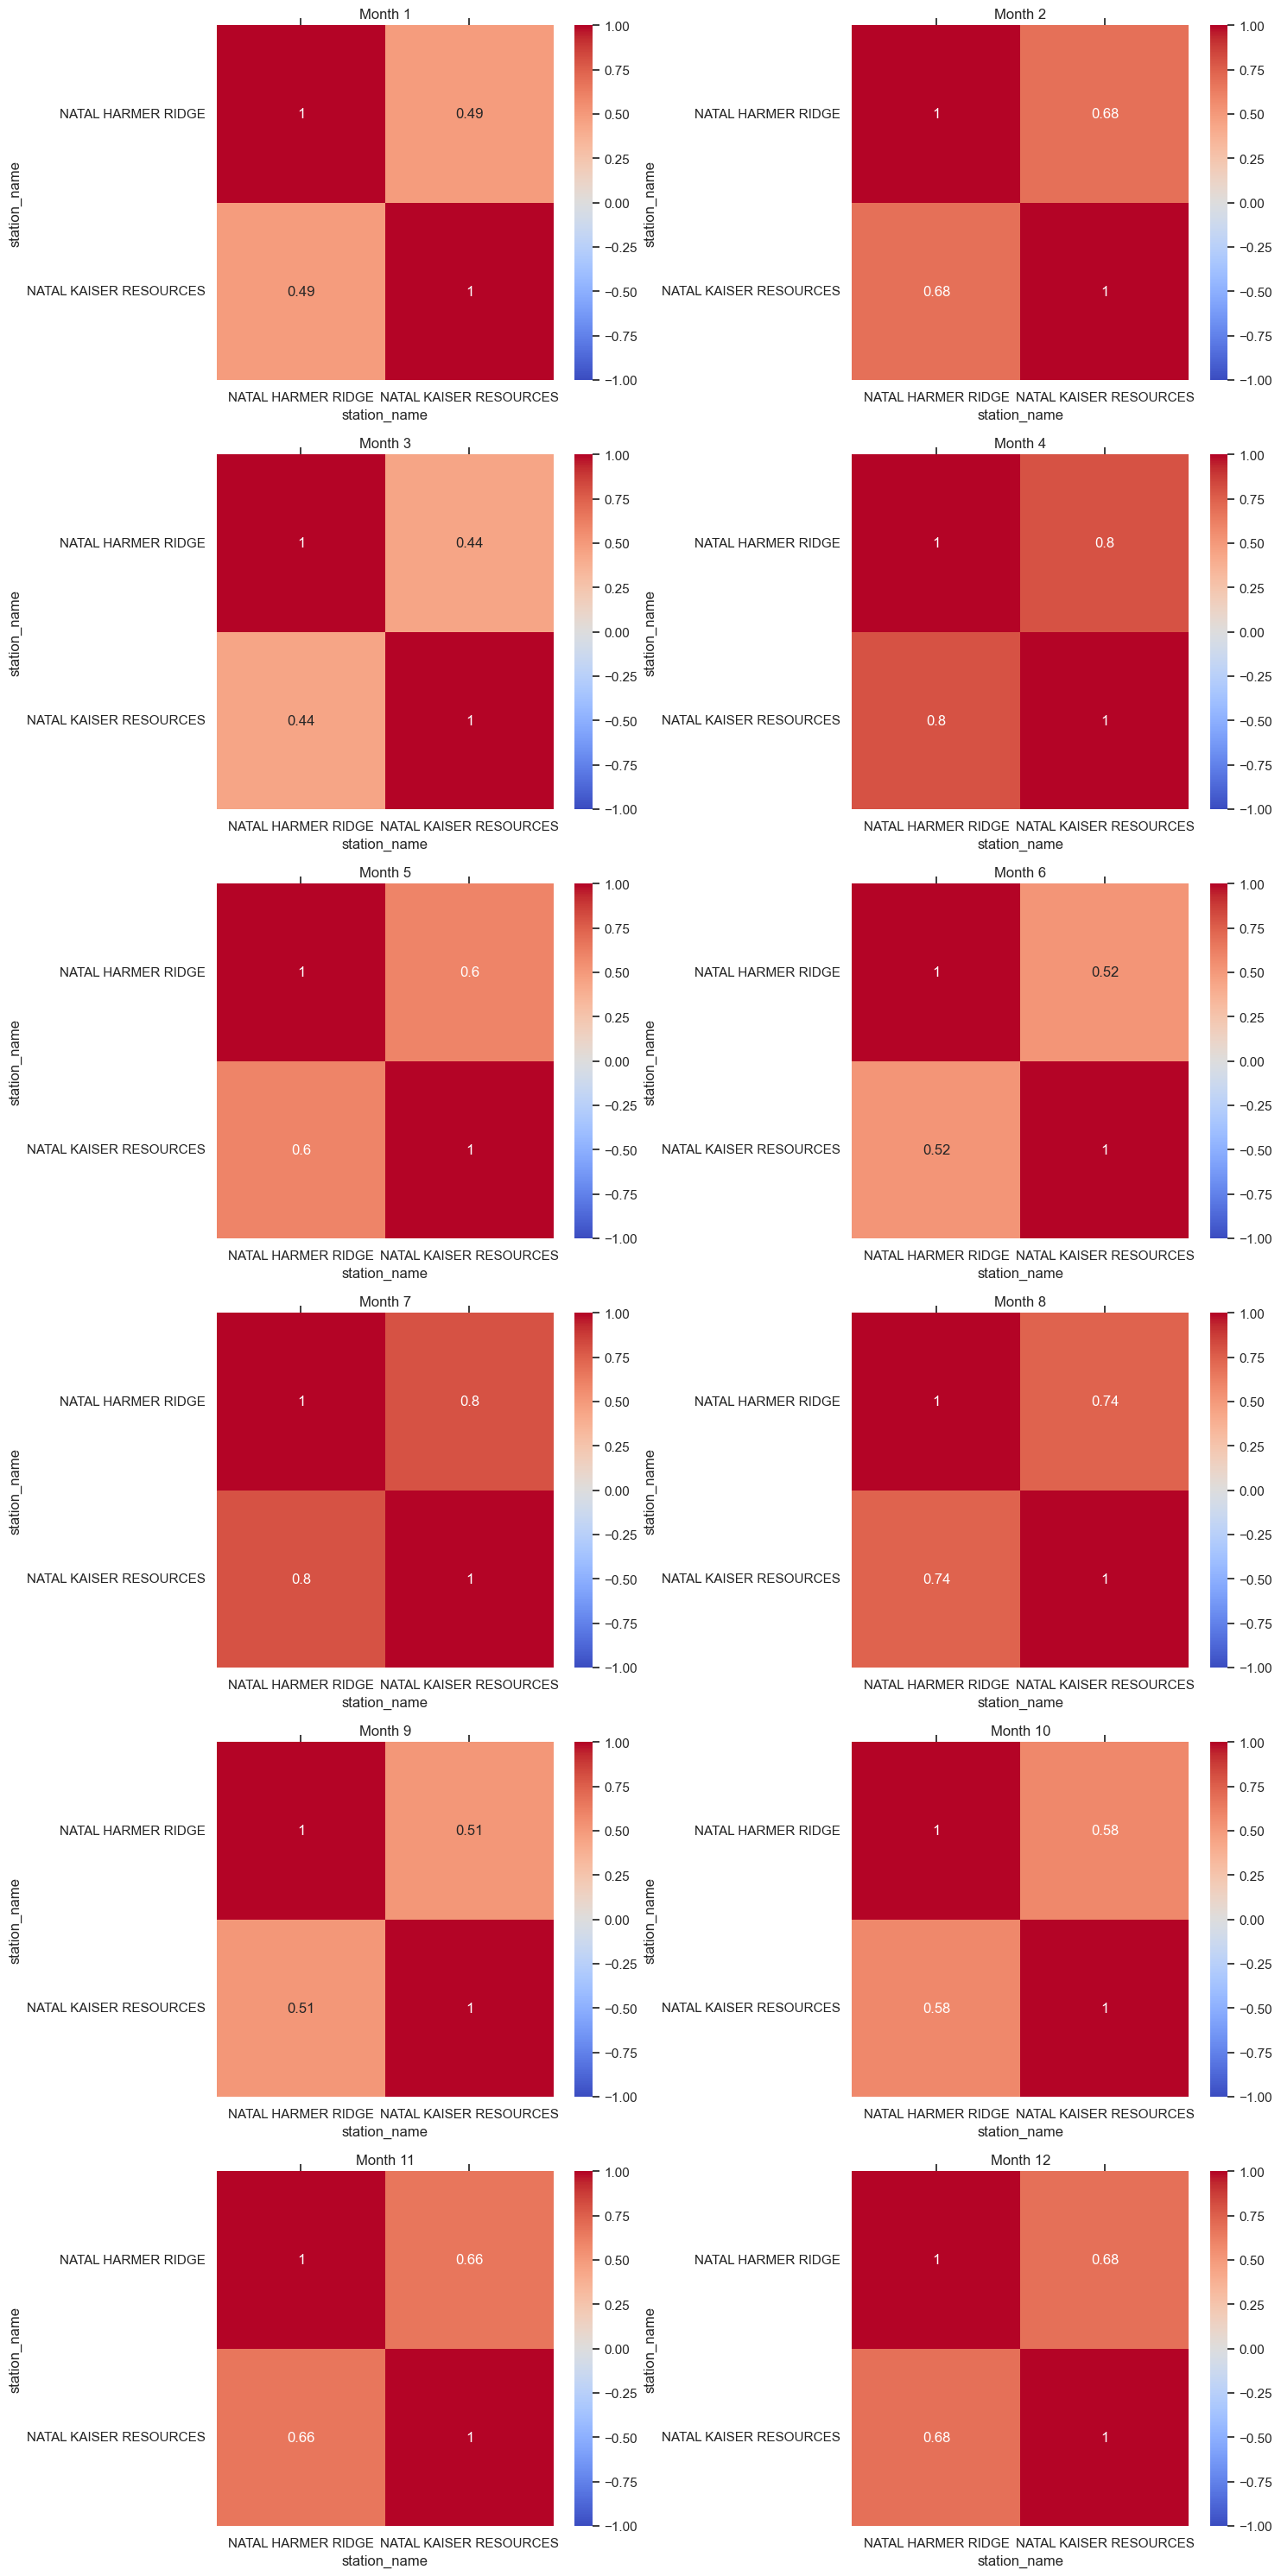

In [198]:
plot_cross_correlation_matrices(c12_monthly_dataframes)

#### Combination 13
combo13 = ['IRONSTONE LO', 'BLAIRMORE HQTS RS'] 865 count

In [199]:
summary_combo13_monthly_df = describe_dataframes_to_dataframe(c13_monthly_dataframes)
summary_combo13_monthly_df

count       mean        std   min    25%    50%     75%  \
   station_name                                                                 
4  BLAIRMORE HQTS RS    3.0   3.166667   4.193249   0.5   0.75   1.00   4.500   
   IRONSTONE LO         3.0   6.700000   6.735726   1.9   2.85   3.80   9.100   
   month                3.0   4.000000   0.000000   4.0   4.00   4.00   4.000   
5  BLAIRMORE HQTS RS  166.0   5.937952   7.291178   0.2   1.00   3.00   8.150   
   IRONSTONE LO       166.0   7.783735  10.535690   0.2   1.80   4.10  10.950   
   month              166.0   5.000000   0.000000   5.0   5.00   5.00   5.000   
6  BLAIRMORE HQTS RS  197.0   6.748731  11.123094   0.2   1.20   3.00   6.600   
   IRONSTONE LO       197.0   6.752284   8.671926   0.2   1.60   3.90   8.000   
   month              197.0   6.000000   0.000000   6.0   6.00   6.00   6.000   
7  BLAIRMORE HQTS RS  179.0   6.941899   8.754131   0.2   1.40   4.00   8.900   
   IRONSTONE LO       179.0   7.001117   8.886121   0.2   1.50   3.80   8.450   
   month              179.0   7.000000   0.000000   7.0   7.00   7.00   7.000   
8  BLAIRMORE HQTS RS  179.0   5.956425   8.064634   0.2   1.00   3.00   7.100   
   IRONSTONE LO       179.0   5.640782   6.602558   0.2   1.40   3.70   7.250   
   month              179.0   8.000000   0.000000   8.0   8.00   8.00   8.000   
9  BLAIRMORE HQTS RS  118.0   5.697458   7.480270   0.2   1.00   2.75   8.175   
   IRONSTONE LO       118.0   5.799153   6.951007   0.2   1.10   3.30   7.575   
   month              118.0   9.000000   0.000000   9.0   9.00   9.00   9.000   
10 BLAIRMORE HQTS RS   23.0   4.243478   3.609309   0.2   1.10   3.40   6.300   
   IRONSTONE LO        23.0   6.900000   7.111578   0.3   2.50   5.70   7.250   
   month               23.0  10.000000   0.000000  10.0  10.00  10.00  10.000   

                       max  
   station_name             
4  BLAIRMORE HQTS RS   8.0  
   IRONSTONE LO       14.4  
   month               4.0  
5  BLAIRMORE HQTS RS  41.7  
   IRONSTONE LO       75.8  
   month               5.0  
6  BLAIRMORE HQTS RS  79.0  
   IRONSTONE LO       63.0  
   month               6.0  
7  BLAIRMORE HQTS RS  58.0  
   IRONSTONE LO       62.4  
   month               7.0  
8  BLAIRMORE HQTS RS  54.4  
   IRONSTONE LO       49.7  
   month               8.0  
9  BLAIRMORE HQTS RS  44.2  
   IRONSTONE LO       34.7  
   month               9.0  
10 BLAIRMORE HQTS RS  11.2  
   IRONSTONE LO       25.4  
   month              10.0

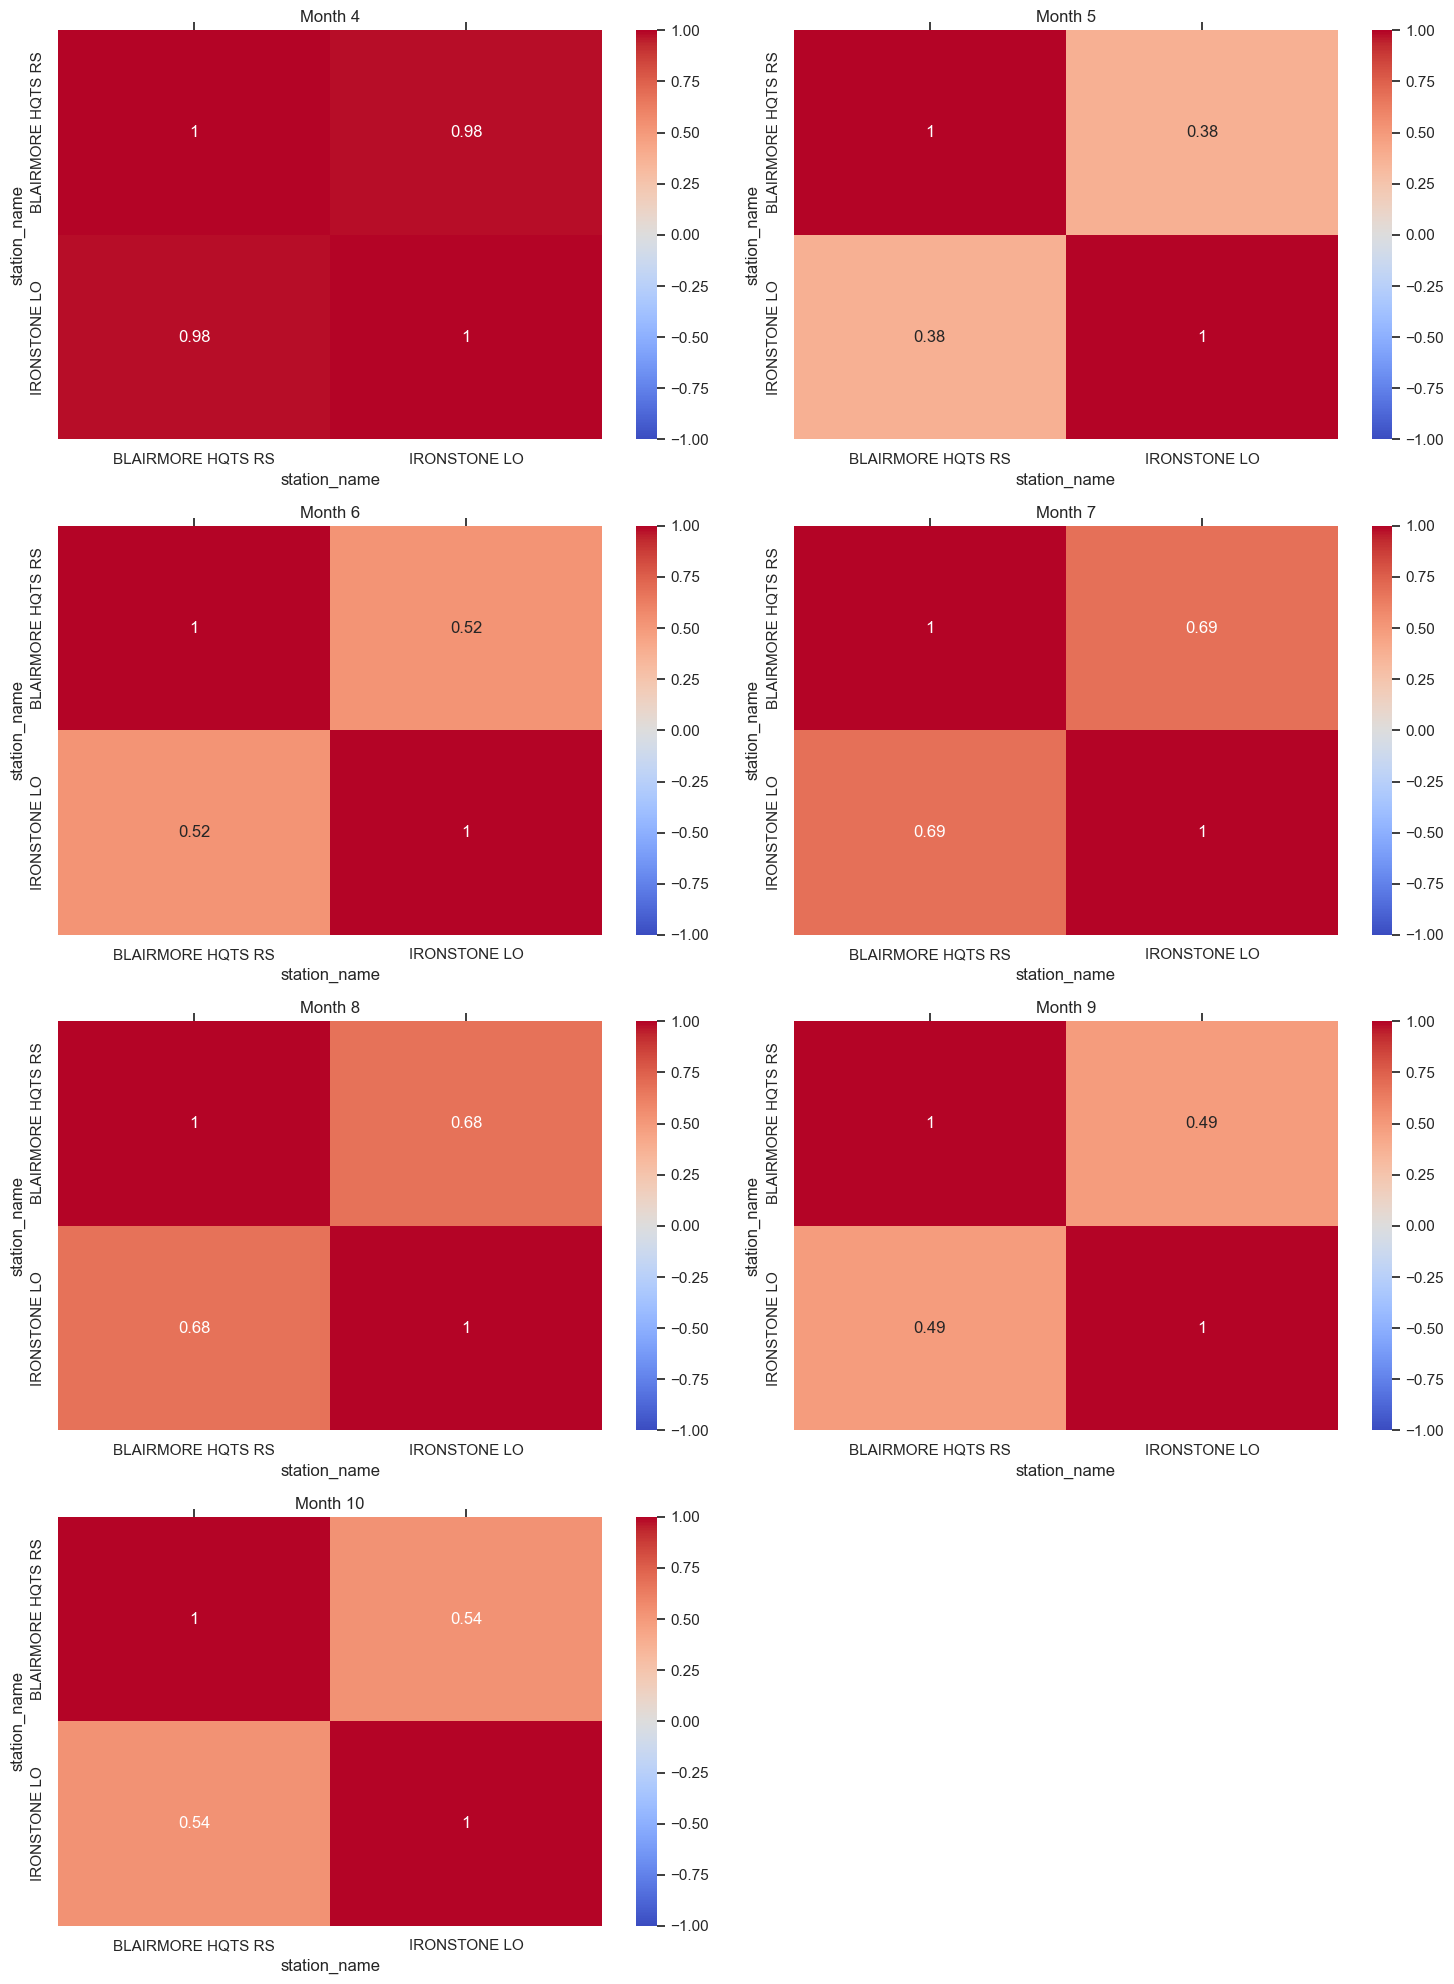

In [200]:
plot_cross_correlation_matrices(c13_monthly_dataframes)

## Supporting 

In [36]:
weathercan_df.dtypes

station_name      object
station_id         int64
prov              object
lat              float64
lon              float64
elev             float64
date              object
year               int64
month              int64
day                int64
qual              object
cool_deg_days    float64
dir_max_gust     float64
heat_deg_days    float64
max_temp         float64
mean_temp        float64
min_temp         float64
snow_grnd        float64
spd_max_gust     float64
total_precip     float64
total_rain       float64
total_snow       float64
dtype: object

In [37]:
weathercan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252964 entries, 0 to 252963
Data columns (total 22 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   station_name   252964 non-null  object 
 1   station_id     252964 non-null  int64  
 2   prov           252964 non-null  object 
 3   lat            252964 non-null  float64
 4   lon            252964 non-null  float64
 5   elev           252964 non-null  float64
 6   date           252964 non-null  object 
 7   year           252964 non-null  int64  
 8   month          252964 non-null  int64  
 9   day            252964 non-null  int64  
 10  qual           4376 non-null    object 
 11  cool_deg_days  87904 non-null   float64
 12  dir_max_gust   9675 non-null    float64
 13  heat_deg_days  87904 non-null   float64
 14  max_temp       88589 non-null   float64
 15  mean_temp      87904 non-null   float64
 16  min_temp       88441 non-null   float64
 17  snow_grnd      30206 non-null

In [49]:
CROWSNEST_CREEK_df = station_dfs['CROWSNEST_CREEK_df']

# Group by 'year' and 'month' and calculate the mean precipitation
CROWSNEST_CREEK_df['monthly_mean_precip'] = (
    CROWSNEST_CREEK_df.groupby(['year', 'month'])['total_precip']
    .transform('mean'))

CROWSNEST_CREEK_df

station_name  station_id prov    lat     lon    elev       date  \
0     CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 1998-01-01   
1     CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 1998-01-02   
2     CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 1998-01-03   
3     CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 1998-01-04   
4     CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 1998-01-05   
...               ...         ...  ...    ...     ...     ...        ...   
9500  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 2024-01-05   
9501  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 2024-01-06   
9502  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 2024-01-07   
9503  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 2024-01-08   
9504  CROWSNEST CREEK       10690   AB  49.61 -114.68  1387.0 2024-01-09   

      year  month  day  ... heat_deg_days  max_temp  mean_temp  min_temp  \
0     1998      1    1  ...           NaN       NaN        NaN       NaN   
1     1998      1    2  ...           NaN       NaN        NaN       NaN   
2     1998      1    3  ...           NaN       NaN        NaN       NaN   
3     1998      1    4  ...           NaN       NaN        NaN       NaN   
4     1998      1    5  ...           NaN       NaN        NaN       NaN   
...    ...    ...  ...  ...           ...       ...        ...       ...   
9500  2024      1    5  ...           NaN       NaN        NaN       NaN   
9501  2024      1    6  ...           NaN       NaN        NaN       NaN   
9502  2024      1    7  ...           NaN       NaN        NaN       NaN   
9503  2024      1    8  ...           NaN       NaN        NaN       NaN   
9504  2024      1    9  ...           NaN       NaN        NaN       NaN   

      snow_grnd  spd_max_gust  total_precip  total_rain  total_snow  \
0           NaN           NaN           NaN         NaN         NaN   
1           NaN           NaN           NaN         NaN         NaN   
2           NaN           NaN           NaN         NaN         NaN   
3           NaN           NaN           NaN         NaN         NaN   
4           NaN           NaN           NaN         NaN         NaN   
...         ...           ...           ...         ...         ...   
9500        NaN           NaN           NaN         NaN         NaN   
9501        NaN           NaN           NaN         NaN         NaN   
9502        NaN           NaN           NaN         NaN         NaN   
9503        NaN           NaN           NaN         NaN         NaN   
9504        NaN           NaN           NaN         NaN         NaN   

      monthly_mean_precip  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
...                   ...  
9500                  NaN  
9501                  NaN  
9502                  NaN  
9503                  NaN  
9504                  NaN  

[9505 rows x 23 columns]

In [47]:
distinct_values_crowsnest_year = CROWSNEST_CREEK_df['year'].unique()
distinct_values_crowsnest_year

array([1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020, 2021, 2022, 2023, 2024], dtype=int64)

In [52]:
distinct_values_crowsnest_year_counts = CROWSNEST_CREEK_df['year'].value_counts()
distinct_values_crowsnest_year_counts

year
2000    366
2004    366
2020    366
2008    366
2016    366
2012    366
1998    365
2014    365
2023    365
2022    365
2021    365
2019    365
2018    365
2017    365
2015    365
2011    365
2013    365
1999    365
2010    365
2009    365
2007    365
2006    365
2005    365
2003    365
2002    365
2001    365
2024      9
Name: count, dtype: int64

In [53]:
distinct_values_crowsnest = CROWSNEST_CREEK_df['monthly_mean_precip'].unique()
distinct_values_crowsnest

array([       nan, 0.67419355, 2.12333333, 2.1516129 , 1.13225806,
       1.04642857, 0.91290323, 1.24333333, 2.08064516, 3.10666667,
       1.21612903, 2.17741935, 0.92666667, 2.88709677, 2.65666667,
       0.55806452, 1.83548387, 0.91724138, 1.25483871, 0.88666667,
       2.26451613, 3.52666667, 0.77096774, 0.8516129 , 0.96774194,
       0.40645161, 0.93214286, 1.26129032, 2.28965517, 0.59677419,
       3.62      , 0.32258065, 0.15806452, 0.4       , 1.44193548,
       1.06      , 1.03225806, 2.4       , 2.05714286, 1.38709677,
       1.33      , 3.2483871 , 3.80666667, 0.56129032, 1.17741935,
       2.45333333, 0.74333333, 1.39677419, 1.32903226, 0.30357143,
       2.59032258, 2.39666667, 1.78064516, 1.82      , 0.12258065,
       0.11612903, 0.78      , 2.3483871 , 2.05333333, 0.11724138,
       1.0483871 , 0.78333333, 1.85483871, 3.24666667, 1.71935484,
       3.19354839, 2.18333333, 1.51612903, 1.14      , 1.2       ,
       2.01290323, 1.25      , 1.18709677, 0.99666667, 1.71612

In [56]:
# Check if monthly mean calc match
monthly_mean_precip_counts = (
    CROWSNEST_CREEK_df.groupby(['year', 'monthly_mean_precip'])
    .size()
    .reset_index(name='counts')
)
monthly_mean_precip_counts

year  monthly_mean_precip  counts
0   1998             0.674194      31
1   1998             2.123333      30
2   1998             2.151613      31
3   1999             0.558065      31
4   1999             0.912903      31
..   ...                  ...     ...
78  2005             2.830769      30
79  2005             3.106452      31
80  2005             5.123333      30
81  2005             7.830000      30
82  2007             0.433333      30

[83 rows x 3 columns]

In [65]:
# Check if monthly mean calc match
# Filter the DataFrame for the station 'CROWSNEST_CREEK'
CROWSNEST_CREEK_df_from_wc = weathercan_df[weathercan_df['station_name'] == 'CROWSNEST CREEK']

# Group by 'year' and 'monthly_mean_precip' and get value counts
monthly_mean_precip_counts_wc = (
    CROWSNEST_CREEK_df_from_wc.groupby(['year', 'monthly_mean_precip'])
    .size()
    .reset_index(name='counts')
)

# Print or use the resulting DataFrame as needed
monthly_mean_precip_counts_wc

year  monthly_mean_precip  counts
0   1998             0.674194      31
1   1998             2.123333      30
2   1998             2.151613      31
3   1999             0.558065      31
4   1999             0.912903      31
..   ...                  ...     ...
78  2005             2.830769      30
79  2005             3.106452      31
80  2005             5.123333      30
81  2005             7.830000      30
82  2007             0.433333      30

[83 rows x 3 columns]